# Milestone 2

By December 15 you shall have implemented multiple baseline solutions to
your main text classification task. These should include both deep learning (DL) based methods
such as those introduced in Weeks 5-6 but also non-DL models such as those shown in Week 3.
Baselines can also include simple rule-based methods (e.g. keyword matching or regular expres-
sions). Each baseline should be evaluated both quantitatively and qualitatively, more details will
be provided in the lecture on text classification (Week 3)


## Load modules

In [75]:
#Functions
from utils import extract_original_text, extract_preprocessed_text, load_conllu_data

#Global
import numpy as np
import os
import pandas as pd
import conllu
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

#Sickit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_fscore_support
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
import joblib
import shap

#NN, Transformers
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import transformers
from transformers import Trainer, TrainingArguments
from transformers import BertTokenizer, AutoTokenizer
from transformers import BertForSequenceClassification, AutoModelForSequenceClassification, RobertaForSequenceClassification

## Load files

In [76]:
# Load the entire .conllu file into a Python variable
conllu_data = []
with open('Data/preprocessed_dataset.conllu', 'r', encoding='utf-8') as f:
    for line in f:
        conllu_data.append(line.strip())

# Display a sample of the loaded data (e.g., first 5 lines)
print("\n".join(conllu_data[:10]))

anns = pd.read_table('Data/annotations.txt', header=None)

# sent_id = 0_0
# text = And this Conservative strategy has produced the angry and desperate wing-nuts like the fellow who called reporters 'lying pieces of Sh*t' this week.
1	And	and	CCONJ	CC	_	None	None	_	_
2	this	this	DET	DT	Number=Sing|PronType=Dem	None	None	_	_
3	Conservative	Conservative	ADJ	JJ	Degree=Pos	None	None	_	_
4	strategy	strategy	NOUN	NN	Number=Sing	None	None	_	_
5	has	have	AUX	VBZ	Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin	None	None	_	_
6	produced	produce	VERB	VBN	Tense=Past|VerbForm=Part	None	None	_	_
7	the	the	DET	DT	Definite=Def|PronType=Art	None	None	_	_
8	angry	angry	ADJ	JJ	Degree=Pos	None	None	_	_


Format of sent_id : X_Y

Where X is the id of the comment, while Y is the id of the sentence.

Example : 2_3 means it's comment with id 2 and its 3rd sentence.

## Load both original and preprocessed texts

In [77]:
file_path = 'Data/preprocessed_dataset.conllu'
original_list = extract_original_text(file_path)
original_list[:3]

["And this Conservative strategy has produced the angry and desperate wing-nuts like the fellow who called reporters 'lying pieces of Sh*t' this week. The fortunate thing is that reporters were able to report it and broadcast it - which may shake up a few folks who recognize a bit of themselves somewhere in there and do some reflecting. I live in hope.",
 "I commend Harper for holding the debates outside of a left-wing forum as this will help prevent the left from manipulating the debates to try to make Harper look bad. Indeed, we’ll finally have some fair debates. Trudeau is a coward and the only one who’s opposing this as he’s terrified about losing left-wing protection during the debates if the debates are held elsewhere. If Trudeau doesn’t have Chretien or Martin speaking for him or isn't currently in training to learn how to handle himself in a debate, he has May attending the debates to hold his little hand. If Trudeau can’t speak for himself or handle debates, how does he expect

In [78]:
preprocessed_list = extract_preprocessed_text(file_path)
preprocessed_list[:3]

["and this conservative strategy have produce the angry and desperate wing - nut like the fellow who call reporter 's lying piece of sh*tember ' this week . the fortunate thing be that reporter be able to report it and broadcast it - which may shake up a few folk who recognize a bit of themselves somewhere in there and do some reflect . i live in hope .",
 'i commend harper for hold the debate outside of a left - wing forum as this will help prevent the left from manipulate the debate to try to make harper look bad . indeed , we will finally have some fair debate . trudeau be a coward and the only one who be oppose this as he be terrified about lose left - wing protection during the debate if the debate be hold elsewhere . if trudeau do not have chretien or martin speak for he or be not currently in training to learn how to handle himself in a debate , he have may attend the debate to hold his little hand . if trudeau can not speak for himself or handle debate , how do he expect to run

# Naive Bayesian Classifier

$P(C|X) = \frac{P(X|C) \cdot P(C)}{P(X)}$

Where:

- $P(C|X)$ is the posterior probability of class $C$ given features $X$
- $P(X|C)$ is the likelihood of features $X$ given class $C$
- $P(C)$ is the prior probability of class $C$
- $P(X)$ is the total probability of features $X$


### For original text

1. Gather Data (already done)
2. Vectorization (using TF-IDF)
3. Splitting into training and testing data
4. Training the Naive Bayes classifier
5. Evaluate the model

In [79]:
#2 Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(original_list)
y = anns

#3 Splitting into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#4 Training the Naive Bayes classifier
param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}  # Adjust the range as needed
model = MultinomialNB()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train.values.ravel())

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_
print(f"Best alpha: {grid_search.best_params_['alpha']}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

#5 Evaluate the model
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best alpha: 0.1
Best cross-validation accuracy: 0.6761
Accuracy: 0.6875

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.48      0.58      1086
           1       0.67      0.86      0.75      1314

    accuracy                           0.69      2400
   macro avg       0.70      0.67      0.67      2400
weighted avg       0.70      0.69      0.67      2400



### For preprocessed text

In [7]:
#2 Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(preprocessed_list)
y = anns

#3 Splitting into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#4 Training the Naive Bayes classifier
param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}  # Adjust the range as needed
model = MultinomialNB()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train.values.ravel())

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_
print(f"Best alpha: {grid_search.best_params_['alpha']}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

#5 Evaluate the model
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best alpha: 0.1
Best cross-validation accuracy: 0.6760
Accuracy: 0.6808333333333333

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.47      0.57      1086
           1       0.66      0.85      0.75      1314

    accuracy                           0.68      2400
   macro avg       0.69      0.66      0.66      2400
weighted avg       0.69      0.68      0.67      2400



# Second experiment: Use Feature based models 

Idea: Use the features from the CONLL-U format to feed Machine Learning models (SVM, Random Forest, KNN and else) in order to classify the text

1. Extraction of the features:
    - number of tokens
    - average word length
    - number of sentences
    - number of noun, verb, adjective, adverb, pronoun, conjunction and determiner
2. Splitting into training and testing data
3. Training the models using different parameters
    - K-Nearest Neighbor
    - Random Forest
    - Logisitc Regression
4. Evaluating the best models

In [6]:
file_path = 'Data/preprocessed_dataset.conllu'
features_conllu = load_conllu_data(file_path)
X = features_conllu.drop(['comment_id'], axis=1)
y = anns 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameter grids
param_grids = {
    'knn': {
        'n_neighbors': [3, 5, 10, 15,20,50,100],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'rf': {
        'n_estimators': [10,25, 50, 100, 150],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'logisticregression': {
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear'],
        'max_iter':[1000]
    }
}

# Train and tune models
models = {
    'knn': KNeighborsClassifier(),
    'rf': RandomForestClassifier(random_state=42),
    'logisticregression': LogisticRegression()
}

best_models = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    grid_search = GridSearchCV(model, param_grids[model_name.lower()], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train.values.ravel())
    
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")
    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model

    # Evaluate on the test set
    y_pred = best_model.predict(X_test)
    print(f"\n{model_name} Classification Report:\n", classification_report(y_test, y_pred))


Training knn...


C:\Users\Ugo\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters for knn: {'metric': 'manhattan', 'n_neighbors': 50, 'weights': 'uniform'}

knn Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90      1086
           1       0.91      0.92      0.92      1314

    accuracy                           0.91      2400
   macro avg       0.91      0.91      0.91      2400
weighted avg       0.91      0.91      0.91      2400


Training rf...
Best Parameters for rf: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}

rf Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92      1086
           1       0.93      0.93      0.93      1314

    accuracy                           0.92      2400
   macro avg       0.92      0.92      0.92      2400
weighted avg       0.92      0.92      0.92      2400


Training logisticregression...
Best Parameters for logisticregression: {'C': 1, 'max_iter': 1000

## Model explainability

One way to give more explainability to our model is to use SHAP (SHapley Additive exPlanations) values. They quantify how much each feature contributes to a model's prediction for a specific instance, compared to a baseline prediction (typically the average model output).

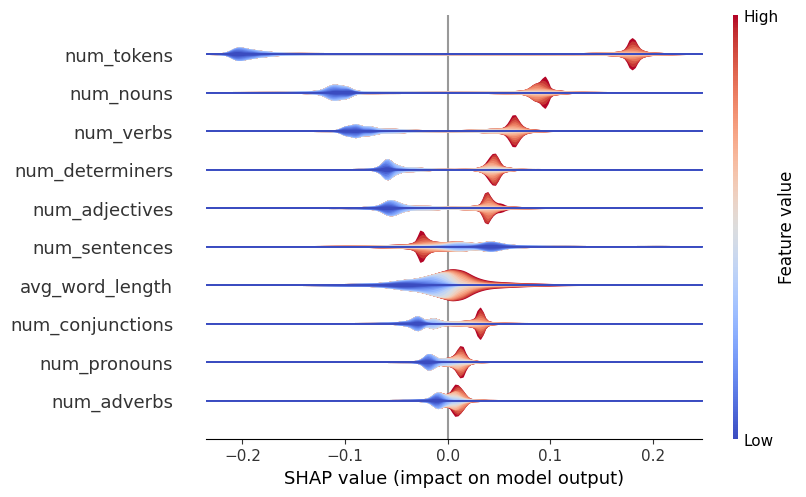

In [10]:
# Create a SHAP Tree Explainer
explainer = shap.TreeExplainer(joblib.load("../models/rf_model.pkl"))
shap_values = explainer.shap_values(X_test)
shap.plots.violin(shap_values[:, :, 1], X_test, plot_type="layered_violin")

SHAP values are really intersting what helps our model makes decision towards a class or another, here we learn different things: 
- The number of tokens, nouns and verbs are the features that helps the most our Random Forest
- All of the features, if they have large values (such as a lot of nouns, a lot of verbs) will increase the likelihood in predicting class 1: The Constructive comments
    - One is the opposite, the more sentence there is in a comment, the more likely it will be predicted as Not-Constructive, but the SHAP value is still really low
- Conjunctions, Pronouns and adverbs seems to not play a really big role in the decision taking part of our model

## Qualitative analysis of misclassified comments

The analysis is done on the best behaving feature based model, the Random Forest.

In [11]:
# Retain 'comment_id' for reference
X = features_conllu.drop(['comment_id'], axis=1)
comment_ids = features_conllu['comment_id']

# Split data, retaining comment IDs in the test set
X_train, X_test, y_train, y_test, comment_ids_train, comment_ids_test = train_test_split(
    X, y, comment_ids, test_size=0.2, random_state=42)

# Retrain the best RF model with specified parameters
best_rf = RandomForestClassifier(max_depth=10, min_samples_split=2, n_estimators=50, random_state=42)
best_rf.fit(X_train, y_train.values.ravel())

# Predict on the test set
y_pred = best_rf.predict(X_test)
y_test_array = y_test.values.ravel()
# Identify misclassified indices
misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_test_array, y_pred)) if true != pred]

# Group misclassified samples by true class
misclassified_by_category = {0: [], 1: []}

for idx in misclassified_indices:
    true_class = y_test_array[idx]
    if true_class in misclassified_by_category:
        misclassified_by_category[true_class].append(comment_ids_test.iloc[idx])

# Print up to 3 misclassified comment IDs for each category
print("Misclassified examples:\n")
for category, comment_ids in misclassified_by_category.items():
    category_name = "constructive" if category == 0 else "not constructive"
    print(f"Category '{category_name}' misclassified as being the opposite:")
    for i, comment_id in enumerate(comment_ids[:3]):
        print(f"- {original_list[int(comment_id)]}\n")
    print()

Misclassified examples:

Category 'constructive' misclassified as being the opposite:
- Trump is irrelevant. The US citizenry needs to clean out the corrupt government as required every several generations. It would have been Perot or Buchanan at another time. Get rid of Trump, and there will be a different name with the same agenda. And the media and establishment will oppose him or her too.

- Until the Globe editorial board can explain why they endorsed the Harper government time and time again and at the same they are reporting on the corruption and lies and scams. These editorials just look foolish to me. Now their a problem with the Harper government?

- '........... that small symbolic acts have great power, ..........'. Yeah, symbology like the fact that some of the strongest proponents for massive lifestyle change just happen to be amongst the biggest carbon gluttons on the planet. You listening Dave?


Category 'not constructive' misclassified as being the opposite:
- Margare

## Takeways

As of Cambridge Dictionary, the definition of 'constructive' is the following: 
- If advice, criticism, or actions are constructive, they are useful and intended to help or improve something

Some synonyms are: useful, helpful, valuable
Saying if a sentence, or a text, is constructive, is in some case prone to subjectivity. As our comments were annotated by crowdworkers, it's possible that another one might argue a comment is or isn't constructive. In these misclassified examples, here are the thoughts: 

### Category 'constructive' misclassified as being the opposite:
- comment 1: The writer uses example in its comment to prove his point, however, the comment seem to show quite a defiance, I could see this as being classified as one or another
- comment 2: This comment talks about a situation on why a editorial board endorsed someone, and it seems constructive to ask why if the same editorial was reporting corruption scandal. It doesn't have a lot of adjective but mostly simple sentences, maybe a reason why the model chose to classify as not constructive
- comment 3: The writer seemed quite angry in its comment and I'm not sure how it contributed constructively to a discussion, it asks a valid question but I would doubt it adds anything positive, I would have classified that as non constructive (like our model)

### Category 'not constructive' misclassified as being the opposite:
- comment 1: It's a well written comment (in english) but doesn't bring anything constructive, adjectives are used but not to bring any real value to the comment
- comment 2: I personally think this comment could (or should) be considered as constructive, it's a reply to a column and the writers gives his point of view on it, giving an argument. 
- comment 3: This is a personnal comment but I would not know how to classify it, depending on the topic, it could had some value to a discussion, or be pointless and thus not constructive

After seeing this, I think the main problem is how subjectivity plays a role in reading a comment as constructive or not, as well as lack of context since it would help knowing if the comment is of value in a discussion. Also some comments may be in between the 2 class, hence a regression task could have been better suited (ex: value from 0 to 1, 0.5 being a comment that could be seen as both)

### As our Feature based model can't take into account specific word, what happens if we stack the naive bayesian classifier (which is weak) to somehow help our model, to use both Text and features

In [15]:
# Load the models
with open('../archive/models/original_naive_bayes_model.pkl', 'rb') as f:
    naive_bayes = joblib.load(f)

with open('../archive/models/rf_model.pkl', 'rb') as f:
    random_forest = joblib.load(f)

# Load text and features
vectorizer = TfidfVectorizer()
X_text = vectorizer.fit_transform(original_list)
file_path = 'Data/preprocessed_dataset.conllu'
features_conllu = load_conllu_data(file_path)
X_feat = features_conllu.drop(['comment_id'], axis=1)

# Target labels
y = anns

# Split the data into training and testing sets
X_text_train, X_text_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    X_text, X_feat, y, test_size=0.2, random_state=42)

# Generate predictions from each base model
naive_bayes_probs_train = naive_bayes.predict_proba(X_text_train)
naive_bayes_probs_test = naive_bayes.predict_proba(X_text_test)
random_forest_probs_train = random_forest.predict_proba(X_feat_train)
random_forest_probs_test = random_forest.predict_proba(X_feat_test)

# Concatenate the predictions as input 
stacked_features_train = np.hstack([naive_bayes_probs_train, random_forest_probs_train])
stacked_features_test = np.hstack([naive_bayes_probs_test, random_forest_probs_test])

# Train the stacking model (using Logisitc Regression)
meta_model = LogisticRegression()
meta_model.fit(stacked_features_train, y_train)

# Evaluate the stacked model
stacked_predictions = meta_model.predict(stacked_features_test)
accuracy = accuracy_score(y_test, stacked_predictions)
print("Accuracy:", accuracy)
print(f"Stacked Model Classification Report:\n", classification_report(y_test, stacked_predictions))

filename = f"models/stacking_model.pkl"
joblib.dump(meta_model, filename)
print(f"Stacking model saved successfully as {filename}!")

FileNotFoundError: [Errno 2] No such file or directory: 'models/rf_model.pkl'

In [93]:
# ====================
# 1. Import Libraries
# ====================
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    roc_curve, 
    roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# Keras / TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Hugging Face Transformers
from transformers import (
    BertTokenizer, 
    BertForSequenceClassification, 
    Trainer, 
    TrainingArguments
)
from torch.utils.data import Dataset

# Vectorizer
from sklearn.feature_extraction.text import CountVectorizer

# For demonstration, we'll create or assume some preprocessed variables:
# `preprocessed_list` (list of strings), `anns` (list or array of labels),
# `original_list` (list of raw texts).
# In practice, ensure these are properly defined and loaded in your environment.


# Deep Learning NLP Pipeline

This part provides a structured deep learning approach to text classification using both a traditional Dense Neural Network (Keras/TensorFlow) and a Transformer-based model (BERT with Hugging Face Transformers). We’ll cover data preparation, model building, training, and evaluation for both approaches.


## 2. Data Preparation

**Vectorization**: We use a `CountVectorizer` to transform text into numerical vectors.
**Train-Test Split**: We split our data into training and test sets.


In [94]:


# 2.1 Initialize Vectorizer
vectorizer = CountVectorizer()

# 2.2 Transform the preprocessed data into numeric features
X = vectorizer.fit_transform(preprocessed_list)

# 2.3 Prepare Labels
y = anns

# 2.4 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (9599, 24372), Test shape: (2400, 24372)


### 2.1 Train-Test Split


In [111]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)

print("Training Data Shape:", X_train.shape)
print("Test Data Shape:", X_test.shape)

X_train = X_train.toarray()
X_test = X_test.toarray()


Training Data Shape: (9599, 24372)
Test Data Shape: (2400, 24372)


## 3. Building the Neural Network

In [107]:
# Create a Sequential model
nn_model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model with optimizer, loss, and metrics
nn_model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Print a summary of the model
nn_model.summary()


/Users/gerhardkarbeutz/nlp_project/nlp-venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 128)            │     3,119,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,130,113 (11.94 MB)

 Trainable params: 3,130,113 (11.94 MB)

 Non-trainable params: 0 (0.00 B)

# 4. Train the Model



In [108]:
history = nn_model.fit(
    X_train,
    y_train,
    epochs=10,           # Adjust as needed
    batch_size=32,
    validation_split=0.2,  # Splits 20% of X_train as validation data
    verbose=1
)

Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7597 - loss: 0.4095 - precision: 0.7211 - recall: 0.9514 - val_accuracy: 0.9021 - val_loss: 0.2372 - val_precision: 0.8736 - val_recall: 0.9577
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9502 - loss: 0.1259 - precision: 0.9525 - recall: 0.9571 - val_accuracy: 0.8979 - val_loss: 0.2856 - val_precision: 0.8814 - val_recall: 0.9374
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9865 - loss: 0.0455 - precision: 0.9892 - recall: 0.9861 - val_accuracy: 0.8953 - val_loss: 0.3808 - val_precision: 0.8656 - val_recall: 0.9548
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9957 - loss: 0.0171 - precision: 0.9965 - recall: 0.9956 - val_accuracy: 0.8870 - val_loss: 0.5098 - val_precision: 0.8990 - val_recall: 0.8912
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9979 - loss: 0.0081 - precision: 0.9982 - recall: 0.9979 - val_accuracy: 0.8922 - val_loss: 0.

# 5. Evaluating the Model on Test Set


In [109]:
# Evaluate on the test data
loss, accuracy, precision, recall = nn_model.evaluate(X_test, y_test, verbose=0)

# Calculate F1 Score manually
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Test Loss:       {loss:.4f}")
print(f"Test Accuracy:   {accuracy:.4f}")
print(f"Test Precision:  {precision:.4f}")
print(f"Test Recall:     {recall:.4f}")
print(f"Test F1 Score:   {f1_score:.4f}")


Test Loss:       0.7082
Test Accuracy:   0.8779
Test Precision:  0.8608
Test Recall:     0.9269
Test F1 Score:   0.8926


### 5.1 Classification Report and Confusion Matrix


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86      1086
           1       0.86      0.93      0.89      1314

    accuracy                           0.88      2400
   macro avg       0.88      0.87      0.88      2400
weighted avg       0.88      0.88      0.88      2400



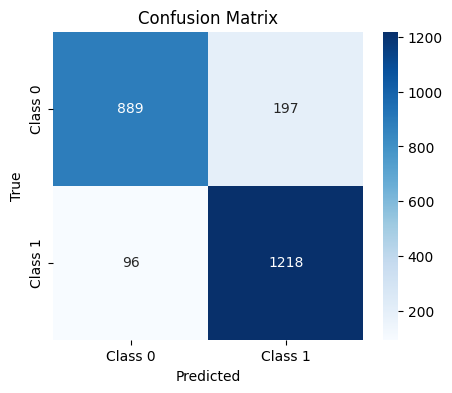

In [112]:
# Predict probabilities for the test set
y_pred_prob = nn_model.predict(X_test).ravel()
# Convert probabilities to binary predictions
y_pred = (y_pred_prob >= 0.5).astype(int)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0','Class 1'], 
            yticklabels=['Class 0','Class 1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


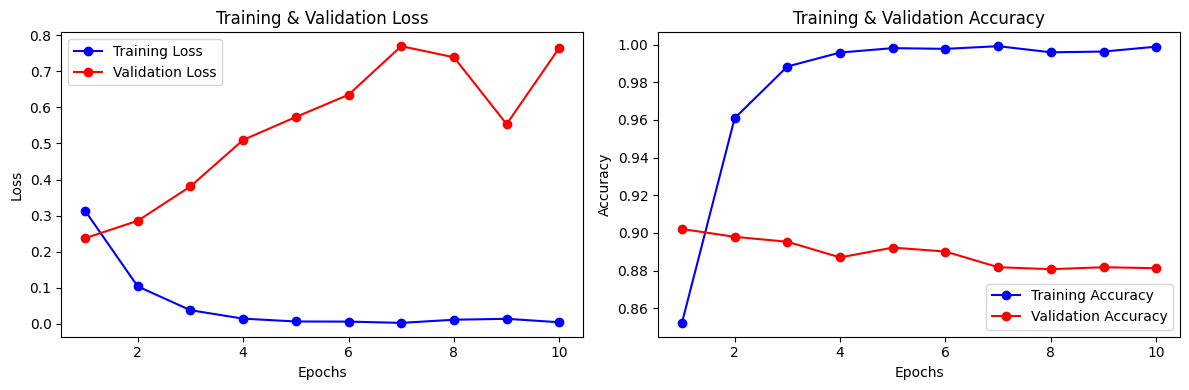

In [113]:
def plot_learning_curves(history):
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(12,4))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
    plt.title("Training & Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
    plt.title("Training & Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)


## 4. BERT Approach

We will leverage a **pre-trained BERT model** from Hugging Face. Steps include:
1. Splitting data into **train**, **validation**, and **test**.
2. Using BERT’s own **tokenizer**.
3. Creating a custom `Dataset` class to handle inputs.
4. Using a `Trainer` for fine-tuning the BERT model.
5. Evaluating with common classification metrics.


In [38]:
# 4.1 Example Data Splits for BERT


# First Split (Train+Validation vs Test)
X_train_val_bert, X_test_bert, y_train_val_bert, y_test_bert = train_test_split(
    original_list, anns, test_size=0.2, random_state=42
)

# Second Split (Train vs Validation)
X_train_bert, X_val_bert, y_train_bert, y_val_bert = train_test_split(
    X_train_val_bert, y_train_val_bert, test_size=0.1, random_state=42
)

print(
    f"Training size: {len(X_train_bert)}, "
    f"Validation size: {len(X_val_bert)}, "
    f"Test size: {len(X_test_bert)}"
)

# Convert labels to tensors
y_train_bert = torch.tensor(y_train_bert.values, dtype=torch.long)
y_val_bert = torch.tensor(y_val_bert.values, dtype=torch.long)
y_test_bert = torch.tensor(y_test_bert.values, dtype=torch.long) 


Training size: 8639, Validation size: 960, Test size: 2400


### 4.2 BERT Tokenization


We’ll use `BertTokenizer` from `bert-base-uncased`. BERT handles case and subwords automatically, so no additional preprocessing (like stopword removal, stemming, etc.) is needed.


Unlike traditional NLP pipelines, BERT's tokenizer requires no additional preprocessing:

You don’t need to remove stopwords because BERT can handle their contextual importance.
You don’t need to lemmatize or stem because subwords inherently capture morphological variations (e.g., "run" and "running").
Case sensitivity is handled if you're using the case-sensitive version of BERT.
This makes the process simpler and ensures that the model works with raw input text.

In [39]:
# 4.2 Tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

train_encodings = tokenize_texts(X_train_bert, tokenizer)
val_encodings   = tokenize_texts(X_val_bert,   tokenizer)
test_encodings  = tokenize_texts(X_test_bert,  tokenizer)


### 4.3 Dataset Class

We define a custom `Dataset` to properly return `input_ids`, `attention_mask`, and `labels` for each sample.


In [42]:
class CommentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids":      self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels":         self.labels[idx],
        }

train_dataset = CommentDataset(train_encodings, y_train_bert)
val_dataset   = CommentDataset(val_encodings,   y_val_bert)
test_dataset  = CommentDataset(test_encodings,  y_test_bert)


### 4.4 Load Pre-Trained BERT Model

We’ll load a `BertForSequenceClassification` from the `bert-base-uncased` checkpoint. By default, it expects `num_labels=2` for binary classification.



In [44]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels=2
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4.5 Define Training Arguments and Trainer

We'll train the model for a few epochs, specify batch sizes, and evaluate on our validation set every epoch. The Hugging Face `Trainer` handles many details automatically.


In [46]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,  # For demonstration
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

### 4.6 Train and Evaluate the BERT Model

In [47]:
# 4.6.1 Training
trainer.train()

# 4.6.2 Saving Model Weights
model.save_pretrained("./bert_model_weights")

# 4.6.3 Predictions on Test Set
predictions = trainer.predict(test_dataset)

# Extract predicted labels
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), axis=1)
accuracy = (predicted_labels == y_test_bert).sum().item() / len(y_test_bert)



  0%|          | 11/8640 [00:02<19:44,  7.29it/s] 

{'loss': 0.8209, 'grad_norm': 5.922604084014893, 'learning_rate': 5e-06, 'epoch': 0.0}


  0%|          | 21/8640 [00:04<17:53,  8.03it/s]

{'loss': 0.7004, 'grad_norm': 10.219289779663086, 'learning_rate': 1e-05, 'epoch': 0.0}


  0%|          | 31/8640 [00:05<18:26,  7.78it/s]

{'loss': 0.7135, 'grad_norm': 7.339498996734619, 'learning_rate': 1.5e-05, 'epoch': 0.01}


  0%|          | 41/8640 [00:06<17:53,  8.01it/s]

{'loss': 0.6644, 'grad_norm': 10.44131851196289, 'learning_rate': 2e-05, 'epoch': 0.01}


  1%|          | 51/8640 [00:07<18:02,  7.94it/s]

{'loss': 0.6356, 'grad_norm': 14.103372573852539, 'learning_rate': 2.5e-05, 'epoch': 0.01}


  1%|          | 61/8640 [00:09<17:50,  8.01it/s]

{'loss': 0.536, 'grad_norm': 7.878714084625244, 'learning_rate': 3e-05, 'epoch': 0.01}


  1%|          | 71/8640 [00:10<17:43,  8.06it/s]

{'loss': 0.6089, 'grad_norm': 14.006453514099121, 'learning_rate': 3.5e-05, 'epoch': 0.02}


  1%|          | 81/8640 [00:11<17:44,  8.04it/s]

{'loss': 0.3115, 'grad_norm': 5.276481628417969, 'learning_rate': 4e-05, 'epoch': 0.02}


  1%|          | 91/8640 [00:12<18:26,  7.73it/s]

{'loss': 0.4511, 'grad_norm': 9.800139427185059, 'learning_rate': 4.5e-05, 'epoch': 0.02}


  1%|          | 101/8640 [00:14<17:49,  7.98it/s]

{'loss': 0.2357, 'grad_norm': 1.2820241451263428, 'learning_rate': 5e-05, 'epoch': 0.02}


  1%|▏         | 111/8640 [00:15<17:40,  8.04it/s]

{'loss': 0.3055, 'grad_norm': 18.1834716796875, 'learning_rate': 4.994145199063232e-05, 'epoch': 0.03}


  1%|▏         | 121/8640 [00:16<17:47,  7.98it/s]

{'loss': 0.4339, 'grad_norm': 2.044966220855713, 'learning_rate': 4.988290398126464e-05, 'epoch': 0.03}


  2%|▏         | 131/8640 [00:17<18:14,  7.78it/s]

{'loss': 0.4873, 'grad_norm': 0.9763907790184021, 'learning_rate': 4.9824355971896954e-05, 'epoch': 0.03}


  2%|▏         | 141/8640 [00:19<17:33,  8.07it/s]

{'loss': 0.4956, 'grad_norm': 0.25253528356552124, 'learning_rate': 4.9765807962529274e-05, 'epoch': 0.03}


  2%|▏         | 151/8640 [00:20<17:26,  8.12it/s]

{'loss': 0.0044, 'grad_norm': 2.367037534713745, 'learning_rate': 4.9707259953161594e-05, 'epoch': 0.03}


  2%|▏         | 161/8640 [00:21<17:23,  8.13it/s]

{'loss': 0.4759, 'grad_norm': 0.03963809460401535, 'learning_rate': 4.964871194379391e-05, 'epoch': 0.04}


  2%|▏         | 171/8640 [00:22<17:28,  8.08it/s]

{'loss': 0.5621, 'grad_norm': 0.9132340550422668, 'learning_rate': 4.959016393442623e-05, 'epoch': 0.04}


  2%|▏         | 181/8640 [00:24<17:32,  8.04it/s]

{'loss': 1.1879, 'grad_norm': 0.077153779566288, 'learning_rate': 4.953161592505855e-05, 'epoch': 0.04}


  2%|▏         | 191/8640 [00:25<17:32,  8.03it/s]

{'loss': 1.0802, 'grad_norm': 0.17153963446617126, 'learning_rate': 4.9473067915690865e-05, 'epoch': 0.04}


  2%|▏         | 201/8640 [00:26<18:58,  7.41it/s]

{'loss': 0.4938, 'grad_norm': 25.026721954345703, 'learning_rate': 4.9414519906323185e-05, 'epoch': 0.05}


  2%|▏         | 211/8640 [00:27<17:50,  7.87it/s]

{'loss': 0.0047, 'grad_norm': 0.36868125200271606, 'learning_rate': 4.9355971896955504e-05, 'epoch': 0.05}


  3%|▎         | 221/8640 [00:29<19:01,  7.37it/s]

{'loss': 0.3336, 'grad_norm': 0.04578004777431488, 'learning_rate': 4.9297423887587824e-05, 'epoch': 0.05}


  3%|▎         | 231/8640 [00:30<17:25,  8.04it/s]

{'loss': 0.7533, 'grad_norm': 1.7741408348083496, 'learning_rate': 4.9238875878220143e-05, 'epoch': 0.05}


  3%|▎         | 241/8640 [00:31<17:23,  8.05it/s]

{'loss': 0.5322, 'grad_norm': 0.10515990853309631, 'learning_rate': 4.918032786885246e-05, 'epoch': 0.06}


  3%|▎         | 251/8640 [00:32<17:30,  7.98it/s]

{'loss': 0.6225, 'grad_norm': 0.11455493420362473, 'learning_rate': 4.9121779859484776e-05, 'epoch': 0.06}


  3%|▎         | 261/8640 [00:34<17:55,  7.79it/s]

{'loss': 0.7827, 'grad_norm': 0.1603853851556778, 'learning_rate': 4.9063231850117095e-05, 'epoch': 0.06}


  3%|▎         | 271/8640 [00:35<17:33,  7.95it/s]

{'loss': 0.8938, 'grad_norm': 0.3260851204395294, 'learning_rate': 4.9004683840749415e-05, 'epoch': 0.06}


  3%|▎         | 281/8640 [00:36<17:53,  7.79it/s]

{'loss': 0.0071, 'grad_norm': 0.25301891565322876, 'learning_rate': 4.8946135831381735e-05, 'epoch': 0.06}


  3%|▎         | 291/8640 [00:38<18:16,  7.62it/s]

{'loss': 0.25, 'grad_norm': 0.11723988503217697, 'learning_rate': 4.8887587822014054e-05, 'epoch': 0.07}


  3%|▎         | 301/8640 [00:39<17:30,  7.94it/s]

{'loss': 0.6416, 'grad_norm': 0.324407696723938, 'learning_rate': 4.8829039812646374e-05, 'epoch': 0.07}


  4%|▎         | 311/8640 [00:40<17:55,  7.75it/s]

{'loss': 0.0034, 'grad_norm': 0.020734818652272224, 'learning_rate': 4.8770491803278687e-05, 'epoch': 0.07}


  4%|▎         | 321/8640 [00:42<17:30,  7.92it/s]

{'loss': 0.8984, 'grad_norm': 0.5092595815658569, 'learning_rate': 4.8711943793911006e-05, 'epoch': 0.07}


  4%|▍         | 331/8640 [00:43<18:31,  7.47it/s]

{'loss': 0.7005, 'grad_norm': 0.1279221475124359, 'learning_rate': 4.8653395784543326e-05, 'epoch': 0.08}


  4%|▍         | 341/8640 [00:44<17:17,  8.00it/s]

{'loss': 0.6227, 'grad_norm': 0.16869769990444183, 'learning_rate': 4.8594847775175645e-05, 'epoch': 0.08}


  4%|▍         | 351/8640 [00:45<17:14,  8.01it/s]

{'loss': 1.0706, 'grad_norm': 26.63382339477539, 'learning_rate': 4.8536299765807965e-05, 'epoch': 0.08}


  4%|▍         | 361/8640 [00:47<17:17,  7.98it/s]

{'loss': 0.2817, 'grad_norm': 0.13501989841461182, 'learning_rate': 4.8477751756440285e-05, 'epoch': 0.08}


  4%|▍         | 371/8640 [00:48<18:35,  7.41it/s]

{'loss': 0.1526, 'grad_norm': 19.405967712402344, 'learning_rate': 4.84192037470726e-05, 'epoch': 0.09}


  4%|▍         | 381/8640 [00:49<17:52,  7.70it/s]

{'loss': 0.8274, 'grad_norm': 17.199941635131836, 'learning_rate': 4.836065573770492e-05, 'epoch': 0.09}


  5%|▍         | 391/8640 [00:50<17:19,  7.94it/s]

{'loss': 1.021, 'grad_norm': 20.070301055908203, 'learning_rate': 4.8302107728337236e-05, 'epoch': 0.09}


  5%|▍         | 401/8640 [00:52<17:17,  7.94it/s]

{'loss': 0.26, 'grad_norm': 0.11567848920822144, 'learning_rate': 4.8243559718969556e-05, 'epoch': 0.09}


  5%|▍         | 411/8640 [00:53<18:12,  7.54it/s]

{'loss': 0.0066, 'grad_norm': 0.1340014636516571, 'learning_rate': 4.8185011709601876e-05, 'epoch': 0.09}


  5%|▍         | 421/8640 [00:54<17:08,  7.99it/s]

{'loss': 1.1499, 'grad_norm': 18.471317291259766, 'learning_rate': 4.8126463700234195e-05, 'epoch': 0.1}


  5%|▍         | 431/8640 [00:56<16:56,  8.07it/s]

{'loss': 0.2491, 'grad_norm': 0.16197924315929413, 'learning_rate': 4.806791569086651e-05, 'epoch': 0.1}


  5%|▌         | 441/8640 [00:57<17:47,  7.68it/s]

{'loss': 0.3086, 'grad_norm': 0.21398654580116272, 'learning_rate': 4.800936768149883e-05, 'epoch': 0.1}


  5%|▌         | 451/8640 [00:58<17:00,  8.02it/s]

{'loss': 1.3231, 'grad_norm': 18.05519676208496, 'learning_rate': 4.795081967213115e-05, 'epoch': 0.1}


  5%|▌         | 461/8640 [00:59<16:54,  8.06it/s]

{'loss': 0.731, 'grad_norm': 0.2845824658870697, 'learning_rate': 4.789227166276347e-05, 'epoch': 0.11}


  5%|▌         | 471/8640 [01:01<16:55,  8.04it/s]

{'loss': 0.2374, 'grad_norm': 0.09945620596408844, 'learning_rate': 4.7833723653395786e-05, 'epoch': 0.11}


  6%|▌         | 481/8640 [01:02<16:55,  8.03it/s]

{'loss': 0.4524, 'grad_norm': 0.7023899555206299, 'learning_rate': 4.7775175644028106e-05, 'epoch': 0.11}


  6%|▌         | 491/8640 [01:03<16:45,  8.10it/s]

{'loss': 0.0776, 'grad_norm': 0.13373933732509613, 'learning_rate': 4.771662763466042e-05, 'epoch': 0.11}


  6%|▌         | 501/8640 [01:04<16:52,  8.04it/s]

{'loss': 0.8354, 'grad_norm': 0.10633284598588943, 'learning_rate': 4.765807962529274e-05, 'epoch': 0.12}


  6%|▌         | 511/8640 [01:06<16:55,  8.01it/s]

{'loss': 0.8076, 'grad_norm': 0.2420186847448349, 'learning_rate': 4.759953161592506e-05, 'epoch': 0.12}


  6%|▌         | 521/8640 [01:07<16:44,  8.08it/s]

{'loss': 0.4425, 'grad_norm': 0.7342227101325989, 'learning_rate': 4.754098360655738e-05, 'epoch': 0.12}


  6%|▌         | 531/8640 [01:08<16:56,  7.98it/s]

{'loss': 0.4324, 'grad_norm': 0.3534604012966156, 'learning_rate': 4.7482435597189704e-05, 'epoch': 0.12}


  6%|▋         | 541/8640 [01:09<16:55,  7.98it/s]

{'loss': 0.2317, 'grad_norm': 0.29381266236305237, 'learning_rate': 4.742388758782202e-05, 'epoch': 0.12}


  6%|▋         | 551/8640 [01:10<16:43,  8.06it/s]

{'loss': 0.5075, 'grad_norm': 17.2853946685791, 'learning_rate': 4.7365339578454336e-05, 'epoch': 0.13}


  6%|▋         | 561/8640 [01:12<16:41,  8.07it/s]

{'loss': 0.3994, 'grad_norm': 0.14611217379570007, 'learning_rate': 4.7306791569086656e-05, 'epoch': 0.13}


  7%|▋         | 571/8640 [01:13<17:14,  7.80it/s]

{'loss': 0.2243, 'grad_norm': 0.09258842468261719, 'learning_rate': 4.7248243559718975e-05, 'epoch': 0.13}


  7%|▋         | 581/8640 [01:14<16:40,  8.05it/s]

{'loss': 0.8342, 'grad_norm': 0.6416609287261963, 'learning_rate': 4.7189695550351295e-05, 'epoch': 0.13}


  7%|▋         | 591/8640 [01:15<16:40,  8.04it/s]

{'loss': 0.3783, 'grad_norm': 16.244640350341797, 'learning_rate': 4.713114754098361e-05, 'epoch': 0.14}


  7%|▋         | 601/8640 [01:17<16:40,  8.03it/s]

{'loss': 0.4388, 'grad_norm': 0.05346927419304848, 'learning_rate': 4.707259953161593e-05, 'epoch': 0.14}


  7%|▋         | 611/8640 [01:18<16:35,  8.07it/s]

{'loss': 0.6131, 'grad_norm': 5.2894673347473145, 'learning_rate': 4.701405152224825e-05, 'epoch': 0.14}


  7%|▋         | 621/8640 [01:19<17:21,  7.70it/s]

{'loss': 0.0164, 'grad_norm': 6.8181023597717285, 'learning_rate': 4.695550351288057e-05, 'epoch': 0.14}


  7%|▋         | 631/8640 [01:20<16:39,  8.01it/s]

{'loss': 0.5345, 'grad_norm': 17.701906204223633, 'learning_rate': 4.6896955503512886e-05, 'epoch': 0.15}


  7%|▋         | 641/8640 [01:22<16:26,  8.11it/s]

{'loss': 0.5764, 'grad_norm': 19.531824111938477, 'learning_rate': 4.6838407494145206e-05, 'epoch': 0.15}


  8%|▊         | 651/8640 [01:23<16:39,  7.99it/s]

{'loss': 0.4848, 'grad_norm': 0.04976975545287132, 'learning_rate': 4.677985948477752e-05, 'epoch': 0.15}


  8%|▊         | 661/8640 [01:24<16:30,  8.06it/s]

{'loss': 0.4867, 'grad_norm': 0.14406193792819977, 'learning_rate': 4.672131147540984e-05, 'epoch': 0.15}


  8%|▊         | 671/8640 [01:25<16:57,  7.83it/s]

{'loss': 0.0052, 'grad_norm': 0.15379932522773743, 'learning_rate': 4.666276346604216e-05, 'epoch': 0.16}


  8%|▊         | 681/8640 [01:27<16:28,  8.06it/s]

{'loss': 0.5165, 'grad_norm': 0.036431968212127686, 'learning_rate': 4.660421545667448e-05, 'epoch': 0.16}


  8%|▊         | 691/8640 [01:28<16:41,  7.93it/s]

{'loss': 1.0726, 'grad_norm': 0.15483158826828003, 'learning_rate': 4.65456674473068e-05, 'epoch': 0.16}


  8%|▊         | 701/8640 [01:29<16:23,  8.07it/s]

{'loss': 0.1906, 'grad_norm': 0.18326611816883087, 'learning_rate': 4.6487119437939117e-05, 'epoch': 0.16}


  8%|▊         | 711/8640 [01:31<17:51,  7.40it/s]

{'loss': 0.2889, 'grad_norm': 0.0957292690873146, 'learning_rate': 4.642857142857143e-05, 'epoch': 0.16}


  8%|▊         | 721/8640 [01:32<17:58,  7.34it/s]

{'loss': 0.8307, 'grad_norm': 34.052703857421875, 'learning_rate': 4.637002341920375e-05, 'epoch': 0.17}


  8%|▊         | 731/8640 [01:33<16:26,  8.02it/s]

{'loss': 0.7846, 'grad_norm': 28.478515625, 'learning_rate': 4.631147540983607e-05, 'epoch': 0.17}


  9%|▊         | 741/8640 [01:34<16:44,  7.86it/s]

{'loss': 0.536, 'grad_norm': 0.6779509782791138, 'learning_rate': 4.625292740046839e-05, 'epoch': 0.17}


  9%|▊         | 751/8640 [01:36<16:18,  8.07it/s]

{'loss': 1.0021, 'grad_norm': 0.48744165897369385, 'learning_rate': 4.619437939110071e-05, 'epoch': 0.17}


  9%|▉         | 761/8640 [01:37<16:33,  7.93it/s]

{'loss': 0.0903, 'grad_norm': 0.26360413432121277, 'learning_rate': 4.613583138173303e-05, 'epoch': 0.18}


  9%|▉         | 771/8640 [01:38<16:33,  7.92it/s]

{'loss': 0.5207, 'grad_norm': 0.28923726081848145, 'learning_rate': 4.607728337236534e-05, 'epoch': 0.18}


  9%|▉         | 781/8640 [01:39<16:20,  8.01it/s]

{'loss': 0.6198, 'grad_norm': 0.1416422724723816, 'learning_rate': 4.601873536299766e-05, 'epoch': 0.18}


  9%|▉         | 791/8640 [01:41<16:17,  8.03it/s]

{'loss': 0.3196, 'grad_norm': 246.74221801757812, 'learning_rate': 4.596018735362998e-05, 'epoch': 0.18}


  9%|▉         | 801/8640 [01:42<16:39,  7.84it/s]

{'loss': 0.0037, 'grad_norm': 0.10648836195468903, 'learning_rate': 4.59016393442623e-05, 'epoch': 0.19}


  9%|▉         | 811/8640 [01:43<16:14,  8.04it/s]

{'loss': 0.0028, 'grad_norm': 0.06947363168001175, 'learning_rate': 4.584309133489462e-05, 'epoch': 0.19}


 10%|▉         | 821/8640 [01:44<16:15,  8.02it/s]

{'loss': 0.0019, 'grad_norm': 0.05268099904060364, 'learning_rate': 4.578454332552694e-05, 'epoch': 0.19}


 10%|▉         | 831/8640 [01:46<16:12,  8.03it/s]

{'loss': 0.0012, 'grad_norm': 0.04068674519658089, 'learning_rate': 4.572599531615925e-05, 'epoch': 0.19}


 10%|▉         | 841/8640 [01:47<16:08,  8.05it/s]

{'loss': 1.0096, 'grad_norm': 36.45368576049805, 'learning_rate': 4.566744730679157e-05, 'epoch': 0.19}


 10%|▉         | 851/8640 [01:48<16:06,  8.06it/s]

{'loss': 0.2077, 'grad_norm': 0.04196612536907196, 'learning_rate': 4.560889929742389e-05, 'epoch': 0.2}


 10%|▉         | 861/8640 [01:49<16:05,  8.05it/s]

{'loss': 1.1126, 'grad_norm': 108.674560546875, 'learning_rate': 4.555035128805621e-05, 'epoch': 0.2}


 10%|█         | 871/8640 [01:51<16:07,  8.03it/s]

{'loss': 0.0044, 'grad_norm': 0.07220375537872314, 'learning_rate': 4.549180327868853e-05, 'epoch': 0.2}


 10%|█         | 881/8640 [01:52<16:01,  8.07it/s]

{'loss': 0.3121, 'grad_norm': 0.054080795496702194, 'learning_rate': 4.543325526932085e-05, 'epoch': 0.2}


 10%|█         | 891/8640 [01:53<17:13,  7.50it/s]

{'loss': 0.223, 'grad_norm': 0.3521230220794678, 'learning_rate': 4.537470725995316e-05, 'epoch': 0.21}


 10%|█         | 901/8640 [01:54<16:08,  7.99it/s]

{'loss': 0.0028, 'grad_norm': 0.03605093061923981, 'learning_rate': 4.531615925058548e-05, 'epoch': 0.21}


 11%|█         | 911/8640 [01:56<15:59,  8.05it/s]

{'loss': 0.5207, 'grad_norm': 0.04523022845387459, 'learning_rate': 4.52576112412178e-05, 'epoch': 0.21}


 11%|█         | 921/8640 [01:57<16:14,  7.92it/s]

{'loss': 0.0013, 'grad_norm': 0.03788874298334122, 'learning_rate': 4.519906323185012e-05, 'epoch': 0.21}


 11%|█         | 931/8640 [01:58<16:06,  7.97it/s]

{'loss': 0.5223, 'grad_norm': 0.035676002502441406, 'learning_rate': 4.514051522248244e-05, 'epoch': 0.22}


 11%|█         | 941/8640 [01:59<15:59,  8.03it/s]

{'loss': 0.8587, 'grad_norm': 0.06344496458768845, 'learning_rate': 4.508196721311476e-05, 'epoch': 0.22}


 11%|█         | 951/8640 [02:01<15:57,  8.03it/s]

{'loss': 0.184, 'grad_norm': 0.09469418227672577, 'learning_rate': 4.502341920374707e-05, 'epoch': 0.22}


 11%|█         | 961/8640 [02:02<16:08,  7.93it/s]

{'loss': 0.5083, 'grad_norm': 0.09029741585254669, 'learning_rate': 4.496487119437939e-05, 'epoch': 0.22}


 11%|█         | 971/8640 [02:03<15:53,  8.04it/s]

{'loss': 0.0028, 'grad_norm': 0.10438774526119232, 'learning_rate': 4.490632318501171e-05, 'epoch': 0.22}


 11%|█▏        | 981/8640 [02:04<15:54,  8.02it/s]

{'loss': 0.0166, 'grad_norm': 37.636932373046875, 'learning_rate': 4.484777517564403e-05, 'epoch': 0.23}


 11%|█▏        | 991/8640 [02:06<15:49,  8.06it/s]

{'loss': 0.297, 'grad_norm': 0.0455864779651165, 'learning_rate': 4.478922716627635e-05, 'epoch': 0.23}


 12%|█▏        | 1001/8640 [02:07<16:33,  7.69it/s]

{'loss': 0.0331, 'grad_norm': 0.03887045383453369, 'learning_rate': 4.473067915690867e-05, 'epoch': 0.23}


 12%|█▏        | 1011/8640 [02:08<15:53,  8.00it/s]

{'loss': 0.9736, 'grad_norm': 34.7828254699707, 'learning_rate': 4.467213114754098e-05, 'epoch': 0.23}


 12%|█▏        | 1021/8640 [02:09<15:43,  8.07it/s]

{'loss': 0.2774, 'grad_norm': 0.08032521605491638, 'learning_rate': 4.46135831381733e-05, 'epoch': 0.24}


 12%|█▏        | 1031/8640 [02:11<15:42,  8.08it/s]

{'loss': 0.3172, 'grad_norm': 0.0419609397649765, 'learning_rate': 4.455503512880562e-05, 'epoch': 0.24}


 12%|█▏        | 1041/8640 [02:12<15:43,  8.05it/s]

{'loss': 0.0019, 'grad_norm': 0.02895907498896122, 'learning_rate': 4.449648711943794e-05, 'epoch': 0.24}


 12%|█▏        | 1051/8640 [02:13<15:47,  8.01it/s]

{'loss': 0.0028, 'grad_norm': 0.03835536912083626, 'learning_rate': 4.443793911007026e-05, 'epoch': 0.24}


 12%|█▏        | 1061/8640 [02:14<15:42,  8.04it/s]

{'loss': 0.6012, 'grad_norm': 0.043451983481645584, 'learning_rate': 4.4379391100702574e-05, 'epoch': 0.25}


 12%|█▏        | 1071/8640 [02:16<15:33,  8.11it/s]

{'loss': 0.2144, 'grad_norm': 0.044201068580150604, 'learning_rate': 4.4320843091334894e-05, 'epoch': 0.25}


 13%|█▎        | 1081/8640 [02:17<15:36,  8.07it/s]

{'loss': 0.3286, 'grad_norm': 0.10426118969917297, 'learning_rate': 4.426229508196721e-05, 'epoch': 0.25}


 13%|█▎        | 1091/8640 [02:18<15:33,  8.09it/s]

{'loss': 0.5426, 'grad_norm': 0.1639276146888733, 'learning_rate': 4.420374707259953e-05, 'epoch': 0.25}


 13%|█▎        | 1101/8640 [02:19<15:30,  8.10it/s]

{'loss': 0.008, 'grad_norm': 0.2793634235858917, 'learning_rate': 4.414519906323185e-05, 'epoch': 0.25}


 13%|█▎        | 1111/8640 [02:21<15:26,  8.12it/s]

{'loss': 0.545, 'grad_norm': 27.960844039916992, 'learning_rate': 4.408665105386417e-05, 'epoch': 0.26}


 13%|█▎        | 1121/8640 [02:22<15:28,  8.10it/s]

{'loss': 0.7337, 'grad_norm': 0.2477344572544098, 'learning_rate': 4.4028103044496485e-05, 'epoch': 0.26}


 13%|█▎        | 1131/8640 [02:23<15:32,  8.05it/s]

{'loss': 0.5013, 'grad_norm': 0.05989384278655052, 'learning_rate': 4.3969555035128804e-05, 'epoch': 0.26}


 13%|█▎        | 1141/8640 [02:24<15:25,  8.11it/s]

{'loss': 0.7054, 'grad_norm': 0.08235235512256622, 'learning_rate': 4.3911007025761124e-05, 'epoch': 0.26}


 13%|█▎        | 1151/8640 [02:26<15:23,  8.11it/s]

{'loss': 0.0263, 'grad_norm': 0.11085700988769531, 'learning_rate': 4.3852459016393444e-05, 'epoch': 0.27}


 13%|█▎        | 1161/8640 [02:27<15:27,  8.07it/s]

{'loss': 0.2233, 'grad_norm': 15.478111267089844, 'learning_rate': 4.379391100702576e-05, 'epoch': 0.27}


 14%|█▎        | 1171/8640 [02:28<15:20,  8.12it/s]

{'loss': 0.3467, 'grad_norm': 0.08844422549009323, 'learning_rate': 4.373536299765808e-05, 'epoch': 0.27}


 14%|█▎        | 1181/8640 [02:29<15:31,  8.00it/s]

{'loss': 0.7843, 'grad_norm': 18.527057647705078, 'learning_rate': 4.3676814988290396e-05, 'epoch': 0.27}


 14%|█▍        | 1191/8640 [02:31<16:59,  7.31it/s]

{'loss': 0.6951, 'grad_norm': 0.11457215249538422, 'learning_rate': 4.3618266978922715e-05, 'epoch': 0.28}


 14%|█▍        | 1201/8640 [02:32<15:25,  8.04it/s]

{'loss': 0.2164, 'grad_norm': 16.573020935058594, 'learning_rate': 4.3559718969555035e-05, 'epoch': 0.28}


 14%|█▍        | 1211/8640 [02:33<15:20,  8.07it/s]

{'loss': 0.8601, 'grad_norm': 0.22821439802646637, 'learning_rate': 4.3501170960187354e-05, 'epoch': 0.28}


 14%|█▍        | 1221/8640 [02:34<15:25,  8.02it/s]

{'loss': 0.4164, 'grad_norm': 0.15140098333358765, 'learning_rate': 4.3442622950819674e-05, 'epoch': 0.28}


 14%|█▍        | 1231/8640 [02:36<15:18,  8.06it/s]

{'loss': 0.1784, 'grad_norm': 13.418147087097168, 'learning_rate': 4.3384074941451994e-05, 'epoch': 0.28}


 14%|█▍        | 1241/8640 [02:37<16:17,  7.57it/s]

{'loss': 0.1937, 'grad_norm': 0.8457446098327637, 'learning_rate': 4.3325526932084306e-05, 'epoch': 0.29}


 14%|█▍        | 1251/8640 [02:38<15:27,  7.97it/s]

{'loss': 0.6144, 'grad_norm': 0.13295526802539825, 'learning_rate': 4.3266978922716626e-05, 'epoch': 0.29}


 15%|█▍        | 1261/8640 [02:39<15:35,  7.89it/s]

{'loss': 0.7042, 'grad_norm': 88.4481430053711, 'learning_rate': 4.3208430913348946e-05, 'epoch': 0.29}


 15%|█▍        | 1271/8640 [02:41<15:20,  8.00it/s]

{'loss': 0.2793, 'grad_norm': 0.16994312405586243, 'learning_rate': 4.3149882903981265e-05, 'epoch': 0.29}


 15%|█▍        | 1281/8640 [02:42<15:53,  7.72it/s]

{'loss': 0.0121, 'grad_norm': 1.1911994218826294, 'learning_rate': 4.3091334894613585e-05, 'epoch': 0.3}


 15%|█▍        | 1291/8640 [02:43<16:42,  7.33it/s]

{'loss': 0.4229, 'grad_norm': 0.04694357141852379, 'learning_rate': 4.3032786885245904e-05, 'epoch': 0.3}


 15%|█▌        | 1301/8640 [02:45<15:38,  7.82it/s]

{'loss': 0.3029, 'grad_norm': 0.15803320705890656, 'learning_rate': 4.297423887587822e-05, 'epoch': 0.3}


 15%|█▌        | 1311/8640 [02:46<16:54,  7.22it/s]

{'loss': 0.6299, 'grad_norm': 0.10273805260658264, 'learning_rate': 4.291569086651054e-05, 'epoch': 0.3}


 15%|█▌        | 1321/8640 [02:47<15:58,  7.63it/s]

{'loss': 0.2825, 'grad_norm': 0.12598949670791626, 'learning_rate': 4.2857142857142856e-05, 'epoch': 0.31}


 15%|█▌        | 1331/8640 [02:49<15:11,  8.02it/s]

{'loss': 0.2958, 'grad_norm': 0.11545161157846451, 'learning_rate': 4.2798594847775176e-05, 'epoch': 0.31}


 16%|█▌        | 1341/8640 [02:50<15:09,  8.02it/s]

{'loss': 1.07, 'grad_norm': 17.84596061706543, 'learning_rate': 4.2740046838407495e-05, 'epoch': 0.31}


 16%|█▌        | 1351/8640 [02:51<15:15,  7.96it/s]

{'loss': 0.4173, 'grad_norm': 0.25303563475608826, 'learning_rate': 4.2681498829039815e-05, 'epoch': 0.31}


 16%|█▌        | 1361/8640 [02:53<15:51,  7.65it/s]

{'loss': 0.0099, 'grad_norm': 0.20018745958805084, 'learning_rate': 4.262295081967213e-05, 'epoch': 0.31}


 16%|█▌        | 1371/8640 [02:54<17:35,  6.89it/s]

{'loss': 0.5629, 'grad_norm': 0.1259099692106247, 'learning_rate': 4.256440281030445e-05, 'epoch': 0.32}


 16%|█▌        | 1381/8640 [02:55<15:59,  7.57it/s]

{'loss': 0.0036, 'grad_norm': 0.08987167477607727, 'learning_rate': 4.250585480093677e-05, 'epoch': 0.32}


 16%|█▌        | 1391/8640 [02:57<15:39,  7.72it/s]

{'loss': 0.2756, 'grad_norm': 0.09119068831205368, 'learning_rate': 4.2447306791569093e-05, 'epoch': 0.32}


 16%|█▌        | 1401/8640 [02:58<15:03,  8.01it/s]

{'loss': 0.2895, 'grad_norm': 1.1928651332855225, 'learning_rate': 4.238875878220141e-05, 'epoch': 0.32}


 16%|█▋        | 1411/8640 [02:59<15:01,  8.02it/s]

{'loss': 0.2567, 'grad_norm': 0.048023343086242676, 'learning_rate': 4.2330210772833726e-05, 'epoch': 0.33}


 16%|█▋        | 1421/8640 [03:00<14:57,  8.04it/s]

{'loss': 0.9472, 'grad_norm': 0.06883497536182404, 'learning_rate': 4.2271662763466045e-05, 'epoch': 0.33}


 17%|█▋        | 1431/8640 [03:02<15:01,  7.99it/s]

{'loss': 0.8387, 'grad_norm': 0.21305498480796814, 'learning_rate': 4.2213114754098365e-05, 'epoch': 0.33}


 17%|█▋        | 1441/8640 [03:03<14:53,  8.05it/s]

{'loss': 0.0051, 'grad_norm': 0.19338244199752808, 'learning_rate': 4.2154566744730685e-05, 'epoch': 0.33}


 17%|█▋        | 1451/8640 [03:04<14:52,  8.06it/s]

{'loss': 0.6461, 'grad_norm': 75.59428405761719, 'learning_rate': 4.2096018735363004e-05, 'epoch': 0.34}


 17%|█▋        | 1461/8640 [03:05<14:51,  8.05it/s]

{'loss': 1.1525, 'grad_norm': 0.22372305393218994, 'learning_rate': 4.2037470725995324e-05, 'epoch': 0.34}


 17%|█▋        | 1471/8640 [03:07<14:51,  8.04it/s]

{'loss': 0.7025, 'grad_norm': 0.24114783108234406, 'learning_rate': 4.1978922716627637e-05, 'epoch': 0.34}


 17%|█▋        | 1481/8640 [03:08<14:49,  8.05it/s]

{'loss': 0.3495, 'grad_norm': 0.21649619936943054, 'learning_rate': 4.1920374707259956e-05, 'epoch': 0.34}


 17%|█▋        | 1491/8640 [03:09<14:48,  8.04it/s]

{'loss': 0.0307, 'grad_norm': 0.17261525988578796, 'learning_rate': 4.1861826697892276e-05, 'epoch': 0.34}


 17%|█▋        | 1501/8640 [03:10<14:42,  8.09it/s]

{'loss': 0.3411, 'grad_norm': 0.14926362037658691, 'learning_rate': 4.1803278688524595e-05, 'epoch': 0.35}


 17%|█▋        | 1511/8640 [03:12<14:42,  8.08it/s]

{'loss': 0.0267, 'grad_norm': 0.07395398616790771, 'learning_rate': 4.1744730679156915e-05, 'epoch': 0.35}


 18%|█▊        | 1521/8640 [03:13<14:41,  8.08it/s]

{'loss': 0.687, 'grad_norm': 48.53340530395508, 'learning_rate': 4.168618266978923e-05, 'epoch': 0.35}


 18%|█▊        | 1531/8640 [03:14<15:27,  7.67it/s]

{'loss': 0.6398, 'grad_norm': 0.1221826896071434, 'learning_rate': 4.162763466042155e-05, 'epoch': 0.35}


 18%|█▊        | 1541/8640 [03:15<14:38,  8.08it/s]

{'loss': 0.6477, 'grad_norm': 9.569896697998047, 'learning_rate': 4.156908665105387e-05, 'epoch': 0.36}


 18%|█▊        | 1551/8640 [03:17<14:36,  8.09it/s]

{'loss': 1.0669, 'grad_norm': 18.531356811523438, 'learning_rate': 4.1510538641686186e-05, 'epoch': 0.36}


 18%|█▊        | 1561/8640 [03:18<14:35,  8.08it/s]

{'loss': 0.0487, 'grad_norm': 0.6084902286529541, 'learning_rate': 4.1451990632318506e-05, 'epoch': 0.36}


 18%|█▊        | 1571/8640 [03:19<14:34,  8.08it/s]

{'loss': 0.923, 'grad_norm': 0.1082022488117218, 'learning_rate': 4.1393442622950826e-05, 'epoch': 0.36}


 18%|█▊        | 1581/8640 [03:20<14:31,  8.10it/s]

{'loss': 0.0293, 'grad_norm': 0.1634252816438675, 'learning_rate': 4.133489461358314e-05, 'epoch': 0.37}


 18%|█▊        | 1591/8640 [03:22<14:30,  8.10it/s]

{'loss': 0.3548, 'grad_norm': 0.15011651813983917, 'learning_rate': 4.127634660421546e-05, 'epoch': 0.37}


 19%|█▊        | 1601/8640 [03:23<14:29,  8.10it/s]

{'loss': 0.5548, 'grad_norm': 18.004179000854492, 'learning_rate': 4.121779859484778e-05, 'epoch': 0.37}


 19%|█▊        | 1611/8640 [03:24<14:28,  8.09it/s]

{'loss': 1.3382, 'grad_norm': 0.2229005992412567, 'learning_rate': 4.11592505854801e-05, 'epoch': 0.37}


 19%|█▉        | 1621/8640 [03:25<14:27,  8.10it/s]

{'loss': 0.2548, 'grad_norm': 0.820294976234436, 'learning_rate': 4.110070257611242e-05, 'epoch': 0.38}


 19%|█▉        | 1631/8640 [03:27<14:29,  8.06it/s]

{'loss': 0.232, 'grad_norm': 1.2106623649597168, 'learning_rate': 4.1042154566744736e-05, 'epoch': 0.38}


 19%|█▉        | 1641/8640 [03:28<14:23,  8.10it/s]

{'loss': 0.314, 'grad_norm': 21.93602180480957, 'learning_rate': 4.098360655737705e-05, 'epoch': 0.38}


 19%|█▉        | 1651/8640 [03:29<14:25,  8.07it/s]

{'loss': 0.2814, 'grad_norm': 0.048900555819272995, 'learning_rate': 4.092505854800937e-05, 'epoch': 0.38}


 19%|█▉        | 1661/8640 [03:30<14:23,  8.08it/s]

{'loss': 0.6177, 'grad_norm': 0.03555990010499954, 'learning_rate': 4.086651053864169e-05, 'epoch': 0.38}


 19%|█▉        | 1671/8640 [03:32<14:21,  8.09it/s]

{'loss': 0.5141, 'grad_norm': 0.18574464321136475, 'learning_rate': 4.080796252927401e-05, 'epoch': 0.39}


 19%|█▉        | 1681/8640 [03:33<14:21,  8.08it/s]

{'loss': 0.2375, 'grad_norm': 0.13462430238723755, 'learning_rate': 4.074941451990633e-05, 'epoch': 0.39}


 20%|█▉        | 1691/8640 [03:34<14:37,  7.92it/s]

{'loss': 0.0043, 'grad_norm': 0.10101889073848724, 'learning_rate': 4.069086651053865e-05, 'epoch': 0.39}


 20%|█▉        | 1701/8640 [03:35<14:20,  8.06it/s]

{'loss': 0.3068, 'grad_norm': 0.09111610800027847, 'learning_rate': 4.063231850117096e-05, 'epoch': 0.39}


 20%|█▉        | 1711/8640 [03:37<14:18,  8.07it/s]

{'loss': 1.1518, 'grad_norm': 0.09233419597148895, 'learning_rate': 4.057377049180328e-05, 'epoch': 0.4}


 20%|█▉        | 1721/8640 [03:38<14:14,  8.10it/s]

{'loss': 0.0029, 'grad_norm': 0.09853464365005493, 'learning_rate': 4.05152224824356e-05, 'epoch': 0.4}


 20%|██        | 1731/8640 [03:39<14:14,  8.08it/s]

{'loss': 0.7339, 'grad_norm': 0.0990399718284607, 'learning_rate': 4.045667447306792e-05, 'epoch': 0.4}


 20%|██        | 1741/8640 [03:40<14:13,  8.09it/s]

{'loss': 0.8499, 'grad_norm': 0.09909716248512268, 'learning_rate': 4.039812646370024e-05, 'epoch': 0.4}


 20%|██        | 1751/8640 [03:41<14:12,  8.08it/s]

{'loss': 0.335, 'grad_norm': 0.10717952251434326, 'learning_rate': 4.033957845433256e-05, 'epoch': 0.41}


 20%|██        | 1761/8640 [03:43<14:10,  8.09it/s]

{'loss': 0.5787, 'grad_norm': 0.1741430163383484, 'learning_rate': 4.028103044496487e-05, 'epoch': 0.41}


 20%|██        | 1771/8640 [03:44<14:10,  8.08it/s]

{'loss': 0.772, 'grad_norm': 0.3499159514904022, 'learning_rate': 4.022248243559719e-05, 'epoch': 0.41}


 21%|██        | 1781/8640 [03:45<14:10,  8.07it/s]

{'loss': 0.0067, 'grad_norm': 0.173666313290596, 'learning_rate': 4.016393442622951e-05, 'epoch': 0.41}


 21%|██        | 1791/8640 [03:46<14:06,  8.09it/s]

{'loss': 0.0048, 'grad_norm': 0.20170019567012787, 'learning_rate': 4.010538641686183e-05, 'epoch': 0.41}


 21%|██        | 1801/8640 [03:48<14:05,  8.09it/s]

{'loss': 0.5254, 'grad_norm': 0.1422322541475296, 'learning_rate': 4.004683840749415e-05, 'epoch': 0.42}


 21%|██        | 1811/8640 [03:49<14:06,  8.07it/s]

{'loss': 0.6315, 'grad_norm': 17.42885398864746, 'learning_rate': 3.998829039812647e-05, 'epoch': 0.42}


 21%|██        | 1821/8640 [03:50<14:18,  7.94it/s]

{'loss': 0.7307, 'grad_norm': 18.2101993560791, 'learning_rate': 3.992974238875878e-05, 'epoch': 0.42}


 21%|██        | 1831/8640 [03:51<14:21,  7.90it/s]

{'loss': 0.0891, 'grad_norm': 0.1609981209039688, 'learning_rate': 3.98711943793911e-05, 'epoch': 0.42}


 21%|██▏       | 1841/8640 [03:53<14:08,  8.01it/s]

{'loss': 0.6901, 'grad_norm': 26.553630828857422, 'learning_rate': 3.981264637002342e-05, 'epoch': 0.43}


 21%|██▏       | 1851/8640 [03:54<14:19,  7.90it/s]

{'loss': 0.315, 'grad_norm': 0.12559054791927338, 'learning_rate': 3.975409836065574e-05, 'epoch': 0.43}


 22%|██▏       | 1861/8640 [03:55<14:10,  7.97it/s]

{'loss': 0.2904, 'grad_norm': 0.1138511523604393, 'learning_rate': 3.969555035128806e-05, 'epoch': 0.43}


 22%|██▏       | 1871/8640 [03:56<14:02,  8.03it/s]

{'loss': 0.5558, 'grad_norm': 0.10750694572925568, 'learning_rate': 3.963700234192038e-05, 'epoch': 0.43}


 22%|██▏       | 1881/8640 [03:58<14:00,  8.04it/s]

{'loss': 0.0042, 'grad_norm': 0.12334195524454117, 'learning_rate': 3.957845433255269e-05, 'epoch': 0.44}


 22%|██▏       | 1891/8640 [03:59<14:05,  7.98it/s]

{'loss': 0.2642, 'grad_norm': 19.309038162231445, 'learning_rate': 3.951990632318501e-05, 'epoch': 0.44}


 22%|██▏       | 1901/8640 [04:00<13:53,  8.09it/s]

{'loss': 0.258, 'grad_norm': 0.07072288542985916, 'learning_rate': 3.946135831381733e-05, 'epoch': 0.44}


 22%|██▏       | 1911/8640 [04:01<13:51,  8.10it/s]

{'loss': 0.3026, 'grad_norm': 0.06370306760072708, 'learning_rate': 3.940281030444965e-05, 'epoch': 0.44}


 22%|██▏       | 1921/8640 [04:03<13:48,  8.11it/s]

{'loss': 0.285, 'grad_norm': 0.08933388441801071, 'learning_rate': 3.934426229508197e-05, 'epoch': 0.44}


 22%|██▏       | 1931/8640 [04:04<13:50,  8.08it/s]

{'loss': 0.0122, 'grad_norm': 0.04688844084739685, 'learning_rate': 3.928571428571429e-05, 'epoch': 0.45}


 22%|██▏       | 1941/8640 [04:05<13:48,  8.09it/s]

{'loss': 0.0018, 'grad_norm': 0.04334501177072525, 'learning_rate': 3.92271662763466e-05, 'epoch': 0.45}


 23%|██▎       | 1951/8640 [04:06<13:46,  8.09it/s]

{'loss': 0.9054, 'grad_norm': 19.10226058959961, 'learning_rate': 3.916861826697892e-05, 'epoch': 0.45}


 23%|██▎       | 1961/8640 [04:08<13:47,  8.07it/s]

{'loss': 0.002, 'grad_norm': 0.1430184543132782, 'learning_rate': 3.911007025761124e-05, 'epoch': 0.45}


 23%|██▎       | 1971/8640 [04:09<13:47,  8.06it/s]

{'loss': 0.2969, 'grad_norm': 0.07936802506446838, 'learning_rate': 3.905152224824356e-05, 'epoch': 0.46}


 23%|██▎       | 1981/8640 [04:10<13:47,  8.05it/s]

{'loss': 0.9091, 'grad_norm': 0.08451972901821136, 'learning_rate': 3.899297423887588e-05, 'epoch': 0.46}


 23%|██▎       | 1991/8640 [04:11<13:42,  8.09it/s]

{'loss': 1.0373, 'grad_norm': 0.2160942554473877, 'learning_rate': 3.89344262295082e-05, 'epoch': 0.46}


 23%|██▎       | 2001/8640 [04:13<13:39,  8.10it/s]

{'loss': 0.8317, 'grad_norm': 19.182584762573242, 'learning_rate': 3.8875878220140514e-05, 'epoch': 0.46}


 23%|██▎       | 2011/8640 [04:14<13:39,  8.08it/s]

{'loss': 1.1793, 'grad_norm': 30.25930404663086, 'learning_rate': 3.881733021077283e-05, 'epoch': 0.47}


 23%|██▎       | 2021/8640 [04:15<13:53,  7.94it/s]

{'loss': 0.3966, 'grad_norm': 37.00026321411133, 'learning_rate': 3.875878220140515e-05, 'epoch': 0.47}


 24%|██▎       | 2031/8640 [04:16<13:36,  8.09it/s]

{'loss': 0.5103, 'grad_norm': 18.790937423706055, 'learning_rate': 3.870023419203747e-05, 'epoch': 0.47}


 24%|██▎       | 2041/8640 [04:18<13:39,  8.05it/s]

{'loss': 0.3633, 'grad_norm': 0.13439303636550903, 'learning_rate': 3.864168618266979e-05, 'epoch': 0.47}


 24%|██▎       | 2051/8640 [04:19<13:33,  8.10it/s]

{'loss': 0.7768, 'grad_norm': 0.20569010078907013, 'learning_rate': 3.8583138173302105e-05, 'epoch': 0.47}


 24%|██▍       | 2061/8640 [04:20<13:33,  8.09it/s]

{'loss': 0.3273, 'grad_norm': 0.23651528358459473, 'learning_rate': 3.8524590163934424e-05, 'epoch': 0.48}


 24%|██▍       | 2071/8640 [04:21<13:34,  8.07it/s]

{'loss': 0.4803, 'grad_norm': 0.1883542835712433, 'learning_rate': 3.8466042154566744e-05, 'epoch': 0.48}


 24%|██▍       | 2081/8640 [04:23<13:31,  8.08it/s]

{'loss': 0.5304, 'grad_norm': 0.2244146466255188, 'learning_rate': 3.8407494145199063e-05, 'epoch': 0.48}


 24%|██▍       | 2091/8640 [04:24<13:28,  8.10it/s]

{'loss': 0.1673, 'grad_norm': 17.611385345458984, 'learning_rate': 3.834894613583138e-05, 'epoch': 0.48}


 24%|██▍       | 2101/8640 [04:25<13:32,  8.04it/s]

{'loss': 0.0084, 'grad_norm': 0.11191800981760025, 'learning_rate': 3.82903981264637e-05, 'epoch': 0.49}


 24%|██▍       | 2111/8640 [04:26<13:35,  8.01it/s]

{'loss': 0.0047, 'grad_norm': 0.08407437056303024, 'learning_rate': 3.8231850117096015e-05, 'epoch': 0.49}


 25%|██▍       | 2121/8640 [04:28<13:32,  8.02it/s]

{'loss': 0.8454, 'grad_norm': 0.1081928014755249, 'learning_rate': 3.8173302107728335e-05, 'epoch': 0.49}


 25%|██▍       | 2131/8640 [04:29<13:23,  8.10it/s]

{'loss': 0.2132, 'grad_norm': 0.1064055860042572, 'learning_rate': 3.8114754098360655e-05, 'epoch': 0.49}


 25%|██▍       | 2141/8640 [04:30<13:23,  8.09it/s]

{'loss': 0.0038, 'grad_norm': 0.13654237985610962, 'learning_rate': 3.8056206088992974e-05, 'epoch': 0.5}


 25%|██▍       | 2151/8640 [04:31<13:24,  8.06it/s]

{'loss': 0.0019, 'grad_norm': 0.0991981029510498, 'learning_rate': 3.7997658079625294e-05, 'epoch': 0.5}


 25%|██▌       | 2161/8640 [04:33<13:21,  8.09it/s]

{'loss': 0.3126, 'grad_norm': 0.04199626296758652, 'learning_rate': 3.793911007025761e-05, 'epoch': 0.5}


 25%|██▌       | 2171/8640 [04:34<13:19,  8.09it/s]

{'loss': 0.3599, 'grad_norm': 0.08343935012817383, 'learning_rate': 3.7880562060889926e-05, 'epoch': 0.5}


 25%|██▌       | 2181/8640 [04:35<13:36,  7.92it/s]

{'loss': 0.2886, 'grad_norm': 0.09607598930597305, 'learning_rate': 3.7822014051522246e-05, 'epoch': 0.5}


 25%|██▌       | 2191/8640 [04:36<13:17,  8.09it/s]

{'loss': 0.0022, 'grad_norm': 0.05320138484239578, 'learning_rate': 3.7763466042154565e-05, 'epoch': 0.51}


 25%|██▌       | 2201/8640 [04:38<14:42,  7.30it/s]

{'loss': 0.0017, 'grad_norm': 0.0693892315030098, 'learning_rate': 3.7704918032786885e-05, 'epoch': 0.51}


 26%|██▌       | 2211/8640 [04:39<14:13,  7.53it/s]

{'loss': 0.3379, 'grad_norm': 0.033524803817272186, 'learning_rate': 3.7646370023419205e-05, 'epoch': 0.51}


 26%|██▌       | 2221/8640 [04:40<13:36,  7.86it/s]

{'loss': 0.5982, 'grad_norm': 0.06607156991958618, 'learning_rate': 3.7587822014051524e-05, 'epoch': 0.51}


 26%|██▌       | 2231/8640 [04:42<13:50,  7.71it/s]

{'loss': 0.0021, 'grad_norm': 0.09160246700048447, 'learning_rate': 3.752927400468384e-05, 'epoch': 0.52}


 26%|██▌       | 2241/8640 [04:43<13:38,  7.81it/s]

{'loss': 0.561, 'grad_norm': 0.04164242744445801, 'learning_rate': 3.747072599531616e-05, 'epoch': 0.52}


 26%|██▌       | 2251/8640 [04:44<14:30,  7.34it/s]

{'loss': 0.3341, 'grad_norm': 0.1545800417661667, 'learning_rate': 3.741217798594848e-05, 'epoch': 0.52}


 26%|██▌       | 2261/8640 [04:45<13:35,  7.82it/s]

{'loss': 0.658, 'grad_norm': 0.10134919732809067, 'learning_rate': 3.73536299765808e-05, 'epoch': 0.52}


 26%|██▋       | 2271/8640 [04:47<13:24,  7.92it/s]

{'loss': 0.2496, 'grad_norm': 0.13033977150917053, 'learning_rate': 3.729508196721312e-05, 'epoch': 0.53}


 26%|██▋       | 2281/8640 [04:48<13:34,  7.81it/s]

{'loss': 0.3187, 'grad_norm': 0.07402978092432022, 'learning_rate': 3.7236533957845435e-05, 'epoch': 0.53}


 27%|██▋       | 2291/8640 [04:49<13:13,  8.00it/s]

{'loss': 0.3159, 'grad_norm': 0.13925907015800476, 'learning_rate': 3.7177985948477754e-05, 'epoch': 0.53}


 27%|██▋       | 2301/8640 [04:50<13:13,  7.99it/s]

{'loss': 0.0034, 'grad_norm': 0.13105972111225128, 'learning_rate': 3.7119437939110074e-05, 'epoch': 0.53}


 27%|██▋       | 2311/8640 [04:52<13:11,  7.99it/s]

{'loss': 0.7433, 'grad_norm': 0.12331325560808182, 'learning_rate': 3.7060889929742394e-05, 'epoch': 0.53}


 27%|██▋       | 2321/8640 [04:53<13:54,  7.57it/s]

{'loss': 1.1455, 'grad_norm': 19.363557815551758, 'learning_rate': 3.700234192037471e-05, 'epoch': 0.54}


 27%|██▋       | 2331/8640 [04:54<13:20,  7.88it/s]

{'loss': 0.2739, 'grad_norm': 0.2667543292045593, 'learning_rate': 3.694379391100703e-05, 'epoch': 0.54}


 27%|██▋       | 2341/8640 [04:56<13:16,  7.90it/s]

{'loss': 0.7941, 'grad_norm': 0.2529314458370209, 'learning_rate': 3.6885245901639346e-05, 'epoch': 0.54}


 27%|██▋       | 2351/8640 [04:57<13:06,  8.00it/s]

{'loss': 0.7341, 'grad_norm': 0.17729417979717255, 'learning_rate': 3.6826697892271665e-05, 'epoch': 0.54}


 27%|██▋       | 2361/8640 [04:58<13:07,  7.97it/s]

{'loss': 0.2718, 'grad_norm': 0.32474979758262634, 'learning_rate': 3.6768149882903985e-05, 'epoch': 0.55}


 27%|██▋       | 2371/8640 [04:59<13:03,  8.01it/s]

{'loss': 0.7741, 'grad_norm': 0.23090918362140656, 'learning_rate': 3.6709601873536304e-05, 'epoch': 0.55}


 28%|██▊       | 2381/8640 [05:01<13:00,  8.02it/s]

{'loss': 0.691, 'grad_norm': 19.717248916625977, 'learning_rate': 3.6651053864168624e-05, 'epoch': 0.55}


 28%|██▊       | 2391/8640 [05:02<13:02,  7.99it/s]

{'loss': 0.254, 'grad_norm': 18.821365356445312, 'learning_rate': 3.6592505854800944e-05, 'epoch': 0.55}


 28%|██▊       | 2401/8640 [05:03<13:01,  7.98it/s]

{'loss': 0.1768, 'grad_norm': 0.08185554295778275, 'learning_rate': 3.6533957845433256e-05, 'epoch': 0.56}


 28%|██▊       | 2411/8640 [05:04<13:10,  7.88it/s]

{'loss': 0.3277, 'grad_norm': 0.21418370306491852, 'learning_rate': 3.6475409836065576e-05, 'epoch': 0.56}


 28%|██▊       | 2421/8640 [05:06<12:58,  7.99it/s]

{'loss': 0.0035, 'grad_norm': 0.14548291265964508, 'learning_rate': 3.6416861826697895e-05, 'epoch': 0.56}


 28%|██▊       | 2431/8640 [05:07<12:54,  8.01it/s]

{'loss': 0.2952, 'grad_norm': 0.13438749313354492, 'learning_rate': 3.6358313817330215e-05, 'epoch': 0.56}


 28%|██▊       | 2441/8640 [05:08<12:58,  7.96it/s]

{'loss': 0.3493, 'grad_norm': 0.048483915627002716, 'learning_rate': 3.6299765807962535e-05, 'epoch': 0.56}


 28%|██▊       | 2451/8640 [05:09<12:52,  8.01it/s]

{'loss': 0.0035, 'grad_norm': 0.05825948715209961, 'learning_rate': 3.6241217798594854e-05, 'epoch': 0.57}


 28%|██▊       | 2461/8640 [05:11<12:50,  8.02it/s]

{'loss': 0.3136, 'grad_norm': 0.02903418056666851, 'learning_rate': 3.618266978922717e-05, 'epoch': 0.57}


 29%|██▊       | 2471/8640 [05:12<13:22,  7.69it/s]

{'loss': 0.1839, 'grad_norm': 0.05559772253036499, 'learning_rate': 3.612412177985949e-05, 'epoch': 0.57}


 29%|██▊       | 2481/8640 [05:13<13:10,  7.79it/s]

{'loss': 0.3066, 'grad_norm': 0.10055239498615265, 'learning_rate': 3.6065573770491806e-05, 'epoch': 0.57}


 29%|██▉       | 2491/8640 [05:15<12:55,  7.93it/s]

{'loss': 0.2852, 'grad_norm': 0.09438386559486389, 'learning_rate': 3.6007025761124126e-05, 'epoch': 0.58}


 29%|██▉       | 2501/8640 [05:16<12:59,  7.88it/s]

{'loss': 0.3135, 'grad_norm': 0.044705748558044434, 'learning_rate': 3.5948477751756445e-05, 'epoch': 0.58}


 29%|██▉       | 2511/8640 [05:17<12:45,  8.01it/s]

{'loss': 0.2274, 'grad_norm': 0.08999358862638474, 'learning_rate': 3.588992974238876e-05, 'epoch': 0.58}


 29%|██▉       | 2521/8640 [05:18<12:44,  8.00it/s]

{'loss': 0.0024, 'grad_norm': 0.09476249665021896, 'learning_rate': 3.583138173302108e-05, 'epoch': 0.58}


 29%|██▉       | 2531/8640 [05:20<12:39,  8.04it/s]

{'loss': 0.6459, 'grad_norm': 0.06976915150880814, 'learning_rate': 3.57728337236534e-05, 'epoch': 0.59}


 29%|██▉       | 2541/8640 [05:21<12:59,  7.82it/s]

{'loss': 0.002, 'grad_norm': 0.07857999205589294, 'learning_rate': 3.571428571428572e-05, 'epoch': 0.59}


 30%|██▉       | 2551/8640 [05:22<12:48,  7.93it/s]

{'loss': 0.9571, 'grad_norm': 19.04164695739746, 'learning_rate': 3.5655737704918037e-05, 'epoch': 0.59}


 30%|██▉       | 2561/8640 [05:23<12:52,  7.87it/s]

{'loss': 0.8729, 'grad_norm': 0.15568894147872925, 'learning_rate': 3.5597189695550356e-05, 'epoch': 0.59}


 30%|██▉       | 2571/8640 [05:25<12:36,  8.02it/s]

{'loss': 0.2559, 'grad_norm': 0.06702757626771927, 'learning_rate': 3.553864168618267e-05, 'epoch': 0.59}


 30%|██▉       | 2581/8640 [05:26<12:47,  7.90it/s]

{'loss': 0.0043, 'grad_norm': 0.17682981491088867, 'learning_rate': 3.548009367681499e-05, 'epoch': 0.6}


 30%|██▉       | 2591/8640 [05:27<12:36,  8.00it/s]

{'loss': 0.5065, 'grad_norm': 0.09810276329517365, 'learning_rate': 3.542154566744731e-05, 'epoch': 0.6}


 30%|███       | 2601/8640 [05:28<12:36,  7.98it/s]

{'loss': 0.814, 'grad_norm': 0.11352008581161499, 'learning_rate': 3.536299765807963e-05, 'epoch': 0.6}


 30%|███       | 2611/8640 [05:30<12:31,  8.02it/s]

{'loss': 0.004, 'grad_norm': 0.09623407572507858, 'learning_rate': 3.530444964871195e-05, 'epoch': 0.6}


 30%|███       | 2621/8640 [05:31<12:27,  8.05it/s]

{'loss': 0.5464, 'grad_norm': 0.09532636404037476, 'learning_rate': 3.524590163934427e-05, 'epoch': 0.61}


 30%|███       | 2631/8640 [05:32<12:28,  8.03it/s]

{'loss': 0.0048, 'grad_norm': 0.1687844842672348, 'learning_rate': 3.518735362997658e-05, 'epoch': 0.61}


 31%|███       | 2641/8640 [05:33<12:27,  8.02it/s]

{'loss': 0.3542, 'grad_norm': 0.03445395827293396, 'learning_rate': 3.51288056206089e-05, 'epoch': 0.61}


 31%|███       | 2651/8640 [05:35<12:31,  7.97it/s]

{'loss': 0.0025, 'grad_norm': 0.03530452400445938, 'learning_rate': 3.507025761124122e-05, 'epoch': 0.61}


 31%|███       | 2661/8640 [05:36<12:30,  7.96it/s]

{'loss': 0.3316, 'grad_norm': 0.10923246294260025, 'learning_rate': 3.501170960187354e-05, 'epoch': 0.62}


 31%|███       | 2671/8640 [05:37<12:23,  8.02it/s]

{'loss': 0.5536, 'grad_norm': 0.14402277767658234, 'learning_rate': 3.495316159250586e-05, 'epoch': 0.62}


 31%|███       | 2681/8640 [05:38<12:22,  8.02it/s]

{'loss': 0.3405, 'grad_norm': 0.13251368701457977, 'learning_rate': 3.489461358313818e-05, 'epoch': 0.62}


 31%|███       | 2691/8640 [05:40<12:24,  7.99it/s]

{'loss': 0.604, 'grad_norm': 2333.609375, 'learning_rate': 3.483606557377049e-05, 'epoch': 0.62}


 31%|███▏      | 2701/8640 [05:41<12:23,  7.99it/s]

{'loss': 0.8944, 'grad_norm': 17.94516944885254, 'learning_rate': 3.477751756440281e-05, 'epoch': 0.62}


 31%|███▏      | 2711/8640 [05:42<12:18,  8.02it/s]

{'loss': 0.0034, 'grad_norm': 0.14752469956874847, 'learning_rate': 3.471896955503513e-05, 'epoch': 0.63}


 31%|███▏      | 2721/8640 [05:43<12:23,  7.96it/s]

{'loss': 0.2957, 'grad_norm': 0.11343538016080856, 'learning_rate': 3.466042154566745e-05, 'epoch': 0.63}


 32%|███▏      | 2731/8640 [05:45<12:53,  7.64it/s]

{'loss': 0.7014, 'grad_norm': 0.15061233937740326, 'learning_rate': 3.460187353629977e-05, 'epoch': 0.63}


 32%|███▏      | 2741/8640 [05:46<12:28,  7.88it/s]

{'loss': 0.2941, 'grad_norm': 0.5016665458679199, 'learning_rate': 3.454332552693209e-05, 'epoch': 0.63}


 32%|███▏      | 2751/8640 [05:47<12:29,  7.86it/s]

{'loss': 1.1584, 'grad_norm': 0.4173204004764557, 'learning_rate': 3.44847775175644e-05, 'epoch': 0.64}


 32%|███▏      | 2761/8640 [05:49<12:20,  7.94it/s]

{'loss': 1.086, 'grad_norm': 0.23863735795021057, 'learning_rate': 3.442622950819672e-05, 'epoch': 0.64}


 32%|███▏      | 2771/8640 [05:50<12:20,  7.93it/s]

{'loss': 0.2367, 'grad_norm': 0.12477977573871613, 'learning_rate': 3.436768149882904e-05, 'epoch': 0.64}


 32%|███▏      | 2781/8640 [05:51<12:11,  8.01it/s]

{'loss': 0.0061, 'grad_norm': 0.09673097729682922, 'learning_rate': 3.430913348946136e-05, 'epoch': 0.64}


 32%|███▏      | 2791/8640 [05:52<13:49,  7.05it/s]

{'loss': 0.2564, 'grad_norm': 0.20621897280216217, 'learning_rate': 3.425058548009368e-05, 'epoch': 0.65}


 32%|███▏      | 2801/8640 [05:54<13:04,  7.44it/s]

{'loss': 0.2709, 'grad_norm': 18.9890193939209, 'learning_rate': 3.4192037470726e-05, 'epoch': 0.65}


 33%|███▎      | 2811/8640 [05:55<12:44,  7.62it/s]

{'loss': 0.8582, 'grad_norm': 17.296947479248047, 'learning_rate': 3.413348946135831e-05, 'epoch': 0.65}


 33%|███▎      | 2821/8640 [05:56<12:42,  7.63it/s]

{'loss': 0.0031, 'grad_norm': 0.0746534988284111, 'learning_rate': 3.407494145199063e-05, 'epoch': 0.65}


 33%|███▎      | 2831/8640 [05:58<12:17,  7.88it/s]

{'loss': 0.6405, 'grad_norm': 0.08747691661119461, 'learning_rate': 3.401639344262295e-05, 'epoch': 0.66}


 33%|███▎      | 2841/8640 [05:59<12:05,  7.99it/s]

{'loss': 0.2484, 'grad_norm': 0.11743541806936264, 'learning_rate': 3.395784543325527e-05, 'epoch': 0.66}


 33%|███▎      | 2851/8640 [06:00<12:01,  8.02it/s]

{'loss': 0.5415, 'grad_norm': 0.1549685150384903, 'learning_rate': 3.389929742388759e-05, 'epoch': 0.66}


 33%|███▎      | 2861/8640 [06:01<12:34,  7.66it/s]

{'loss': 0.6124, 'grad_norm': 0.07061724364757538, 'learning_rate': 3.384074941451991e-05, 'epoch': 0.66}


 33%|███▎      | 2871/8640 [06:03<12:35,  7.63it/s]

{'loss': 0.2681, 'grad_norm': 0.21625228226184845, 'learning_rate': 3.378220140515222e-05, 'epoch': 0.66}


 33%|███▎      | 2881/8640 [06:04<12:35,  7.62it/s]

{'loss': 1.0772, 'grad_norm': 0.10664467513561249, 'learning_rate': 3.372365339578454e-05, 'epoch': 0.67}


 33%|███▎      | 2891/8640 [06:05<12:31,  7.65it/s]

{'loss': 0.2497, 'grad_norm': 0.07831648737192154, 'learning_rate': 3.366510538641686e-05, 'epoch': 0.67}


 34%|███▎      | 2901/8640 [06:07<12:05,  7.91it/s]

{'loss': 0.2443, 'grad_norm': 0.18887639045715332, 'learning_rate': 3.360655737704918e-05, 'epoch': 0.67}


 34%|███▎      | 2911/8640 [06:08<11:58,  7.98it/s]

{'loss': 0.2718, 'grad_norm': 19.242956161499023, 'learning_rate': 3.35480093676815e-05, 'epoch': 0.67}


 34%|███▍      | 2921/8640 [06:09<11:50,  8.05it/s]

{'loss': 0.5826, 'grad_norm': 0.06814755499362946, 'learning_rate': 3.348946135831382e-05, 'epoch': 0.68}


 34%|███▍      | 2931/8640 [06:10<11:51,  8.02it/s]

{'loss': 0.3379, 'grad_norm': 0.07010968029499054, 'learning_rate': 3.343091334894613e-05, 'epoch': 0.68}


 34%|███▍      | 2941/8640 [06:12<11:50,  8.03it/s]

{'loss': 0.2484, 'grad_norm': 0.05307091772556305, 'learning_rate': 3.337236533957845e-05, 'epoch': 0.68}


 34%|███▍      | 2951/8640 [06:13<11:46,  8.05it/s]

{'loss': 0.2601, 'grad_norm': 0.12406087666749954, 'learning_rate': 3.331381733021077e-05, 'epoch': 0.68}


 34%|███▍      | 2961/8640 [06:14<11:47,  8.02it/s]

{'loss': 0.2661, 'grad_norm': 0.2323594093322754, 'learning_rate': 3.325526932084309e-05, 'epoch': 0.69}


 34%|███▍      | 2971/8640 [06:15<12:00,  7.87it/s]

{'loss': 0.2743, 'grad_norm': 0.13118426501750946, 'learning_rate': 3.319672131147541e-05, 'epoch': 0.69}


 35%|███▍      | 2981/8640 [06:17<11:46,  8.01it/s]

{'loss': 0.0036, 'grad_norm': 0.21486975252628326, 'learning_rate': 3.3138173302107725e-05, 'epoch': 0.69}


 35%|███▍      | 2991/8640 [06:18<11:42,  8.04it/s]

{'loss': 0.8297, 'grad_norm': 0.09204335510730743, 'learning_rate': 3.3079625292740044e-05, 'epoch': 0.69}


 35%|███▍      | 3001/8640 [06:19<11:42,  8.03it/s]

{'loss': 0.5054, 'grad_norm': 0.20769666135311127, 'learning_rate': 3.3021077283372364e-05, 'epoch': 0.69}


 35%|███▍      | 3011/8640 [06:20<11:40,  8.04it/s]

{'loss': 0.004, 'grad_norm': 0.5473490357398987, 'learning_rate': 3.296252927400468e-05, 'epoch': 0.7}


 35%|███▍      | 3021/8640 [06:22<11:39,  8.03it/s]

{'loss': 0.2569, 'grad_norm': 0.1035563126206398, 'learning_rate': 3.2903981264637e-05, 'epoch': 0.7}


 35%|███▌      | 3031/8640 [06:23<11:40,  8.01it/s]

{'loss': 1.139, 'grad_norm': 0.11290837079286575, 'learning_rate': 3.284543325526932e-05, 'epoch': 0.7}


 35%|███▌      | 3041/8640 [06:24<11:38,  8.01it/s]

{'loss': 0.5187, 'grad_norm': 0.11322034895420074, 'learning_rate': 3.2786885245901635e-05, 'epoch': 0.7}


 35%|███▌      | 3051/8640 [06:25<11:36,  8.03it/s]

{'loss': 0.0037, 'grad_norm': 0.1304847002029419, 'learning_rate': 3.2728337236533955e-05, 'epoch': 0.71}


 35%|███▌      | 3061/8640 [06:27<11:33,  8.04it/s]

{'loss': 0.0035, 'grad_norm': 0.1251165270805359, 'learning_rate': 3.2669789227166274e-05, 'epoch': 0.71}


 36%|███▌      | 3071/8640 [06:28<11:40,  7.95it/s]

{'loss': 0.3719, 'grad_norm': 0.23592235147953033, 'learning_rate': 3.2611241217798594e-05, 'epoch': 0.71}


 36%|███▌      | 3081/8640 [06:29<11:34,  8.01it/s]

{'loss': 0.5692, 'grad_norm': 0.13347376883029938, 'learning_rate': 3.2552693208430914e-05, 'epoch': 0.71}


 36%|███▌      | 3091/8640 [06:30<11:29,  8.04it/s]

{'loss': 0.0023, 'grad_norm': 0.16147352755069733, 'learning_rate': 3.249414519906323e-05, 'epoch': 0.72}


 36%|███▌      | 3101/8640 [06:32<11:30,  8.02it/s]

{'loss': 0.5852, 'grad_norm': 0.06320193409919739, 'learning_rate': 3.243559718969555e-05, 'epoch': 0.72}


 36%|███▌      | 3111/8640 [06:33<11:29,  8.02it/s]

{'loss': 0.2861, 'grad_norm': 0.07625316083431244, 'learning_rate': 3.237704918032787e-05, 'epoch': 0.72}


 36%|███▌      | 3121/8640 [06:34<11:27,  8.02it/s]

{'loss': 0.0024, 'grad_norm': 0.12247183173894882, 'learning_rate': 3.231850117096019e-05, 'epoch': 0.72}


 36%|███▌      | 3131/8640 [06:35<11:38,  7.89it/s]

{'loss': 0.2677, 'grad_norm': 0.11306339502334595, 'learning_rate': 3.225995316159251e-05, 'epoch': 0.72}


 36%|███▋      | 3141/8640 [06:37<11:31,  7.95it/s]

{'loss': 0.2702, 'grad_norm': 0.09614182263612747, 'learning_rate': 3.220140515222483e-05, 'epoch': 0.73}


 36%|███▋      | 3151/8640 [06:38<11:55,  7.67it/s]

{'loss': 0.8022, 'grad_norm': 0.033140551298856735, 'learning_rate': 3.2142857142857144e-05, 'epoch': 0.73}


 37%|███▋      | 3161/8640 [06:39<12:08,  7.52it/s]

{'loss': 0.2664, 'grad_norm': 0.1184738501906395, 'learning_rate': 3.2084309133489463e-05, 'epoch': 0.73}


 37%|███▋      | 3171/8640 [06:41<11:54,  7.65it/s]

{'loss': 0.004, 'grad_norm': 0.14397281408309937, 'learning_rate': 3.202576112412178e-05, 'epoch': 0.73}


 37%|███▋      | 3181/8640 [06:42<12:16,  7.41it/s]

{'loss': 0.4864, 'grad_norm': 0.0535910464823246, 'learning_rate': 3.19672131147541e-05, 'epoch': 0.74}


 37%|███▋      | 3191/8640 [06:43<11:50,  7.66it/s]

{'loss': 0.6134, 'grad_norm': 17.668691635131836, 'learning_rate': 3.190866510538642e-05, 'epoch': 0.74}


 37%|███▋      | 3201/8640 [06:44<12:13,  7.41it/s]

{'loss': 0.3162, 'grad_norm': 65.88074493408203, 'learning_rate': 3.185011709601874e-05, 'epoch': 0.74}


 37%|███▋      | 3211/8640 [06:46<11:28,  7.88it/s]

{'loss': 0.2987, 'grad_norm': 0.10227996855974197, 'learning_rate': 3.1791569086651055e-05, 'epoch': 0.74}


 37%|███▋      | 3221/8640 [06:47<11:23,  7.92it/s]

{'loss': 0.5817, 'grad_norm': 0.05971737205982208, 'learning_rate': 3.1733021077283374e-05, 'epoch': 0.75}


 37%|███▋      | 3231/8640 [06:48<11:52,  7.59it/s]

{'loss': 0.0032, 'grad_norm': 0.045613568276166916, 'learning_rate': 3.1674473067915694e-05, 'epoch': 0.75}


 38%|███▊      | 3241/8640 [06:50<11:45,  7.66it/s]

{'loss': 0.2561, 'grad_norm': 0.09581319987773895, 'learning_rate': 3.1615925058548013e-05, 'epoch': 0.75}


 38%|███▊      | 3251/8640 [06:51<11:09,  8.04it/s]

{'loss': 0.3202, 'grad_norm': 0.09645149111747742, 'learning_rate': 3.155737704918033e-05, 'epoch': 0.75}


 38%|███▊      | 3261/8640 [06:52<11:07,  8.05it/s]

{'loss': 0.3211, 'grad_norm': 0.2482556253671646, 'learning_rate': 3.149882903981265e-05, 'epoch': 0.75}


 38%|███▊      | 3271/8640 [06:53<11:08,  8.03it/s]

{'loss': 0.8202, 'grad_norm': 0.0736420527100563, 'learning_rate': 3.1440281030444965e-05, 'epoch': 0.76}


 38%|███▊      | 3281/8640 [06:55<11:03,  8.07it/s]

{'loss': 0.2796, 'grad_norm': 0.14556382596492767, 'learning_rate': 3.1381733021077285e-05, 'epoch': 0.76}


 38%|███▊      | 3291/8640 [06:56<11:01,  8.09it/s]

{'loss': 0.4851, 'grad_norm': 0.21414624154567719, 'learning_rate': 3.1323185011709605e-05, 'epoch': 0.76}


 38%|███▊      | 3301/8640 [06:57<11:08,  7.99it/s]

{'loss': 0.4891, 'grad_norm': 0.18321679532527924, 'learning_rate': 3.1264637002341924e-05, 'epoch': 0.76}


 38%|███▊      | 3311/8640 [06:58<11:19,  7.84it/s]

{'loss': 0.2696, 'grad_norm': 0.06674496829509735, 'learning_rate': 3.1206088992974244e-05, 'epoch': 0.77}


 38%|███▊      | 3321/8640 [07:00<11:16,  7.86it/s]

{'loss': 0.2784, 'grad_norm': 0.11719992011785507, 'learning_rate': 3.114754098360656e-05, 'epoch': 0.77}


 39%|███▊      | 3331/8640 [07:01<11:24,  7.76it/s]

{'loss': 0.2753, 'grad_norm': 0.19890987873077393, 'learning_rate': 3.1088992974238876e-05, 'epoch': 0.77}


 39%|███▊      | 3341/8640 [07:02<11:03,  7.98it/s]

{'loss': 0.2723, 'grad_norm': 19.219989776611328, 'learning_rate': 3.1030444964871196e-05, 'epoch': 0.77}


 39%|███▉      | 3351/8640 [07:04<11:13,  7.86it/s]

{'loss': 0.7759, 'grad_norm': 0.1208023875951767, 'learning_rate': 3.0971896955503515e-05, 'epoch': 0.78}


 39%|███▉      | 3361/8640 [07:05<11:19,  7.77it/s]

{'loss': 0.9613, 'grad_norm': 18.026241302490234, 'learning_rate': 3.0913348946135835e-05, 'epoch': 0.78}


 39%|███▉      | 3371/8640 [07:06<11:05,  7.92it/s]

{'loss': 0.2306, 'grad_norm': 0.27853524684906006, 'learning_rate': 3.0854800936768154e-05, 'epoch': 0.78}


 39%|███▉      | 3381/8640 [07:07<11:27,  7.65it/s]

{'loss': 0.4942, 'grad_norm': 0.4229605197906494, 'learning_rate': 3.0796252927400474e-05, 'epoch': 0.78}


 39%|███▉      | 3391/8640 [07:09<11:24,  7.67it/s]

{'loss': 0.1523, 'grad_norm': 19.867589950561523, 'learning_rate': 3.073770491803279e-05, 'epoch': 0.78}


 39%|███▉      | 3401/8640 [07:10<11:20,  7.69it/s]

{'loss': 0.0044, 'grad_norm': 0.05833594501018524, 'learning_rate': 3.0679156908665106e-05, 'epoch': 0.79}


 39%|███▉      | 3411/8640 [07:11<12:51,  6.78it/s]

{'loss': 0.3361, 'grad_norm': 23.415586471557617, 'learning_rate': 3.0620608899297426e-05, 'epoch': 0.79}


 40%|███▉      | 3421/8640 [07:13<12:11,  7.14it/s]

{'loss': 0.1425, 'grad_norm': 0.04727185517549515, 'learning_rate': 3.0562060889929746e-05, 'epoch': 0.79}


 40%|███▉      | 3431/8640 [07:14<10:49,  8.02it/s]

{'loss': 0.1062, 'grad_norm': 0.08468801528215408, 'learning_rate': 3.0503512880562062e-05, 'epoch': 0.79}


 40%|███▉      | 3441/8640 [07:15<10:44,  8.06it/s]

{'loss': 0.3172, 'grad_norm': 0.0532202310860157, 'learning_rate': 3.044496487119438e-05, 'epoch': 0.8}


 40%|███▉      | 3451/8640 [07:16<10:51,  7.97it/s]

{'loss': 0.0763, 'grad_norm': 0.03220213204622269, 'learning_rate': 3.03864168618267e-05, 'epoch': 0.8}


 40%|████      | 3461/8640 [07:18<10:48,  7.99it/s]

{'loss': 0.6039, 'grad_norm': 0.025821983814239502, 'learning_rate': 3.0327868852459017e-05, 'epoch': 0.8}


 40%|████      | 3471/8640 [07:19<10:41,  8.06it/s]

{'loss': 0.545, 'grad_norm': 0.11473398655653, 'learning_rate': 3.0269320843091337e-05, 'epoch': 0.8}


 40%|████      | 3481/8640 [07:20<10:40,  8.06it/s]

{'loss': 0.6324, 'grad_norm': 0.05142416059970856, 'learning_rate': 3.0210772833723656e-05, 'epoch': 0.81}


 40%|████      | 3491/8640 [07:21<10:38,  8.07it/s]

{'loss': 0.592, 'grad_norm': 0.06025051698088646, 'learning_rate': 3.0152224824355973e-05, 'epoch': 0.81}


 41%|████      | 3501/8640 [07:23<10:35,  8.09it/s]

{'loss': 0.4845, 'grad_norm': 19.080167770385742, 'learning_rate': 3.0093676814988292e-05, 'epoch': 0.81}


 41%|████      | 3511/8640 [07:24<10:33,  8.09it/s]

{'loss': 0.6231, 'grad_norm': 0.4106018841266632, 'learning_rate': 3.0035128805620612e-05, 'epoch': 0.81}


 41%|████      | 3521/8640 [07:25<10:32,  8.09it/s]

{'loss': 0.2497, 'grad_norm': 0.3110004961490631, 'learning_rate': 2.9976580796252928e-05, 'epoch': 0.81}


 41%|████      | 3531/8640 [07:26<10:31,  8.09it/s]

{'loss': 0.2835, 'grad_norm': 26.691211700439453, 'learning_rate': 2.9918032786885248e-05, 'epoch': 0.82}


 41%|████      | 3541/8640 [07:28<10:29,  8.10it/s]

{'loss': 0.5442, 'grad_norm': 18.800260543823242, 'learning_rate': 2.9859484777517567e-05, 'epoch': 0.82}


 41%|████      | 3551/8640 [07:29<10:27,  8.11it/s]

{'loss': 0.2738, 'grad_norm': 18.77907371520996, 'learning_rate': 2.9800936768149883e-05, 'epoch': 0.82}


 41%|████      | 3561/8640 [07:30<10:27,  8.09it/s]

{'loss': 0.3136, 'grad_norm': 0.11031541228294373, 'learning_rate': 2.9742388758782203e-05, 'epoch': 0.82}


 41%|████▏     | 3571/8640 [07:31<10:25,  8.10it/s]

{'loss': 0.5346, 'grad_norm': 0.23410747945308685, 'learning_rate': 2.9683840749414522e-05, 'epoch': 0.83}


 41%|████▏     | 3581/8640 [07:33<10:25,  8.08it/s]

{'loss': 0.2651, 'grad_norm': 0.17009073495864868, 'learning_rate': 2.962529274004684e-05, 'epoch': 0.83}


 42%|████▏     | 3591/8640 [07:34<10:25,  8.08it/s]

{'loss': 0.699, 'grad_norm': 0.20904400944709778, 'learning_rate': 2.9566744730679158e-05, 'epoch': 0.83}


 42%|████▏     | 3601/8640 [07:35<10:28,  8.02it/s]

{'loss': 0.7373, 'grad_norm': 0.3107379078865051, 'learning_rate': 2.9508196721311478e-05, 'epoch': 0.83}


 42%|████▏     | 3611/8640 [07:36<10:21,  8.10it/s]

{'loss': 0.5387, 'grad_norm': 0.1812189221382141, 'learning_rate': 2.9449648711943794e-05, 'epoch': 0.84}


 42%|████▏     | 3621/8640 [07:37<10:19,  8.10it/s]

{'loss': 0.1854, 'grad_norm': 0.1933935582637787, 'learning_rate': 2.9391100702576114e-05, 'epoch': 0.84}


 42%|████▏     | 3631/8640 [07:39<10:17,  8.11it/s]

{'loss': 0.038, 'grad_norm': 0.1859220713376999, 'learning_rate': 2.9332552693208433e-05, 'epoch': 0.84}


 42%|████▏     | 3641/8640 [07:40<10:26,  7.98it/s]

{'loss': 0.2462, 'grad_norm': 0.05736749619245529, 'learning_rate': 2.927400468384075e-05, 'epoch': 0.84}


 42%|████▏     | 3651/8640 [07:41<10:16,  8.10it/s]

{'loss': 0.6161, 'grad_norm': 0.17213453352451324, 'learning_rate': 2.921545667447307e-05, 'epoch': 0.84}


 42%|████▏     | 3661/8640 [07:42<10:16,  8.08it/s]

{'loss': 0.6119, 'grad_norm': 0.09631439298391342, 'learning_rate': 2.915690866510539e-05, 'epoch': 0.85}


 42%|████▏     | 3671/8640 [07:44<10:13,  8.10it/s]

{'loss': 0.2559, 'grad_norm': 0.17759983241558075, 'learning_rate': 2.9098360655737705e-05, 'epoch': 0.85}


 43%|████▎     | 3681/8640 [07:45<10:11,  8.11it/s]

{'loss': 0.5354, 'grad_norm': 0.12929297983646393, 'learning_rate': 2.9039812646370024e-05, 'epoch': 0.85}


 43%|████▎     | 3691/8640 [07:46<10:10,  8.10it/s]

{'loss': 0.0036, 'grad_norm': 0.08862156420946121, 'learning_rate': 2.898126463700234e-05, 'epoch': 0.85}


 43%|████▎     | 3701/8640 [07:47<10:11,  8.08it/s]

{'loss': 0.3096, 'grad_norm': 0.0898919478058815, 'learning_rate': 2.892271662763466e-05, 'epoch': 0.86}


 43%|████▎     | 3711/8640 [07:49<10:08,  8.10it/s]

{'loss': 0.3096, 'grad_norm': 0.09398932754993439, 'learning_rate': 2.886416861826698e-05, 'epoch': 0.86}


 43%|████▎     | 3721/8640 [07:50<10:06,  8.11it/s]

{'loss': 0.2152, 'grad_norm': 0.04653484746813774, 'learning_rate': 2.8805620608899296e-05, 'epoch': 0.86}


 43%|████▎     | 3731/8640 [07:51<10:05,  8.10it/s]

{'loss': 0.6077, 'grad_norm': 0.05721106752753258, 'learning_rate': 2.8747072599531615e-05, 'epoch': 0.86}


 43%|████▎     | 3741/8640 [07:52<10:05,  8.10it/s]

{'loss': 0.324, 'grad_norm': 17.1882266998291, 'learning_rate': 2.8688524590163935e-05, 'epoch': 0.87}


 43%|████▎     | 3751/8640 [07:54<10:04,  8.09it/s]

{'loss': 0.0021, 'grad_norm': 0.07680700719356537, 'learning_rate': 2.862997658079625e-05, 'epoch': 0.87}


 44%|████▎     | 3761/8640 [07:55<10:03,  8.08it/s]

{'loss': 0.2982, 'grad_norm': 0.08545668423175812, 'learning_rate': 2.857142857142857e-05, 'epoch': 0.87}


 44%|████▎     | 3771/8640 [07:56<10:00,  8.10it/s]

{'loss': 0.0022, 'grad_norm': 0.06744617223739624, 'learning_rate': 2.851288056206089e-05, 'epoch': 0.87}


 44%|████▍     | 3781/8640 [07:57<09:58,  8.11it/s]

{'loss': 0.3516, 'grad_norm': 0.6882079243659973, 'learning_rate': 2.8454332552693207e-05, 'epoch': 0.88}


 44%|████▍     | 3791/8640 [07:59<10:03,  8.03it/s]

{'loss': 0.657, 'grad_norm': 18.22040557861328, 'learning_rate': 2.8395784543325526e-05, 'epoch': 0.88}


 44%|████▍     | 3801/8640 [08:00<09:57,  8.10it/s]

{'loss': 0.2302, 'grad_norm': 0.3178958594799042, 'learning_rate': 2.8337236533957846e-05, 'epoch': 0.88}


 44%|████▍     | 3811/8640 [08:01<09:56,  8.10it/s]

{'loss': 0.3153, 'grad_norm': 0.07048405706882477, 'learning_rate': 2.8278688524590162e-05, 'epoch': 0.88}


 44%|████▍     | 3821/8640 [08:02<09:55,  8.09it/s]

{'loss': 0.5911, 'grad_norm': 0.06056934595108032, 'learning_rate': 2.822014051522248e-05, 'epoch': 0.88}


 44%|████▍     | 3831/8640 [08:03<09:51,  8.12it/s]

{'loss': 0.3039, 'grad_norm': 0.08918193727731705, 'learning_rate': 2.81615925058548e-05, 'epoch': 0.89}


 44%|████▍     | 3841/8640 [08:05<09:51,  8.12it/s]

{'loss': 0.1944, 'grad_norm': 0.06666253507137299, 'learning_rate': 2.8103044496487117e-05, 'epoch': 0.89}


 45%|████▍     | 3851/8640 [08:06<09:49,  8.12it/s]

{'loss': 0.0022, 'grad_norm': 0.08585517853498459, 'learning_rate': 2.8044496487119437e-05, 'epoch': 0.89}


 45%|████▍     | 3861/8640 [08:07<09:50,  8.09it/s]

{'loss': 0.2389, 'grad_norm': 0.05084430053830147, 'learning_rate': 2.7985948477751757e-05, 'epoch': 0.89}


 45%|████▍     | 3871/8640 [08:08<09:49,  8.09it/s]

{'loss': 0.6575, 'grad_norm': 0.07162028551101685, 'learning_rate': 2.7927400468384073e-05, 'epoch': 0.9}


 45%|████▍     | 3881/8640 [08:10<09:47,  8.09it/s]

{'loss': 0.626, 'grad_norm': 0.07233837991952896, 'learning_rate': 2.7868852459016392e-05, 'epoch': 0.9}


 45%|████▌     | 3891/8640 [08:11<09:46,  8.09it/s]

{'loss': 0.2804, 'grad_norm': 0.11664990335702896, 'learning_rate': 2.7810304449648712e-05, 'epoch': 0.9}


 45%|████▌     | 3901/8640 [08:12<09:45,  8.09it/s]

{'loss': 0.2931, 'grad_norm': 0.12750665843486786, 'learning_rate': 2.7751756440281028e-05, 'epoch': 0.9}


 45%|████▌     | 3911/8640 [08:13<09:43,  8.11it/s]

{'loss': 0.463, 'grad_norm': 0.3830605745315552, 'learning_rate': 2.7693208430913348e-05, 'epoch': 0.91}


 45%|████▌     | 3921/8640 [08:15<09:42,  8.10it/s]

{'loss': 0.0034, 'grad_norm': 0.10411018878221512, 'learning_rate': 2.7634660421545667e-05, 'epoch': 0.91}


 45%|████▌     | 3931/8640 [08:16<09:41,  8.10it/s]

{'loss': 0.0023, 'grad_norm': 0.04592576250433922, 'learning_rate': 2.7576112412177983e-05, 'epoch': 0.91}


 46%|████▌     | 3941/8640 [08:17<09:39,  8.11it/s]

{'loss': 0.5824, 'grad_norm': 0.040609702467918396, 'learning_rate': 2.7517564402810303e-05, 'epoch': 0.91}


 46%|████▌     | 3951/8640 [08:18<09:40,  8.08it/s]

{'loss': 0.8167, 'grad_norm': 0.08477049320936203, 'learning_rate': 2.7459016393442626e-05, 'epoch': 0.91}


 46%|████▌     | 3961/8640 [08:19<09:36,  8.11it/s]

{'loss': 0.4886, 'grad_norm': 0.1656831055879593, 'learning_rate': 2.7400468384074946e-05, 'epoch': 0.92}


 46%|████▌     | 3971/8640 [08:21<09:35,  8.11it/s]

{'loss': 0.0029, 'grad_norm': 0.08212679624557495, 'learning_rate': 2.7341920374707265e-05, 'epoch': 0.92}


 46%|████▌     | 3981/8640 [08:22<09:54,  7.84it/s]

{'loss': 0.2919, 'grad_norm': 0.07596392184495926, 'learning_rate': 2.728337236533958e-05, 'epoch': 0.92}


 46%|████▌     | 3991/8640 [08:23<09:34,  8.10it/s]

{'loss': 0.2815, 'grad_norm': 0.09034857153892517, 'learning_rate': 2.72248243559719e-05, 'epoch': 0.92}


 46%|████▋     | 4001/8640 [08:24<09:31,  8.11it/s]

{'loss': 0.6036, 'grad_norm': 0.06507138907909393, 'learning_rate': 2.716627634660422e-05, 'epoch': 0.93}


 46%|████▋     | 4011/8640 [08:26<09:30,  8.11it/s]

{'loss': 0.4867, 'grad_norm': 0.1197507381439209, 'learning_rate': 2.7107728337236537e-05, 'epoch': 0.93}


 47%|████▋     | 4021/8640 [08:27<09:30,  8.10it/s]

{'loss': 0.004, 'grad_norm': 0.0828557088971138, 'learning_rate': 2.7049180327868856e-05, 'epoch': 0.93}


 47%|████▋     | 4031/8640 [08:28<09:28,  8.11it/s]

{'loss': 0.7584, 'grad_norm': 0.07874985039234161, 'learning_rate': 2.6990632318501176e-05, 'epoch': 0.93}


 47%|████▋     | 4041/8640 [08:29<09:27,  8.11it/s]

{'loss': 0.6291, 'grad_norm': 0.0945892333984375, 'learning_rate': 2.6932084309133492e-05, 'epoch': 0.94}


 47%|████▋     | 4051/8640 [08:31<09:26,  8.10it/s]

{'loss': 0.2969, 'grad_norm': 0.18097642064094543, 'learning_rate': 2.6873536299765812e-05, 'epoch': 0.94}


 47%|████▋     | 4061/8640 [08:32<09:24,  8.11it/s]

{'loss': 0.997, 'grad_norm': 19.275588989257812, 'learning_rate': 2.681498829039813e-05, 'epoch': 0.94}


 47%|████▋     | 4071/8640 [08:33<09:23,  8.10it/s]

{'loss': 0.0049, 'grad_norm': 0.27858230471611023, 'learning_rate': 2.6756440281030448e-05, 'epoch': 0.94}


 47%|████▋     | 4081/8640 [08:34<09:25,  8.07it/s]

{'loss': 0.8139, 'grad_norm': 0.18747156858444214, 'learning_rate': 2.6697892271662767e-05, 'epoch': 0.94}


 47%|████▋     | 4091/8640 [08:36<09:20,  8.12it/s]

{'loss': 0.2567, 'grad_norm': 0.27738675475120544, 'learning_rate': 2.6639344262295087e-05, 'epoch': 0.95}


 47%|████▋     | 4101/8640 [08:37<09:19,  8.11it/s]

{'loss': 0.6932, 'grad_norm': 0.16490642726421356, 'learning_rate': 2.6580796252927403e-05, 'epoch': 0.95}


 48%|████▊     | 4111/8640 [08:38<09:19,  8.10it/s]

{'loss': 0.4, 'grad_norm': 0.15532007813453674, 'learning_rate': 2.6522248243559722e-05, 'epoch': 0.95}


 48%|████▊     | 4121/8640 [08:39<09:16,  8.12it/s]

{'loss': 0.0048, 'grad_norm': 0.2058592438697815, 'learning_rate': 2.6463700234192042e-05, 'epoch': 0.95}


 48%|████▊     | 4131/8640 [08:40<09:16,  8.10it/s]

{'loss': 0.4066, 'grad_norm': 0.12241014838218689, 'learning_rate': 2.6405152224824358e-05, 'epoch': 0.96}


 48%|████▊     | 4141/8640 [08:42<09:15,  8.09it/s]

{'loss': 0.5676, 'grad_norm': 0.17394374310970306, 'learning_rate': 2.6346604215456678e-05, 'epoch': 0.96}


 48%|████▊     | 4151/8640 [08:43<09:14,  8.10it/s]

{'loss': 0.8109, 'grad_norm': 18.14993667602539, 'learning_rate': 2.6288056206088994e-05, 'epoch': 0.96}


 48%|████▊     | 4161/8640 [08:44<09:11,  8.12it/s]

{'loss': 0.6685, 'grad_norm': 0.25746622681617737, 'learning_rate': 2.6229508196721314e-05, 'epoch': 0.96}


 48%|████▊     | 4171/8640 [08:45<09:12,  8.09it/s]

{'loss': 0.1112, 'grad_norm': 0.22557447850704193, 'learning_rate': 2.6170960187353633e-05, 'epoch': 0.97}


 48%|████▊     | 4181/8640 [08:47<09:09,  8.11it/s]

{'loss': 0.6815, 'grad_norm': 0.11996448785066605, 'learning_rate': 2.611241217798595e-05, 'epoch': 0.97}


 49%|████▊     | 4191/8640 [08:48<09:08,  8.11it/s]

{'loss': 0.0152, 'grad_norm': 0.1359957456588745, 'learning_rate': 2.605386416861827e-05, 'epoch': 0.97}


 49%|████▊     | 4201/8640 [08:49<09:07,  8.11it/s]

{'loss': 0.5364, 'grad_norm': 0.20434308052062988, 'learning_rate': 2.599531615925059e-05, 'epoch': 0.97}


 49%|████▊     | 4211/8640 [08:50<09:06,  8.11it/s]

{'loss': 0.0047, 'grad_norm': 0.28709664940834045, 'learning_rate': 2.5936768149882905e-05, 'epoch': 0.97}


 49%|████▉     | 4221/8640 [08:52<09:05,  8.11it/s]

{'loss': 1.3198, 'grad_norm': 18.617843627929688, 'learning_rate': 2.5878220140515224e-05, 'epoch': 0.98}


 49%|████▉     | 4231/8640 [08:53<09:05,  8.08it/s]

{'loss': 0.9717, 'grad_norm': 18.86473274230957, 'learning_rate': 2.5819672131147544e-05, 'epoch': 0.98}


 49%|████▉     | 4241/8640 [08:54<09:02,  8.11it/s]

{'loss': 0.6777, 'grad_norm': 0.5607390999794006, 'learning_rate': 2.576112412177986e-05, 'epoch': 0.98}


 49%|████▉     | 4251/8640 [08:55<09:01,  8.10it/s]

{'loss': 0.22, 'grad_norm': 0.2804308533668518, 'learning_rate': 2.570257611241218e-05, 'epoch': 0.98}


 49%|████▉     | 4261/8640 [08:56<09:02,  8.08it/s]

{'loss': 1.0266, 'grad_norm': 0.5179588198661804, 'learning_rate': 2.56440281030445e-05, 'epoch': 0.99}


 49%|████▉     | 4271/8640 [08:58<08:58,  8.11it/s]

{'loss': 0.8525, 'grad_norm': 0.4218961000442505, 'learning_rate': 2.5585480093676816e-05, 'epoch': 0.99}


 50%|████▉     | 4281/8640 [08:59<08:57,  8.10it/s]

{'loss': 0.5149, 'grad_norm': 0.15230324864387512, 'learning_rate': 2.5526932084309135e-05, 'epoch': 0.99}


 50%|████▉     | 4291/8640 [09:00<08:55,  8.12it/s]

{'loss': 1.0319, 'grad_norm': 4.8908772468566895, 'learning_rate': 2.5468384074941455e-05, 'epoch': 0.99}


 50%|████▉     | 4301/8640 [09:01<08:55,  8.11it/s]

{'loss': 0.4547, 'grad_norm': 0.7455645203590393, 'learning_rate': 2.540983606557377e-05, 'epoch': 1.0}


 50%|████▉     | 4311/8640 [09:03<08:53,  8.12it/s]

{'loss': 0.7557, 'grad_norm': 0.3727055490016937, 'learning_rate': 2.535128805620609e-05, 'epoch': 1.0}


 50%|█████     | 4320/8640 [09:06<56:30,  1.27it/s]

{'loss': 1.0043, 'grad_norm': 0.11725477874279022, 'learning_rate': 2.529274004683841e-05, 'epoch': 1.0}


                                                   
 50%|█████     | 4320/8640 [09:14<56:30,  1.27it/s]

{'eval_loss': 0.30096447467803955, 'eval_runtime': 8.1673, 'eval_samples_per_second': 117.542, 'eval_steps_per_second': 58.771, 'epoch': 1.0}


 50%|█████     | 4331/8640 [09:17<16:00,  4.48it/s]  

{'loss': 0.3678, 'grad_norm': 0.7042298913002014, 'learning_rate': 2.5234192037470726e-05, 'epoch': 1.0}


 50%|█████     | 4341/8640 [09:19<09:03,  7.91it/s]

{'loss': 0.7226, 'grad_norm': 0.5732836723327637, 'learning_rate': 2.5175644028103046e-05, 'epoch': 1.0}


 50%|█████     | 4351/8640 [09:20<08:48,  8.12it/s]

{'loss': 0.2451, 'grad_norm': 0.2153274416923523, 'learning_rate': 2.5117096018735365e-05, 'epoch': 1.01}


 50%|█████     | 4361/8640 [09:21<08:56,  7.98it/s]

{'loss': 0.2558, 'grad_norm': 0.21066972613334656, 'learning_rate': 2.505854800936768e-05, 'epoch': 1.01}


 51%|█████     | 4371/8640 [09:22<08:47,  8.10it/s]

{'loss': 0.5703, 'grad_norm': 0.22290092706680298, 'learning_rate': 2.5e-05, 'epoch': 1.01}


 51%|█████     | 4381/8640 [09:24<08:50,  8.03it/s]

{'loss': 0.5527, 'grad_norm': 0.08629772812128067, 'learning_rate': 2.494145199063232e-05, 'epoch': 1.01}


 51%|█████     | 4391/8640 [09:25<08:44,  8.11it/s]

{'loss': 0.2669, 'grad_norm': 0.26338618993759155, 'learning_rate': 2.4882903981264637e-05, 'epoch': 1.02}


 51%|█████     | 4401/8640 [09:26<08:44,  8.08it/s]

{'loss': 0.8256, 'grad_norm': 0.17815497517585754, 'learning_rate': 2.4824355971896957e-05, 'epoch': 1.02}


 51%|█████     | 4411/8640 [09:27<08:47,  8.01it/s]

{'loss': 0.5342, 'grad_norm': 0.18794368207454681, 'learning_rate': 2.4765807962529276e-05, 'epoch': 1.02}


 51%|█████     | 4421/8640 [09:29<08:43,  8.05it/s]

{'loss': 0.4751, 'grad_norm': 0.24736371636390686, 'learning_rate': 2.4707259953161592e-05, 'epoch': 1.02}


 51%|█████▏    | 4431/8640 [09:30<08:39,  8.10it/s]

{'loss': 0.5602, 'grad_norm': 0.1956975907087326, 'learning_rate': 2.4648711943793912e-05, 'epoch': 1.03}


 51%|█████▏    | 4441/8640 [09:31<08:38,  8.09it/s]

{'loss': 0.5037, 'grad_norm': 0.13906632363796234, 'learning_rate': 2.459016393442623e-05, 'epoch': 1.03}


 52%|█████▏    | 4451/8640 [09:32<08:38,  8.08it/s]

{'loss': 0.2455, 'grad_norm': 0.18320296704769135, 'learning_rate': 2.4531615925058548e-05, 'epoch': 1.03}


 52%|█████▏    | 4461/8640 [09:34<08:35,  8.10it/s]

{'loss': 0.0055, 'grad_norm': 0.14870783686637878, 'learning_rate': 2.4473067915690867e-05, 'epoch': 1.03}


 52%|█████▏    | 4471/8640 [09:35<08:34,  8.11it/s]

{'loss': 1.004, 'grad_norm': 18.563844680786133, 'learning_rate': 2.4414519906323187e-05, 'epoch': 1.03}


 52%|█████▏    | 4481/8640 [09:36<08:32,  8.12it/s]

{'loss': 0.0048, 'grad_norm': 0.18353258073329926, 'learning_rate': 2.4355971896955503e-05, 'epoch': 1.04}


 52%|█████▏    | 4491/8640 [09:37<08:33,  8.08it/s]

{'loss': 0.2822, 'grad_norm': 18.43068504333496, 'learning_rate': 2.4297423887587823e-05, 'epoch': 1.04}


 52%|█████▏    | 4501/8640 [09:38<08:32,  8.07it/s]

{'loss': 0.8429, 'grad_norm': 0.14016026258468628, 'learning_rate': 2.4238875878220142e-05, 'epoch': 1.04}


 52%|█████▏    | 4511/8640 [09:40<08:29,  8.10it/s]

{'loss': 0.0053, 'grad_norm': 0.14693555235862732, 'learning_rate': 2.418032786885246e-05, 'epoch': 1.04}


 52%|█████▏    | 4521/8640 [09:41<08:29,  8.09it/s]

{'loss': 0.1527, 'grad_norm': 0.18987610936164856, 'learning_rate': 2.4121779859484778e-05, 'epoch': 1.05}


 52%|█████▏    | 4531/8640 [09:42<08:28,  8.08it/s]

{'loss': 0.8436, 'grad_norm': 18.368375778198242, 'learning_rate': 2.4063231850117098e-05, 'epoch': 1.05}


 53%|█████▎    | 4541/8640 [09:43<08:26,  8.09it/s]

{'loss': 0.5334, 'grad_norm': 0.16078466176986694, 'learning_rate': 2.4004683840749414e-05, 'epoch': 1.05}


 53%|█████▎    | 4551/8640 [09:45<08:24,  8.10it/s]

{'loss': 0.0041, 'grad_norm': 0.17251594364643097, 'learning_rate': 2.3946135831381733e-05, 'epoch': 1.05}


 53%|█████▎    | 4561/8640 [09:46<08:24,  8.09it/s]

{'loss': 0.3837, 'grad_norm': 0.14279846847057343, 'learning_rate': 2.3887587822014053e-05, 'epoch': 1.06}


 53%|█████▎    | 4571/8640 [09:47<08:22,  8.10it/s]

{'loss': 0.3201, 'grad_norm': 0.16405805945396423, 'learning_rate': 2.382903981264637e-05, 'epoch': 1.06}


 53%|█████▎    | 4581/8640 [09:48<08:20,  8.11it/s]

{'loss': 0.2727, 'grad_norm': 0.14652322232723236, 'learning_rate': 2.377049180327869e-05, 'epoch': 1.06}


 53%|█████▎    | 4591/8640 [09:50<08:19,  8.10it/s]

{'loss': 0.0039, 'grad_norm': 0.1266086995601654, 'learning_rate': 2.371194379391101e-05, 'epoch': 1.06}


 53%|█████▎    | 4601/8640 [09:51<08:18,  8.11it/s]

{'loss': 0.3008, 'grad_norm': 0.12332852929830551, 'learning_rate': 2.3653395784543328e-05, 'epoch': 1.06}


 53%|█████▎    | 4611/8640 [09:52<08:16,  8.12it/s]

{'loss': 0.1362, 'grad_norm': 9.833486557006836, 'learning_rate': 2.3594847775175648e-05, 'epoch': 1.07}


 53%|█████▎    | 4621/8640 [09:53<08:29,  7.88it/s]

{'loss': 0.3008, 'grad_norm': 0.10411380976438522, 'learning_rate': 2.3536299765807964e-05, 'epoch': 1.07}


 54%|█████▎    | 4631/8640 [09:55<08:19,  8.03it/s]

{'loss': 0.3093, 'grad_norm': 0.08842937648296356, 'learning_rate': 2.3477751756440283e-05, 'epoch': 1.07}


 54%|█████▎    | 4641/8640 [09:56<08:13,  8.11it/s]

{'loss': 0.0025, 'grad_norm': 0.103276826441288, 'learning_rate': 2.3419203747072603e-05, 'epoch': 1.07}


 54%|█████▍    | 4651/8640 [09:57<08:12,  8.11it/s]

{'loss': 0.0024, 'grad_norm': 0.06480332463979721, 'learning_rate': 2.336065573770492e-05, 'epoch': 1.08}


 54%|█████▍    | 4661/8640 [09:58<08:11,  8.10it/s]

{'loss': 0.3109, 'grad_norm': 0.06241016462445259, 'learning_rate': 2.330210772833724e-05, 'epoch': 1.08}


 54%|█████▍    | 4671/8640 [09:59<08:09,  8.11it/s]

{'loss': 0.6042, 'grad_norm': 0.07172746956348419, 'learning_rate': 2.3243559718969558e-05, 'epoch': 1.08}


 54%|█████▍    | 4681/8640 [10:01<08:07,  8.12it/s]

{'loss': 0.603, 'grad_norm': 0.1689300686120987, 'learning_rate': 2.3185011709601874e-05, 'epoch': 1.08}


 54%|█████▍    | 4691/8640 [10:02<08:06,  8.11it/s]

{'loss': 0.003, 'grad_norm': 0.07708200067281723, 'learning_rate': 2.3126463700234194e-05, 'epoch': 1.09}


 54%|█████▍    | 4701/8640 [10:03<08:04,  8.13it/s]

{'loss': 0.9166, 'grad_norm': 17.986120223999023, 'learning_rate': 2.3067915690866514e-05, 'epoch': 1.09}


 55%|█████▍    | 4711/8640 [10:04<08:04,  8.11it/s]

{'loss': 0.2581, 'grad_norm': 0.2790278494358063, 'learning_rate': 2.300936768149883e-05, 'epoch': 1.09}


 55%|█████▍    | 4721/8640 [10:06<08:05,  8.07it/s]

{'loss': 0.1183, 'grad_norm': 0.10352618247270584, 'learning_rate': 2.295081967213115e-05, 'epoch': 1.09}


 55%|█████▍    | 4731/8640 [10:07<08:02,  8.10it/s]

{'loss': 1.0556, 'grad_norm': 18.11349868774414, 'learning_rate': 2.289227166276347e-05, 'epoch': 1.09}


 55%|█████▍    | 4741/8640 [10:08<08:01,  8.10it/s]

{'loss': 0.5936, 'grad_norm': 0.21638911962509155, 'learning_rate': 2.2833723653395785e-05, 'epoch': 1.1}


 55%|█████▍    | 4751/8640 [10:09<07:59,  8.11it/s]

{'loss': 0.2857, 'grad_norm': 6.683072090148926, 'learning_rate': 2.2775175644028105e-05, 'epoch': 1.1}


 55%|█████▌    | 4761/8640 [10:11<07:57,  8.12it/s]

{'loss': 0.2916, 'grad_norm': 0.1391078382730484, 'learning_rate': 2.2716627634660424e-05, 'epoch': 1.1}


 55%|█████▌    | 4771/8640 [10:12<08:00,  8.05it/s]

{'loss': 0.2949, 'grad_norm': 0.16028372943401337, 'learning_rate': 2.265807962529274e-05, 'epoch': 1.1}


 55%|█████▌    | 4781/8640 [10:13<07:56,  8.10it/s]

{'loss': 0.4611, 'grad_norm': 0.12482570856809616, 'learning_rate': 2.259953161592506e-05, 'epoch': 1.11}


 55%|█████▌    | 4791/8640 [10:14<07:55,  8.10it/s]

{'loss': 0.3646, 'grad_norm': 0.11483870446681976, 'learning_rate': 2.254098360655738e-05, 'epoch': 1.11}


 56%|█████▌    | 4801/8640 [10:15<07:54,  8.10it/s]

{'loss': 0.0033, 'grad_norm': 0.13392291963100433, 'learning_rate': 2.2482435597189696e-05, 'epoch': 1.11}


 56%|█████▌    | 4811/8640 [10:17<07:52,  8.11it/s]

{'loss': 0.0028, 'grad_norm': 0.11022103577852249, 'learning_rate': 2.2423887587822016e-05, 'epoch': 1.11}


 56%|█████▌    | 4821/8640 [10:18<07:49,  8.13it/s]

{'loss': 0.5536, 'grad_norm': 0.3624431788921356, 'learning_rate': 2.2365339578454335e-05, 'epoch': 1.12}


 56%|█████▌    | 4831/8640 [10:19<07:49,  8.11it/s]

{'loss': 0.7923, 'grad_norm': 18.11449432373047, 'learning_rate': 2.230679156908665e-05, 'epoch': 1.12}


 56%|█████▌    | 4841/8640 [10:20<07:48,  8.10it/s]

{'loss': 0.0064, 'grad_norm': 0.05335869640111923, 'learning_rate': 2.224824355971897e-05, 'epoch': 1.12}


 56%|█████▌    | 4851/8640 [10:22<07:47,  8.10it/s]

{'loss': 0.0037, 'grad_norm': 0.19620883464813232, 'learning_rate': 2.2189695550351287e-05, 'epoch': 1.12}


 56%|█████▋    | 4861/8640 [10:23<07:46,  8.10it/s]

{'loss': 0.2578, 'grad_norm': 3.5190258026123047, 'learning_rate': 2.2131147540983607e-05, 'epoch': 1.12}


 56%|█████▋    | 4871/8640 [10:24<07:44,  8.11it/s]

{'loss': 0.0024, 'grad_norm': 0.06722268462181091, 'learning_rate': 2.2072599531615926e-05, 'epoch': 1.13}


 56%|█████▋    | 4881/8640 [10:25<07:45,  8.08it/s]

{'loss': 0.0392, 'grad_norm': 0.06777073442935944, 'learning_rate': 2.2014051522248242e-05, 'epoch': 1.13}


 57%|█████▋    | 4891/8640 [10:27<08:02,  7.77it/s]

{'loss': 1.0966, 'grad_norm': 18.413480758666992, 'learning_rate': 2.1955503512880562e-05, 'epoch': 1.13}


 57%|█████▋    | 4901/8640 [10:28<07:42,  8.09it/s]

{'loss': 0.3221, 'grad_norm': 0.0838109627366066, 'learning_rate': 2.189695550351288e-05, 'epoch': 1.13}


 57%|█████▋    | 4911/8640 [10:29<07:40,  8.10it/s]

{'loss': 0.2191, 'grad_norm': 0.1893768161535263, 'learning_rate': 2.1838407494145198e-05, 'epoch': 1.14}


 57%|█████▋    | 4921/8640 [10:30<07:38,  8.12it/s]

{'loss': 0.8799, 'grad_norm': 19.32435417175293, 'learning_rate': 2.1779859484777517e-05, 'epoch': 1.14}


 57%|█████▋    | 4931/8640 [10:32<07:36,  8.12it/s]

{'loss': 0.3066, 'grad_norm': 2.064466714859009, 'learning_rate': 2.1721311475409837e-05, 'epoch': 1.14}


 57%|█████▋    | 4941/8640 [10:33<07:35,  8.11it/s]

{'loss': 0.9395, 'grad_norm': 0.1681521087884903, 'learning_rate': 2.1662763466042153e-05, 'epoch': 1.14}


 57%|█████▋    | 4951/8640 [10:34<07:35,  8.10it/s]

{'loss': 0.0045, 'grad_norm': 0.3165574371814728, 'learning_rate': 2.1604215456674473e-05, 'epoch': 1.15}


 57%|█████▋    | 4961/8640 [10:35<07:32,  8.13it/s]

{'loss': 0.0073, 'grad_norm': 0.08129069209098816, 'learning_rate': 2.1545667447306792e-05, 'epoch': 1.15}


 58%|█████▊    | 4971/8640 [10:36<07:32,  8.10it/s]

{'loss': 0.327, 'grad_norm': 0.12368486076593399, 'learning_rate': 2.148711943793911e-05, 'epoch': 1.15}


 58%|█████▊    | 4981/8640 [10:38<07:32,  8.09it/s]

{'loss': 0.7955, 'grad_norm': 0.08923082798719406, 'learning_rate': 2.1428571428571428e-05, 'epoch': 1.15}


 58%|█████▊    | 4991/8640 [10:39<07:30,  8.11it/s]

{'loss': 0.5027, 'grad_norm': 0.09539058059453964, 'learning_rate': 2.1370023419203748e-05, 'epoch': 1.16}


 58%|█████▊    | 5001/8640 [10:40<07:28,  8.11it/s]

{'loss': 0.1543, 'grad_norm': 0.2871323227882385, 'learning_rate': 2.1311475409836064e-05, 'epoch': 1.16}


 58%|█████▊    | 5011/8640 [10:41<07:27,  8.11it/s]

{'loss': 0.7013, 'grad_norm': 0.07857521623373032, 'learning_rate': 2.1252927400468384e-05, 'epoch': 1.16}


 58%|█████▊    | 5021/8640 [10:43<07:26,  8.10it/s]

{'loss': 0.2408, 'grad_norm': 0.11842672526836395, 'learning_rate': 2.1194379391100706e-05, 'epoch': 1.16}


 58%|█████▊    | 5031/8640 [10:44<07:25,  8.11it/s]

{'loss': 0.0497, 'grad_norm': 0.24561651051044464, 'learning_rate': 2.1135831381733023e-05, 'epoch': 1.16}


 58%|█████▊    | 5041/8640 [10:45<07:23,  8.11it/s]

{'loss': 0.0052, 'grad_norm': 0.16149328649044037, 'learning_rate': 2.1077283372365342e-05, 'epoch': 1.17}


 58%|█████▊    | 5051/8640 [10:46<07:22,  8.11it/s]

{'loss': 0.2898, 'grad_norm': 19.385881423950195, 'learning_rate': 2.1018735362997662e-05, 'epoch': 1.17}


 59%|█████▊    | 5061/8640 [10:48<07:21,  8.11it/s]

{'loss': 0.3481, 'grad_norm': 0.17268027365207672, 'learning_rate': 2.0960187353629978e-05, 'epoch': 1.17}


 59%|█████▊    | 5071/8640 [10:49<07:20,  8.10it/s]

{'loss': 0.6783, 'grad_norm': 17.55510711669922, 'learning_rate': 2.0901639344262298e-05, 'epoch': 1.17}


 59%|█████▉    | 5081/8640 [10:50<07:19,  8.10it/s]

{'loss': 0.5357, 'grad_norm': 0.1815696507692337, 'learning_rate': 2.0843091334894614e-05, 'epoch': 1.18}


 59%|█████▉    | 5091/8640 [10:51<07:18,  8.10it/s]

{'loss': 0.0046, 'grad_norm': 0.07462906837463379, 'learning_rate': 2.0784543325526933e-05, 'epoch': 1.18}


 59%|█████▉    | 5101/8640 [10:52<07:16,  8.11it/s]

{'loss': 1.0193, 'grad_norm': 19.140295028686523, 'learning_rate': 2.0725995316159253e-05, 'epoch': 1.18}


 59%|█████▉    | 5111/8640 [10:54<07:15,  8.11it/s]

{'loss': 0.2773, 'grad_norm': 0.1846008449792862, 'learning_rate': 2.066744730679157e-05, 'epoch': 1.18}


 59%|█████▉    | 5121/8640 [10:55<07:13,  8.11it/s]

{'loss': 0.7337, 'grad_norm': 19.04878807067871, 'learning_rate': 2.060889929742389e-05, 'epoch': 1.19}


 59%|█████▉    | 5131/8640 [10:56<07:13,  8.10it/s]

{'loss': 0.3061, 'grad_norm': 0.22055551409721375, 'learning_rate': 2.055035128805621e-05, 'epoch': 1.19}


 60%|█████▉    | 5141/8640 [10:57<07:13,  8.06it/s]

{'loss': 0.4787, 'grad_norm': 0.3517705500125885, 'learning_rate': 2.0491803278688525e-05, 'epoch': 1.19}


 60%|█████▉    | 5151/8640 [10:59<07:16,  8.00it/s]

{'loss': 0.2635, 'grad_norm': 0.058435384184122086, 'learning_rate': 2.0433255269320844e-05, 'epoch': 1.19}


 60%|█████▉    | 5161/8640 [11:00<07:09,  8.10it/s]

{'loss': 0.4813, 'grad_norm': 0.23254050314426422, 'learning_rate': 2.0374707259953164e-05, 'epoch': 1.19}


 60%|█████▉    | 5171/8640 [11:01<07:07,  8.11it/s]

{'loss': 0.4158, 'grad_norm': 0.060393527150154114, 'learning_rate': 2.031615925058548e-05, 'epoch': 1.2}


 60%|█████▉    | 5181/8640 [11:02<07:07,  8.10it/s]

{'loss': 1.3667, 'grad_norm': 18.663494110107422, 'learning_rate': 2.02576112412178e-05, 'epoch': 1.2}


 60%|██████    | 5191/8640 [11:04<07:05,  8.10it/s]

{'loss': 0.4952, 'grad_norm': 0.07168517261743546, 'learning_rate': 2.019906323185012e-05, 'epoch': 1.2}


 60%|██████    | 5201/8640 [11:05<07:03,  8.12it/s]

{'loss': 0.9738, 'grad_norm': 0.7422813177108765, 'learning_rate': 2.0140515222482435e-05, 'epoch': 1.2}


 60%|██████    | 5211/8640 [11:06<07:03,  8.10it/s]

{'loss': 0.1314, 'grad_norm': 0.0982319712638855, 'learning_rate': 2.0081967213114755e-05, 'epoch': 1.21}


 60%|██████    | 5221/8640 [11:07<07:02,  8.10it/s]

{'loss': 0.3605, 'grad_norm': 0.20153766870498657, 'learning_rate': 2.0023419203747074e-05, 'epoch': 1.21}


 61%|██████    | 5231/8640 [11:09<07:00,  8.11it/s]

{'loss': 0.7065, 'grad_norm': 0.223933145403862, 'learning_rate': 1.996487119437939e-05, 'epoch': 1.21}


 61%|██████    | 5241/8640 [11:10<07:00,  8.08it/s]

{'loss': 0.0066, 'grad_norm': 0.32225993275642395, 'learning_rate': 1.990632318501171e-05, 'epoch': 1.21}


 61%|██████    | 5251/8640 [11:11<06:58,  8.10it/s]

{'loss': 0.7916, 'grad_norm': 0.06282202154397964, 'learning_rate': 1.984777517564403e-05, 'epoch': 1.22}


 61%|██████    | 5261/8640 [11:12<06:59,  8.05it/s]

{'loss': 0.2182, 'grad_norm': 0.1497264802455902, 'learning_rate': 1.9789227166276346e-05, 'epoch': 1.22}


 61%|██████    | 5271/8640 [11:13<06:55,  8.10it/s]

{'loss': 0.0058, 'grad_norm': 0.14918939769268036, 'learning_rate': 1.9730679156908666e-05, 'epoch': 1.22}


 61%|██████    | 5281/8640 [11:15<06:54,  8.11it/s]

{'loss': 0.0054, 'grad_norm': 0.13638745248317719, 'learning_rate': 1.9672131147540985e-05, 'epoch': 1.22}


 61%|██████    | 5291/8640 [11:16<06:52,  8.12it/s]

{'loss': 0.5028, 'grad_norm': 18.932842254638672, 'learning_rate': 1.96135831381733e-05, 'epoch': 1.22}


 61%|██████▏   | 5301/8640 [11:17<06:51,  8.10it/s]

{'loss': 0.2703, 'grad_norm': 0.2520187795162201, 'learning_rate': 1.955503512880562e-05, 'epoch': 1.23}


 61%|██████▏   | 5311/8640 [11:18<06:51,  8.10it/s]

{'loss': 0.0036, 'grad_norm': 0.13545864820480347, 'learning_rate': 1.949648711943794e-05, 'epoch': 1.23}


 62%|██████▏   | 5321/8640 [11:20<06:49,  8.11it/s]

{'loss': 0.0032, 'grad_norm': 0.10149603337049484, 'learning_rate': 1.9437939110070257e-05, 'epoch': 1.23}


 62%|██████▏   | 5331/8640 [11:21<06:48,  8.10it/s]

{'loss': 0.5579, 'grad_norm': 0.21178147196769714, 'learning_rate': 1.9379391100702576e-05, 'epoch': 1.23}


 62%|██████▏   | 5341/8640 [11:22<06:47,  8.10it/s]

{'loss': 0.5993, 'grad_norm': 35.978145599365234, 'learning_rate': 1.9320843091334896e-05, 'epoch': 1.24}


 62%|██████▏   | 5351/8640 [11:23<06:46,  8.10it/s]

{'loss': 0.2647, 'grad_norm': 0.09367021918296814, 'learning_rate': 1.9262295081967212e-05, 'epoch': 1.24}


 62%|██████▏   | 5361/8640 [11:25<06:45,  8.08it/s]

{'loss': 0.3028, 'grad_norm': 0.10618678480386734, 'learning_rate': 1.9203747072599532e-05, 'epoch': 1.24}


 62%|██████▏   | 5371/8640 [11:26<06:46,  8.04it/s]

{'loss': 0.8592, 'grad_norm': 0.2094048708677292, 'learning_rate': 1.914519906323185e-05, 'epoch': 1.24}


 62%|██████▏   | 5381/8640 [11:27<06:41,  8.12it/s]

{'loss': 0.5432, 'grad_norm': 0.11373189836740494, 'learning_rate': 1.9086651053864168e-05, 'epoch': 1.25}


 62%|██████▏   | 5391/8640 [11:28<06:42,  8.08it/s]

{'loss': 0.2682, 'grad_norm': 0.043853405863046646, 'learning_rate': 1.9028103044496487e-05, 'epoch': 1.25}


 63%|██████▎   | 5401/8640 [11:30<06:39,  8.10it/s]

{'loss': 0.2896, 'grad_norm': 0.20279666781425476, 'learning_rate': 1.8969555035128807e-05, 'epoch': 1.25}


 63%|██████▎   | 5411/8640 [11:31<06:38,  8.10it/s]

{'loss': 0.2539, 'grad_norm': 0.04786600545048714, 'learning_rate': 1.8911007025761123e-05, 'epoch': 1.25}


 63%|██████▎   | 5421/8640 [11:32<06:37,  8.10it/s]

{'loss': 0.258, 'grad_norm': 0.04244785010814667, 'learning_rate': 1.8852459016393442e-05, 'epoch': 1.25}


 63%|██████▎   | 5431/8640 [11:33<06:36,  8.10it/s]

{'loss': 0.5748, 'grad_norm': 0.13824133574962616, 'learning_rate': 1.8793911007025762e-05, 'epoch': 1.26}


 63%|██████▎   | 5441/8640 [11:34<06:34,  8.10it/s]

{'loss': 0.7713, 'grad_norm': 16502.427734375, 'learning_rate': 1.873536299765808e-05, 'epoch': 1.26}


 63%|██████▎   | 5451/8640 [11:36<06:32,  8.12it/s]

{'loss': 0.0038, 'grad_norm': 0.20899315178394318, 'learning_rate': 1.86768149882904e-05, 'epoch': 1.26}


 63%|██████▎   | 5461/8640 [11:37<06:32,  8.10it/s]

{'loss': 0.5305, 'grad_norm': 0.09742337465286255, 'learning_rate': 1.8618266978922717e-05, 'epoch': 1.26}


 63%|██████▎   | 5471/8640 [11:38<06:31,  8.10it/s]

{'loss': 0.3056, 'grad_norm': 0.08579283952713013, 'learning_rate': 1.8559718969555037e-05, 'epoch': 1.27}


 63%|██████▎   | 5481/8640 [11:39<06:29,  8.11it/s]

{'loss': 0.5019, 'grad_norm': 0.06782771646976471, 'learning_rate': 1.8501170960187357e-05, 'epoch': 1.27}


 64%|██████▎   | 5491/8640 [11:41<06:27,  8.12it/s]

{'loss': 0.5199, 'grad_norm': 19.066452026367188, 'learning_rate': 1.8442622950819673e-05, 'epoch': 1.27}


 64%|██████▎   | 5501/8640 [11:42<06:26,  8.11it/s]

{'loss': 0.2519, 'grad_norm': 0.04848248511552811, 'learning_rate': 1.8384074941451992e-05, 'epoch': 1.27}


 64%|██████▍   | 5511/8640 [11:43<06:29,  8.03it/s]

{'loss': 1.1059, 'grad_norm': 17.727088928222656, 'learning_rate': 1.8325526932084312e-05, 'epoch': 1.28}


 64%|██████▍   | 5521/8640 [11:44<06:25,  8.09it/s]

{'loss': 0.5826, 'grad_norm': 0.06202002987265587, 'learning_rate': 1.8266978922716628e-05, 'epoch': 1.28}


 64%|██████▍   | 5531/8640 [11:46<06:22,  8.12it/s]

{'loss': 0.8308, 'grad_norm': 0.2527245283126831, 'learning_rate': 1.8208430913348948e-05, 'epoch': 1.28}


 64%|██████▍   | 5541/8640 [11:47<06:22,  8.11it/s]

{'loss': 0.0059, 'grad_norm': 0.20558468997478485, 'learning_rate': 1.8149882903981267e-05, 'epoch': 1.28}


 64%|██████▍   | 5551/8640 [11:48<06:21,  8.10it/s]

{'loss': 0.2514, 'grad_norm': 0.1894931197166443, 'learning_rate': 1.8091334894613584e-05, 'epoch': 1.28}


 64%|██████▍   | 5561/8640 [11:49<06:19,  8.11it/s]

{'loss': 0.2569, 'grad_norm': 0.32798585295677185, 'learning_rate': 1.8032786885245903e-05, 'epoch': 1.29}


 64%|██████▍   | 5571/8640 [11:51<06:18,  8.11it/s]

{'loss': 0.8197, 'grad_norm': 0.21624688804149628, 'learning_rate': 1.7974238875878223e-05, 'epoch': 1.29}


 65%|██████▍   | 5581/8640 [11:52<06:16,  8.12it/s]

{'loss': 0.2792, 'grad_norm': 0.24890552461147308, 'learning_rate': 1.791569086651054e-05, 'epoch': 1.29}


 65%|██████▍   | 5591/8640 [11:53<06:17,  8.07it/s]

{'loss': 0.492, 'grad_norm': 19.070337295532227, 'learning_rate': 1.785714285714286e-05, 'epoch': 1.29}


 65%|██████▍   | 5601/8640 [11:54<06:18,  8.04it/s]

{'loss': 0.7501, 'grad_norm': 18.92241668701172, 'learning_rate': 1.7798594847775178e-05, 'epoch': 1.3}


 65%|██████▍   | 5611/8640 [11:55<06:13,  8.11it/s]

{'loss': 0.2437, 'grad_norm': 19.267955780029297, 'learning_rate': 1.7740046838407494e-05, 'epoch': 1.3}


 65%|██████▌   | 5621/8640 [11:57<06:13,  8.09it/s]

{'loss': 0.005, 'grad_norm': 0.15370109677314758, 'learning_rate': 1.7681498829039814e-05, 'epoch': 1.3}


 65%|██████▌   | 5631/8640 [11:58<06:11,  8.09it/s]

{'loss': 0.2827, 'grad_norm': 0.2886776328086853, 'learning_rate': 1.7622950819672133e-05, 'epoch': 1.3}


 65%|██████▌   | 5641/8640 [11:59<06:09,  8.11it/s]

{'loss': 0.2372, 'grad_norm': 0.1634025275707245, 'learning_rate': 1.756440281030445e-05, 'epoch': 1.31}


 65%|██████▌   | 5651/8640 [12:00<06:08,  8.12it/s]

{'loss': 1.4294, 'grad_norm': 19.531021118164062, 'learning_rate': 1.750585480093677e-05, 'epoch': 1.31}


 66%|██████▌   | 5661/8640 [12:02<06:07,  8.12it/s]

{'loss': 0.3033, 'grad_norm': 0.16824328899383545, 'learning_rate': 1.744730679156909e-05, 'epoch': 1.31}


 66%|██████▌   | 5671/8640 [12:03<06:06,  8.10it/s]

{'loss': 0.557, 'grad_norm': 0.3065820038318634, 'learning_rate': 1.7388758782201405e-05, 'epoch': 1.31}


 66%|██████▌   | 5681/8640 [12:04<06:04,  8.11it/s]

{'loss': 0.2267, 'grad_norm': 0.07343719899654388, 'learning_rate': 1.7330210772833725e-05, 'epoch': 1.31}


 66%|██████▌   | 5691/8640 [12:05<06:04,  8.08it/s]

{'loss': 0.2457, 'grad_norm': 0.1912204772233963, 'learning_rate': 1.7271662763466044e-05, 'epoch': 1.32}


 66%|██████▌   | 5701/8640 [12:07<06:02,  8.11it/s]

{'loss': 0.3042, 'grad_norm': 0.1811969131231308, 'learning_rate': 1.721311475409836e-05, 'epoch': 1.32}


 66%|██████▌   | 5711/8640 [12:08<06:01,  8.11it/s]

{'loss': 0.2363, 'grad_norm': 19.218395233154297, 'learning_rate': 1.715456674473068e-05, 'epoch': 1.32}


 66%|██████▌   | 5721/8640 [12:09<05:59,  8.11it/s]

{'loss': 0.6014, 'grad_norm': 0.16478414833545685, 'learning_rate': 1.7096018735363e-05, 'epoch': 1.32}


 66%|██████▋   | 5731/8640 [12:10<05:58,  8.11it/s]

{'loss': 0.5, 'grad_norm': 37.70621109008789, 'learning_rate': 1.7037470725995316e-05, 'epoch': 1.33}


 66%|██████▋   | 5741/8640 [12:11<05:57,  8.12it/s]

{'loss': 0.4956, 'grad_norm': 0.16848516464233398, 'learning_rate': 1.6978922716627635e-05, 'epoch': 1.33}


 67%|██████▋   | 5751/8640 [12:13<05:56,  8.11it/s]

{'loss': 0.4998, 'grad_norm': 0.23439684510231018, 'learning_rate': 1.6920374707259955e-05, 'epoch': 1.33}


 67%|██████▋   | 5761/8640 [12:14<05:54,  8.12it/s]

{'loss': 0.5464, 'grad_norm': 0.14226824045181274, 'learning_rate': 1.686182669789227e-05, 'epoch': 1.33}


 67%|██████▋   | 5771/8640 [12:15<05:58,  8.00it/s]

{'loss': 0.5798, 'grad_norm': 0.13945752382278442, 'learning_rate': 1.680327868852459e-05, 'epoch': 1.34}


 67%|██████▋   | 5781/8640 [12:16<05:52,  8.10it/s]

{'loss': 0.0049, 'grad_norm': 0.14606645703315735, 'learning_rate': 1.674473067915691e-05, 'epoch': 1.34}


 67%|██████▋   | 5791/8640 [12:18<05:53,  8.06it/s]

{'loss': 0.506, 'grad_norm': 0.06838358938694, 'learning_rate': 1.6686182669789226e-05, 'epoch': 1.34}


 67%|██████▋   | 5801/8640 [12:19<05:50,  8.10it/s]

{'loss': 0.2657, 'grad_norm': 0.048651956021785736, 'learning_rate': 1.6627634660421546e-05, 'epoch': 1.34}


 67%|██████▋   | 5811/8640 [12:20<05:48,  8.11it/s]

{'loss': 0.2501, 'grad_norm': 0.05680188909173012, 'learning_rate': 1.6569086651053862e-05, 'epoch': 1.34}


 67%|██████▋   | 5821/8640 [12:21<05:47,  8.12it/s]

{'loss': 0.0038, 'grad_norm': 0.2069469839334488, 'learning_rate': 1.6510538641686182e-05, 'epoch': 1.35}


 67%|██████▋   | 5831/8640 [12:23<06:00,  7.79it/s]

{'loss': 0.8287, 'grad_norm': 0.16119718551635742, 'learning_rate': 1.64519906323185e-05, 'epoch': 1.35}


 68%|██████▊   | 5841/8640 [12:24<05:54,  7.89it/s]

{'loss': 0.5331, 'grad_norm': 19.151344299316406, 'learning_rate': 1.6393442622950818e-05, 'epoch': 1.35}


 68%|██████▊   | 5851/8640 [12:25<06:08,  7.57it/s]

{'loss': 0.5305, 'grad_norm': 0.14897140860557556, 'learning_rate': 1.6334894613583137e-05, 'epoch': 1.35}


 68%|██████▊   | 5861/8640 [12:26<05:52,  7.89it/s]

{'loss': 0.5547, 'grad_norm': 0.06864023208618164, 'learning_rate': 1.6276346604215457e-05, 'epoch': 1.36}


 68%|██████▊   | 5871/8640 [12:28<05:43,  8.06it/s]

{'loss': 0.5453, 'grad_norm': 0.28283247351646423, 'learning_rate': 1.6217798594847776e-05, 'epoch': 1.36}


 68%|██████▊   | 5881/8640 [12:29<05:41,  8.08it/s]

{'loss': 0.5485, 'grad_norm': 0.05924026295542717, 'learning_rate': 1.6159250585480096e-05, 'epoch': 1.36}


 68%|██████▊   | 5891/8640 [12:30<05:38,  8.11it/s]

{'loss': 0.2496, 'grad_norm': 0.2764480412006378, 'learning_rate': 1.6100702576112416e-05, 'epoch': 1.36}


 68%|██████▊   | 5901/8640 [12:31<05:37,  8.11it/s]

{'loss': 0.5579, 'grad_norm': 17.74869155883789, 'learning_rate': 1.6042154566744732e-05, 'epoch': 1.37}


 68%|██████▊   | 5911/8640 [12:33<05:36,  8.11it/s]

{'loss': 0.0058, 'grad_norm': 0.09660148620605469, 'learning_rate': 1.598360655737705e-05, 'epoch': 1.37}


 69%|██████▊   | 5921/8640 [12:34<05:38,  8.04it/s]

{'loss': 0.0041, 'grad_norm': 0.13157466053962708, 'learning_rate': 1.592505854800937e-05, 'epoch': 1.37}


 69%|██████▊   | 5931/8640 [12:35<05:35,  8.06it/s]

{'loss': 0.7899, 'grad_norm': 0.14945252239704132, 'learning_rate': 1.5866510538641687e-05, 'epoch': 1.37}


 69%|██████▉   | 5941/8640 [12:36<05:37,  7.99it/s]

{'loss': 0.6004, 'grad_norm': 0.09519067406654358, 'learning_rate': 1.5807962529274007e-05, 'epoch': 1.38}


 69%|██████▉   | 5951/8640 [12:38<05:41,  7.87it/s]

{'loss': 1.0252, 'grad_norm': 19.152706146240234, 'learning_rate': 1.5749414519906326e-05, 'epoch': 1.38}


 69%|██████▉   | 5961/8640 [12:39<05:31,  8.07it/s]

{'loss': 0.005, 'grad_norm': 0.2601419985294342, 'learning_rate': 1.5690866510538642e-05, 'epoch': 1.38}


 69%|██████▉   | 5971/8640 [12:40<05:28,  8.11it/s]

{'loss': 0.2506, 'grad_norm': 0.20099468529224396, 'learning_rate': 1.5632318501170962e-05, 'epoch': 1.38}


 69%|██████▉   | 5981/8640 [12:41<05:28,  8.10it/s]

{'loss': 0.297, 'grad_norm': 0.13829098641872406, 'learning_rate': 1.557377049180328e-05, 'epoch': 1.38}


 69%|██████▉   | 5991/8640 [12:43<05:28,  8.07it/s]

{'loss': 0.2864, 'grad_norm': 0.18275684118270874, 'learning_rate': 1.5515222482435598e-05, 'epoch': 1.39}


 69%|██████▉   | 6001/8640 [12:44<05:25,  8.10it/s]

{'loss': 0.5413, 'grad_norm': 20.16426658630371, 'learning_rate': 1.5456674473067917e-05, 'epoch': 1.39}


 70%|██████▉   | 6011/8640 [12:45<05:24,  8.11it/s]

{'loss': 0.3027, 'grad_norm': 0.09155569225549698, 'learning_rate': 1.5398126463700237e-05, 'epoch': 1.39}


 70%|██████▉   | 6021/8640 [12:46<05:23,  8.09it/s]

{'loss': 0.0059, 'grad_norm': 1.254784107208252, 'learning_rate': 1.5339578454332553e-05, 'epoch': 1.39}


 70%|██████▉   | 6031/8640 [12:48<05:21,  8.11it/s]

{'loss': 1.4403, 'grad_norm': 0.12494917958974838, 'learning_rate': 1.5281030444964873e-05, 'epoch': 1.4}


 70%|██████▉   | 6041/8640 [12:49<05:20,  8.12it/s]

{'loss': 0.2823, 'grad_norm': 0.2799622416496277, 'learning_rate': 1.522248243559719e-05, 'epoch': 1.4}


 70%|███████   | 6051/8640 [12:50<05:19,  8.11it/s]

{'loss': 0.2984, 'grad_norm': 0.12529926002025604, 'learning_rate': 1.5163934426229509e-05, 'epoch': 1.4}


 70%|███████   | 6061/8640 [12:51<05:17,  8.11it/s]

{'loss': 0.5256, 'grad_norm': 0.06277158856391907, 'learning_rate': 1.5105386416861828e-05, 'epoch': 1.4}


 70%|███████   | 6071/8640 [12:52<05:17,  8.10it/s]

{'loss': 0.7975, 'grad_norm': 0.26749086380004883, 'learning_rate': 1.5046838407494146e-05, 'epoch': 1.41}


 70%|███████   | 6081/8640 [12:54<05:18,  8.03it/s]

{'loss': 0.5607, 'grad_norm': 0.08573494106531143, 'learning_rate': 1.4988290398126464e-05, 'epoch': 1.41}


 70%|███████   | 6091/8640 [12:55<05:14,  8.10it/s]

{'loss': 0.9122, 'grad_norm': 0.23761680722236633, 'learning_rate': 1.4929742388758784e-05, 'epoch': 1.41}


 71%|███████   | 6101/8640 [12:56<05:14,  8.07it/s]

{'loss': 0.2545, 'grad_norm': 0.18743030726909637, 'learning_rate': 1.4871194379391101e-05, 'epoch': 1.41}


 71%|███████   | 6111/8640 [12:57<05:11,  8.11it/s]

{'loss': 0.2434, 'grad_norm': 0.19373701512813568, 'learning_rate': 1.481264637002342e-05, 'epoch': 1.41}


 71%|███████   | 6121/8640 [12:59<05:10,  8.11it/s]

{'loss': 0.0052, 'grad_norm': 0.11728493124246597, 'learning_rate': 1.4754098360655739e-05, 'epoch': 1.42}


 71%|███████   | 6131/8640 [13:00<05:09,  8.11it/s]

{'loss': 0.2752, 'grad_norm': 0.16949215531349182, 'learning_rate': 1.4695550351288057e-05, 'epoch': 1.42}


 71%|███████   | 6141/8640 [13:01<05:08,  8.11it/s]

{'loss': 0.0044, 'grad_norm': 0.13765360414981842, 'learning_rate': 1.4637002341920375e-05, 'epoch': 1.42}


 71%|███████   | 6151/8640 [13:02<05:07,  8.10it/s]

{'loss': 0.0044, 'grad_norm': 0.16338084638118744, 'learning_rate': 1.4578454332552694e-05, 'epoch': 1.42}


 71%|███████▏  | 6161/8640 [13:04<05:05,  8.11it/s]

{'loss': 0.0034, 'grad_norm': 0.11658398061990738, 'learning_rate': 1.4519906323185012e-05, 'epoch': 1.43}


 71%|███████▏  | 6171/8640 [13:05<05:04,  8.12it/s]

{'loss': 0.0023, 'grad_norm': 0.10378380864858627, 'learning_rate': 1.446135831381733e-05, 'epoch': 1.43}


 72%|███████▏  | 6181/8640 [13:06<05:04,  8.08it/s]

{'loss': 0.2758, 'grad_norm': 19.177377700805664, 'learning_rate': 1.4402810304449648e-05, 'epoch': 1.43}


 72%|███████▏  | 6191/8640 [13:07<05:01,  8.12it/s]

{'loss': 0.0029, 'grad_norm': 0.0933191329240799, 'learning_rate': 1.4344262295081968e-05, 'epoch': 1.43}


 72%|███████▏  | 6201/8640 [13:08<05:02,  8.07it/s]

{'loss': 0.0025, 'grad_norm': 0.058156777173280716, 'learning_rate': 1.4285714285714285e-05, 'epoch': 1.44}


 72%|███████▏  | 6211/8640 [13:10<05:01,  8.06it/s]

{'loss': 0.6656, 'grad_norm': 62.27249526977539, 'learning_rate': 1.4227166276346603e-05, 'epoch': 1.44}


 72%|███████▏  | 6221/8640 [13:11<04:58,  8.11it/s]

{'loss': 0.0024, 'grad_norm': 0.1514861285686493, 'learning_rate': 1.4168618266978923e-05, 'epoch': 1.44}


 72%|███████▏  | 6231/8640 [13:12<04:58,  8.08it/s]

{'loss': 0.3014, 'grad_norm': 0.08389534801244736, 'learning_rate': 1.411007025761124e-05, 'epoch': 1.44}


 72%|███████▏  | 6241/8640 [13:13<04:55,  8.12it/s]

{'loss': 0.2539, 'grad_norm': 0.07377360761165619, 'learning_rate': 1.4051522248243559e-05, 'epoch': 1.44}


 72%|███████▏  | 6251/8640 [13:15<04:54,  8.11it/s]

{'loss': 0.629, 'grad_norm': 18.00323486328125, 'learning_rate': 1.3992974238875878e-05, 'epoch': 1.45}


 72%|███████▏  | 6261/8640 [13:16<04:52,  8.12it/s]

{'loss': 0.3532, 'grad_norm': 0.12416376173496246, 'learning_rate': 1.3934426229508196e-05, 'epoch': 1.45}


 73%|███████▎  | 6271/8640 [13:17<04:52,  8.09it/s]

{'loss': 0.3299, 'grad_norm': 0.1003151386976242, 'learning_rate': 1.3875878220140514e-05, 'epoch': 1.45}


 73%|███████▎  | 6281/8640 [13:18<04:50,  8.11it/s]

{'loss': 0.0031, 'grad_norm': 0.1122233122587204, 'learning_rate': 1.3817330210772834e-05, 'epoch': 1.45}


 73%|███████▎  | 6291/8640 [13:20<04:49,  8.13it/s]

{'loss': 0.3181, 'grad_norm': 18.50655174255371, 'learning_rate': 1.3758782201405152e-05, 'epoch': 1.46}


 73%|███████▎  | 6301/8640 [13:21<04:48,  8.12it/s]

{'loss': 0.6072, 'grad_norm': 0.06355251371860504, 'learning_rate': 1.3700234192037473e-05, 'epoch': 1.46}


 73%|███████▎  | 6311/8640 [13:22<04:47,  8.10it/s]

{'loss': 0.2439, 'grad_norm': 0.1308215707540512, 'learning_rate': 1.364168618266979e-05, 'epoch': 1.46}


 73%|███████▎  | 6321/8640 [13:23<04:45,  8.12it/s]

{'loss': 0.0026, 'grad_norm': 0.08386515825986862, 'learning_rate': 1.358313817330211e-05, 'epoch': 1.46}


 73%|███████▎  | 6331/8640 [13:25<04:44,  8.11it/s]

{'loss': 0.5586, 'grad_norm': 0.08347979933023453, 'learning_rate': 1.3524590163934428e-05, 'epoch': 1.47}


 73%|███████▎  | 6341/8640 [13:26<04:43,  8.11it/s]

{'loss': 0.3089, 'grad_norm': 0.08100276440382004, 'learning_rate': 1.3466042154566746e-05, 'epoch': 1.47}


 74%|███████▎  | 6351/8640 [13:27<04:42,  8.11it/s]

{'loss': 0.2944, 'grad_norm': 0.1294178068637848, 'learning_rate': 1.3407494145199066e-05, 'epoch': 1.47}


 74%|███████▎  | 6361/8640 [13:28<04:40,  8.12it/s]

{'loss': 0.2982, 'grad_norm': 0.07455278187990189, 'learning_rate': 1.3348946135831384e-05, 'epoch': 1.47}


 74%|███████▎  | 6371/8640 [13:29<04:39,  8.11it/s]

{'loss': 0.0026, 'grad_norm': 0.07291348278522491, 'learning_rate': 1.3290398126463701e-05, 'epoch': 1.47}


 74%|███████▍  | 6381/8640 [13:31<04:38,  8.10it/s]

{'loss': 0.6749, 'grad_norm': 18.204015731811523, 'learning_rate': 1.3231850117096021e-05, 'epoch': 1.48}


 74%|███████▍  | 6391/8640 [13:32<04:37,  8.12it/s]

{'loss': 0.3031, 'grad_norm': 0.10032633692026138, 'learning_rate': 1.3173302107728339e-05, 'epoch': 1.48}


 74%|███████▍  | 6401/8640 [13:33<04:36,  8.10it/s]

{'loss': 0.5451, 'grad_norm': 0.07977417856454849, 'learning_rate': 1.3114754098360657e-05, 'epoch': 1.48}


 74%|███████▍  | 6411/8640 [13:34<04:34,  8.11it/s]

{'loss': 0.6039, 'grad_norm': 0.10784093290567398, 'learning_rate': 1.3056206088992975e-05, 'epoch': 1.48}


 74%|███████▍  | 6421/8640 [13:36<04:33,  8.11it/s]

{'loss': 0.2658, 'grad_norm': 0.10814324766397476, 'learning_rate': 1.2997658079625294e-05, 'epoch': 1.49}


 74%|███████▍  | 6431/8640 [13:37<04:32,  8.10it/s]

{'loss': 0.2901, 'grad_norm': 19.06867027282715, 'learning_rate': 1.2939110070257612e-05, 'epoch': 1.49}


 75%|███████▍  | 6441/8640 [13:38<04:32,  8.08it/s]

{'loss': 0.0036, 'grad_norm': 0.12737904489040375, 'learning_rate': 1.288056206088993e-05, 'epoch': 1.49}


 75%|███████▍  | 6451/8640 [13:39<04:30,  8.10it/s]

{'loss': 0.0028, 'grad_norm': 0.13799536228179932, 'learning_rate': 1.282201405152225e-05, 'epoch': 1.49}


 75%|███████▍  | 6461/8640 [13:41<04:28,  8.11it/s]

{'loss': 0.594, 'grad_norm': 0.1757248342037201, 'learning_rate': 1.2763466042154568e-05, 'epoch': 1.5}


 75%|███████▍  | 6471/8640 [13:42<04:27,  8.11it/s]

{'loss': 0.5953, 'grad_norm': 0.1387592852115631, 'learning_rate': 1.2704918032786885e-05, 'epoch': 1.5}


 75%|███████▌  | 6481/8640 [13:43<04:26,  8.09it/s]

{'loss': 0.3192, 'grad_norm': 0.5383938550949097, 'learning_rate': 1.2646370023419205e-05, 'epoch': 1.5}


 75%|███████▌  | 6491/8640 [13:44<04:25,  8.10it/s]

{'loss': 0.5785, 'grad_norm': 0.13942641019821167, 'learning_rate': 1.2587822014051523e-05, 'epoch': 1.5}


 75%|███████▌  | 6501/8640 [13:45<04:23,  8.11it/s]

{'loss': 0.2674, 'grad_norm': 0.08011611551046371, 'learning_rate': 1.252927400468384e-05, 'epoch': 1.5}


 75%|███████▌  | 6511/8640 [13:47<04:23,  8.09it/s]

{'loss': 0.0025, 'grad_norm': 0.1045980155467987, 'learning_rate': 1.247072599531616e-05, 'epoch': 1.51}


 75%|███████▌  | 6521/8640 [13:48<04:21,  8.11it/s]

{'loss': 0.6252, 'grad_norm': 5154.0439453125, 'learning_rate': 1.2412177985948478e-05, 'epoch': 1.51}


 76%|███████▌  | 6531/8640 [13:49<04:20,  8.09it/s]

{'loss': 0.7707, 'grad_norm': 0.06957469880580902, 'learning_rate': 1.2353629976580796e-05, 'epoch': 1.51}


 76%|███████▌  | 6541/8640 [13:50<04:18,  8.11it/s]

{'loss': 0.7884, 'grad_norm': 0.16546784341335297, 'learning_rate': 1.2295081967213116e-05, 'epoch': 1.51}


 76%|███████▌  | 6551/8640 [13:52<04:17,  8.10it/s]

{'loss': 0.4345, 'grad_norm': 0.17102745175361633, 'learning_rate': 1.2236533957845434e-05, 'epoch': 1.52}


 76%|███████▌  | 6561/8640 [13:53<04:19,  8.00it/s]

{'loss': 0.6968, 'grad_norm': 19.039363861083984, 'learning_rate': 1.2177985948477752e-05, 'epoch': 1.52}


 76%|███████▌  | 6571/8640 [13:54<04:15,  8.09it/s]

{'loss': 0.028, 'grad_norm': 0.13386274874210358, 'learning_rate': 1.2119437939110071e-05, 'epoch': 1.52}


 76%|███████▌  | 6581/8640 [13:55<04:14,  8.09it/s]

{'loss': 0.4181, 'grad_norm': 37.07912826538086, 'learning_rate': 1.2060889929742389e-05, 'epoch': 1.52}


 76%|███████▋  | 6591/8640 [13:57<04:12,  8.11it/s]

{'loss': 0.2868, 'grad_norm': 0.10482268035411835, 'learning_rate': 1.2002341920374707e-05, 'epoch': 1.53}


 76%|███████▋  | 6601/8640 [13:58<04:11,  8.11it/s]

{'loss': 0.2506, 'grad_norm': 0.21280094981193542, 'learning_rate': 1.1943793911007026e-05, 'epoch': 1.53}


 77%|███████▋  | 6611/8640 [13:59<04:10,  8.12it/s]

{'loss': 0.0069, 'grad_norm': 0.1481958031654358, 'learning_rate': 1.1885245901639344e-05, 'epoch': 1.53}


 77%|███████▋  | 6621/8640 [14:00<04:08,  8.12it/s]

{'loss': 0.0037, 'grad_norm': 0.1252436488866806, 'learning_rate': 1.1826697892271664e-05, 'epoch': 1.53}


 77%|███████▋  | 6631/8640 [14:02<04:07,  8.12it/s]

{'loss': 0.5843, 'grad_norm': 0.13142825663089752, 'learning_rate': 1.1768149882903982e-05, 'epoch': 1.53}


 77%|███████▋  | 6641/8640 [14:03<04:06,  8.12it/s]

{'loss': 0.1514, 'grad_norm': 17.961809158325195, 'learning_rate': 1.1709601873536301e-05, 'epoch': 1.54}


 77%|███████▋  | 6651/8640 [14:04<04:05,  8.12it/s]

{'loss': 0.6115, 'grad_norm': 0.10828547924757004, 'learning_rate': 1.165105386416862e-05, 'epoch': 1.54}


 77%|███████▋  | 6661/8640 [14:05<04:03,  8.13it/s]

{'loss': 0.5353, 'grad_norm': 19.17396354675293, 'learning_rate': 1.1592505854800937e-05, 'epoch': 1.54}


 77%|███████▋  | 6671/8640 [14:06<04:03,  8.08it/s]

{'loss': 0.1256, 'grad_norm': 209.22044372558594, 'learning_rate': 1.1533957845433257e-05, 'epoch': 1.54}


 77%|███████▋  | 6681/8640 [14:08<04:01,  8.10it/s]

{'loss': 0.0025, 'grad_norm': 0.1094924733042717, 'learning_rate': 1.1475409836065575e-05, 'epoch': 1.55}


 77%|███████▋  | 6691/8640 [14:09<04:00,  8.10it/s]

{'loss': 0.6518, 'grad_norm': 17.916542053222656, 'learning_rate': 1.1416861826697893e-05, 'epoch': 1.55}


 78%|███████▊  | 6701/8640 [14:10<03:59,  8.10it/s]

{'loss': 0.0031, 'grad_norm': 0.06683173030614853, 'learning_rate': 1.1358313817330212e-05, 'epoch': 1.55}


 78%|███████▊  | 6711/8640 [14:11<03:57,  8.12it/s]

{'loss': 0.0063, 'grad_norm': 0.11113979667425156, 'learning_rate': 1.129976580796253e-05, 'epoch': 1.55}


 78%|███████▊  | 6721/8640 [14:13<03:57,  8.09it/s]

{'loss': 0.0026, 'grad_norm': 0.061766933649778366, 'learning_rate': 1.1241217798594848e-05, 'epoch': 1.56}


 78%|███████▊  | 6731/8640 [14:14<03:55,  8.12it/s]

{'loss': 0.5744, 'grad_norm': 0.06272729486227036, 'learning_rate': 1.1182669789227168e-05, 'epoch': 1.56}


 78%|███████▊  | 6741/8640 [14:15<03:53,  8.12it/s]

{'loss': 0.3206, 'grad_norm': 0.0946442112326622, 'learning_rate': 1.1124121779859485e-05, 'epoch': 1.56}


 78%|███████▊  | 6751/8640 [14:16<03:53,  8.08it/s]

{'loss': 0.0028, 'grad_norm': 0.14725524187088013, 'learning_rate': 1.1065573770491803e-05, 'epoch': 1.56}


 78%|███████▊  | 6761/8640 [14:18<03:51,  8.10it/s]

{'loss': 0.0023, 'grad_norm': 0.10754117369651794, 'learning_rate': 1.1007025761124121e-05, 'epoch': 1.56}


 78%|███████▊  | 6771/8640 [14:19<03:50,  8.11it/s]

{'loss': 0.3013, 'grad_norm': 0.062098030000925064, 'learning_rate': 1.094847775175644e-05, 'epoch': 1.57}


 78%|███████▊  | 6781/8640 [14:20<03:49,  8.11it/s]

{'loss': 0.185, 'grad_norm': 0.11037474870681763, 'learning_rate': 1.0889929742388759e-05, 'epoch': 1.57}


 79%|███████▊  | 6791/8640 [14:21<03:48,  8.10it/s]

{'loss': 0.2958, 'grad_norm': 0.07882849127054214, 'learning_rate': 1.0831381733021077e-05, 'epoch': 1.57}


 79%|███████▊  | 6801/8640 [14:22<03:46,  8.12it/s]

{'loss': 0.0021, 'grad_norm': 0.04412887990474701, 'learning_rate': 1.0772833723653396e-05, 'epoch': 1.57}


 79%|███████▉  | 6811/8640 [14:24<03:45,  8.12it/s]

{'loss': 1.3591, 'grad_norm': 0.05224192142486572, 'learning_rate': 1.0714285714285714e-05, 'epoch': 1.58}


 79%|███████▉  | 6821/8640 [14:25<03:45,  8.05it/s]

{'loss': 0.1602, 'grad_norm': 0.08054111152887344, 'learning_rate': 1.0655737704918032e-05, 'epoch': 1.58}


 79%|███████▉  | 6831/8640 [14:26<03:43,  8.08it/s]

{'loss': 0.0056, 'grad_norm': 0.09385804086923599, 'learning_rate': 1.0597189695550353e-05, 'epoch': 1.58}


 79%|███████▉  | 6841/8640 [14:27<03:42,  8.10it/s]

{'loss': 0.6534, 'grad_norm': 0.07738418877124786, 'learning_rate': 1.0538641686182671e-05, 'epoch': 1.58}


 79%|███████▉  | 6851/8640 [14:29<03:40,  8.12it/s]

{'loss': 1.2248, 'grad_norm': 17.791656494140625, 'learning_rate': 1.0480093676814989e-05, 'epoch': 1.59}


 79%|███████▉  | 6861/8640 [14:30<03:39,  8.11it/s]

{'loss': 0.5697, 'grad_norm': 0.07463961094617844, 'learning_rate': 1.0421545667447307e-05, 'epoch': 1.59}


 80%|███████▉  | 6871/8640 [14:31<03:37,  8.12it/s]

{'loss': 0.0838, 'grad_norm': 0.10352792590856552, 'learning_rate': 1.0362997658079627e-05, 'epoch': 1.59}


 80%|███████▉  | 6881/8640 [14:32<03:36,  8.11it/s]

{'loss': 0.383, 'grad_norm': 0.10749629884958267, 'learning_rate': 1.0304449648711944e-05, 'epoch': 1.59}


 80%|███████▉  | 6891/8640 [14:34<03:35,  8.10it/s]

{'loss': 0.2711, 'grad_norm': 18.920639038085938, 'learning_rate': 1.0245901639344262e-05, 'epoch': 1.59}


 80%|███████▉  | 6901/8640 [14:35<03:34,  8.11it/s]

{'loss': 0.3273, 'grad_norm': 0.089195616543293, 'learning_rate': 1.0187353629976582e-05, 'epoch': 1.6}


 80%|███████▉  | 6911/8640 [14:36<03:34,  8.06it/s]

{'loss': 0.567, 'grad_norm': 0.1237548217177391, 'learning_rate': 1.01288056206089e-05, 'epoch': 1.6}


 80%|████████  | 6921/8640 [14:37<03:31,  8.12it/s]

{'loss': 0.2882, 'grad_norm': 0.0692882165312767, 'learning_rate': 1.0070257611241218e-05, 'epoch': 1.6}


 80%|████████  | 6931/8640 [14:39<03:30,  8.11it/s]

{'loss': 1.1578, 'grad_norm': 0.11851485818624496, 'learning_rate': 1.0011709601873537e-05, 'epoch': 1.6}


 80%|████████  | 6941/8640 [14:40<03:29,  8.10it/s]

{'loss': 0.3022, 'grad_norm': 43.69267272949219, 'learning_rate': 9.953161592505855e-06, 'epoch': 1.61}


 80%|████████  | 6951/8640 [14:41<03:28,  8.11it/s]

{'loss': 0.2976, 'grad_norm': 0.09547232836484909, 'learning_rate': 9.894613583138173e-06, 'epoch': 1.61}


 81%|████████  | 6961/8640 [14:42<03:27,  8.10it/s]

{'loss': 0.2742, 'grad_norm': 0.1173282191157341, 'learning_rate': 9.836065573770493e-06, 'epoch': 1.61}


 81%|████████  | 6971/8640 [14:43<03:31,  7.89it/s]

{'loss': 0.301, 'grad_norm': 0.11725705116987228, 'learning_rate': 9.77751756440281e-06, 'epoch': 1.61}


 81%|████████  | 6981/8640 [14:45<03:24,  8.12it/s]

{'loss': 0.0033, 'grad_norm': 0.11578129231929779, 'learning_rate': 9.718969555035128e-06, 'epoch': 1.62}


 81%|████████  | 6991/8640 [14:46<03:24,  8.08it/s]

{'loss': 0.0037, 'grad_norm': 0.13488148152828217, 'learning_rate': 9.660421545667448e-06, 'epoch': 1.62}


 81%|████████  | 7001/8640 [14:47<03:22,  8.10it/s]

{'loss': 0.0027, 'grad_norm': 0.10457257181406021, 'learning_rate': 9.601873536299766e-06, 'epoch': 1.62}


 81%|████████  | 7011/8640 [14:48<03:20,  8.11it/s]

{'loss': 0.0047, 'grad_norm': 0.06812164932489395, 'learning_rate': 9.543325526932084e-06, 'epoch': 1.62}


 81%|████████▏ | 7021/8640 [14:50<03:19,  8.11it/s]

{'loss': 0.5969, 'grad_norm': 18.269245147705078, 'learning_rate': 9.484777517564403e-06, 'epoch': 1.62}


 81%|████████▏ | 7031/8640 [14:51<03:19,  8.06it/s]

{'loss': 0.0029, 'grad_norm': 0.11357440799474716, 'learning_rate': 9.426229508196721e-06, 'epoch': 1.63}


 81%|████████▏ | 7041/8640 [14:52<03:17,  8.11it/s]

{'loss': 0.0024, 'grad_norm': 0.10998951643705368, 'learning_rate': 9.36768149882904e-06, 'epoch': 1.63}


 82%|████████▏ | 7051/8640 [14:53<03:16,  8.07it/s]

{'loss': 0.2951, 'grad_norm': 0.06498710811138153, 'learning_rate': 9.309133489461359e-06, 'epoch': 1.63}


 82%|████████▏ | 7061/8640 [14:55<03:14,  8.12it/s]

{'loss': 0.6184, 'grad_norm': 0.10280606895685196, 'learning_rate': 9.250585480093678e-06, 'epoch': 1.63}


 82%|████████▏ | 7071/8640 [14:56<03:13,  8.10it/s]

{'loss': 0.2945, 'grad_norm': 0.07484666258096695, 'learning_rate': 9.192037470725996e-06, 'epoch': 1.64}


 82%|████████▏ | 7081/8640 [14:57<03:12,  8.12it/s]

{'loss': 0.782, 'grad_norm': 598.3580932617188, 'learning_rate': 9.133489461358314e-06, 'epoch': 1.64}


 82%|████████▏ | 7091/8640 [14:58<03:11,  8.10it/s]

{'loss': 0.0023, 'grad_norm': 0.09128037840127945, 'learning_rate': 9.074941451990634e-06, 'epoch': 1.64}


 82%|████████▏ | 7101/8640 [15:00<03:09,  8.11it/s]

{'loss': 0.0026, 'grad_norm': 0.09396427869796753, 'learning_rate': 9.016393442622952e-06, 'epoch': 1.64}


 82%|████████▏ | 7111/8640 [15:01<03:08,  8.11it/s]

{'loss': 0.3224, 'grad_norm': 0.1138240173459053, 'learning_rate': 8.95784543325527e-06, 'epoch': 1.65}


 82%|████████▏ | 7121/8640 [15:02<03:07,  8.12it/s]

{'loss': 0.0026, 'grad_norm': 0.06950118392705917, 'learning_rate': 8.899297423887589e-06, 'epoch': 1.65}


 83%|████████▎ | 7131/8640 [15:03<03:05,  8.12it/s]

{'loss': 0.0019, 'grad_norm': 0.048201318830251694, 'learning_rate': 8.840749414519907e-06, 'epoch': 1.65}


 83%|████████▎ | 7141/8640 [15:04<03:04,  8.11it/s]

{'loss': 0.3007, 'grad_norm': 0.0753776952624321, 'learning_rate': 8.782201405152225e-06, 'epoch': 1.65}


 83%|████████▎ | 7151/8640 [15:06<03:03,  8.09it/s]

{'loss': 0.0018, 'grad_norm': 0.06261787563562393, 'learning_rate': 8.723653395784544e-06, 'epoch': 1.66}


 83%|████████▎ | 7161/8640 [15:07<03:02,  8.12it/s]

{'loss': 0.6281, 'grad_norm': 18.752458572387695, 'learning_rate': 8.665105386416862e-06, 'epoch': 1.66}


 83%|████████▎ | 7171/8640 [15:08<03:01,  8.10it/s]

{'loss': 0.5345, 'grad_norm': 18.968690872192383, 'learning_rate': 8.60655737704918e-06, 'epoch': 1.66}


 83%|████████▎ | 7181/8640 [15:09<02:59,  8.12it/s]

{'loss': 0.6178, 'grad_norm': 0.06273537129163742, 'learning_rate': 8.5480093676815e-06, 'epoch': 1.66}


 83%|████████▎ | 7191/8640 [15:11<02:58,  8.12it/s]

{'loss': 0.0017, 'grad_norm': 0.05820363014936447, 'learning_rate': 8.489461358313818e-06, 'epoch': 1.66}


 83%|████████▎ | 7201/8640 [15:12<02:57,  8.11it/s]

{'loss': 0.3337, 'grad_norm': 0.0844169408082962, 'learning_rate': 8.430913348946136e-06, 'epoch': 1.67}


 83%|████████▎ | 7211/8640 [15:13<02:56,  8.11it/s]

{'loss': 0.0025, 'grad_norm': 0.07519937306642532, 'learning_rate': 8.372365339578455e-06, 'epoch': 1.67}


 84%|████████▎ | 7221/8640 [15:14<02:54,  8.11it/s]

{'loss': 1.2135, 'grad_norm': 0.0607604905962944, 'learning_rate': 8.313817330210773e-06, 'epoch': 1.67}


 84%|████████▎ | 7231/8640 [15:16<02:53,  8.10it/s]

{'loss': 0.0019, 'grad_norm': 0.07845644652843475, 'learning_rate': 8.255269320843091e-06, 'epoch': 1.67}


 84%|████████▍ | 7241/8640 [15:17<02:52,  8.13it/s]

{'loss': 0.3375, 'grad_norm': 0.11010774970054626, 'learning_rate': 8.196721311475409e-06, 'epoch': 1.68}


 84%|████████▍ | 7251/8640 [15:18<02:51,  8.11it/s]

{'loss': 0.0023, 'grad_norm': 0.10248970985412598, 'learning_rate': 8.138173302107728e-06, 'epoch': 1.68}


 84%|████████▍ | 7261/8640 [15:19<02:49,  8.12it/s]

{'loss': 0.9938, 'grad_norm': 0.10945601016283035, 'learning_rate': 8.079625292740048e-06, 'epoch': 1.68}


 84%|████████▍ | 7271/8640 [15:20<02:48,  8.11it/s]

{'loss': 0.0022, 'grad_norm': 0.07590360194444656, 'learning_rate': 8.021077283372366e-06, 'epoch': 1.68}


 84%|████████▍ | 7281/8640 [15:22<02:47,  8.11it/s]

{'loss': 0.0026, 'grad_norm': 0.07812823355197906, 'learning_rate': 7.962529274004685e-06, 'epoch': 1.69}


 84%|████████▍ | 7291/8640 [15:23<02:46,  8.11it/s]

{'loss': 0.7772, 'grad_norm': 0.10538201034069061, 'learning_rate': 7.903981264637003e-06, 'epoch': 1.69}


 85%|████████▍ | 7301/8640 [15:24<02:45,  8.11it/s]

{'loss': 0.3268, 'grad_norm': 0.10033496469259262, 'learning_rate': 7.845433255269321e-06, 'epoch': 1.69}


 85%|████████▍ | 7311/8640 [15:25<02:44,  8.10it/s]

{'loss': 0.0023, 'grad_norm': 0.060696735978126526, 'learning_rate': 7.78688524590164e-06, 'epoch': 1.69}


 85%|████████▍ | 7321/8640 [15:27<02:42,  8.11it/s]

{'loss': 0.0022, 'grad_norm': 0.09508027881383896, 'learning_rate': 7.728337236533959e-06, 'epoch': 1.69}


 85%|████████▍ | 7331/8640 [15:28<02:41,  8.13it/s]

{'loss': 0.1795, 'grad_norm': 460.80206298828125, 'learning_rate': 7.669789227166277e-06, 'epoch': 1.7}


 85%|████████▍ | 7341/8640 [15:29<02:39,  8.12it/s]

{'loss': 0.3189, 'grad_norm': 18.15045928955078, 'learning_rate': 7.611241217798595e-06, 'epoch': 1.7}


 85%|████████▌ | 7351/8640 [15:30<02:38,  8.11it/s]

{'loss': 0.645, 'grad_norm': 0.07532733678817749, 'learning_rate': 7.552693208430914e-06, 'epoch': 1.7}


 85%|████████▌ | 7361/8640 [15:32<02:37,  8.11it/s]

{'loss': 0.2948, 'grad_norm': 0.0708315297961235, 'learning_rate': 7.494145199063232e-06, 'epoch': 1.7}


 85%|████████▌ | 7371/8640 [15:33<02:36,  8.11it/s]

{'loss': 0.1894, 'grad_norm': 0.07058856636285782, 'learning_rate': 7.435597189695551e-06, 'epoch': 1.71}


 85%|████████▌ | 7381/8640 [15:34<02:34,  8.12it/s]

{'loss': 0.4072, 'grad_norm': 0.06782595068216324, 'learning_rate': 7.3770491803278695e-06, 'epoch': 1.71}


 86%|████████▌ | 7391/8640 [15:35<02:34,  8.10it/s]

{'loss': 0.0022, 'grad_norm': 0.09562400728464127, 'learning_rate': 7.318501170960187e-06, 'epoch': 1.71}


 86%|████████▌ | 7401/8640 [15:36<02:32,  8.11it/s]

{'loss': 0.0023, 'grad_norm': 0.09022519737482071, 'learning_rate': 7.259953161592506e-06, 'epoch': 1.71}


 86%|████████▌ | 7411/8640 [15:38<02:31,  8.11it/s]

{'loss': 0.0019, 'grad_norm': 0.06656546145677567, 'learning_rate': 7.201405152224824e-06, 'epoch': 1.72}


 86%|████████▌ | 7421/8640 [15:39<02:32,  8.01it/s]

{'loss': 0.9664, 'grad_norm': 0.06233838573098183, 'learning_rate': 7.142857142857143e-06, 'epoch': 1.72}


 86%|████████▌ | 7431/8640 [15:40<02:29,  8.11it/s]

{'loss': 0.0023, 'grad_norm': 0.09294600039720535, 'learning_rate': 7.0843091334894615e-06, 'epoch': 1.72}


 86%|████████▌ | 7441/8640 [15:41<02:27,  8.12it/s]

{'loss': 0.0017, 'grad_norm': 0.0697479397058487, 'learning_rate': 7.025761124121779e-06, 'epoch': 1.72}


 86%|████████▌ | 7451/8640 [15:43<02:27,  8.08it/s]

{'loss': 0.3335, 'grad_norm': 18.49860191345215, 'learning_rate': 6.967213114754098e-06, 'epoch': 1.72}


 86%|████████▋ | 7461/8640 [15:44<02:25,  8.12it/s]

{'loss': 0.2073, 'grad_norm': 0.06479200720787048, 'learning_rate': 6.908665105386417e-06, 'epoch': 1.73}


 86%|████████▋ | 7471/8640 [15:45<02:24,  8.08it/s]

{'loss': 0.3832, 'grad_norm': 0.07829964905977249, 'learning_rate': 6.850117096018736e-06, 'epoch': 1.73}


 87%|████████▋ | 7481/8640 [15:46<02:22,  8.11it/s]

{'loss': 0.0019, 'grad_norm': 0.052458807826042175, 'learning_rate': 6.791569086651055e-06, 'epoch': 1.73}


 87%|████████▋ | 7491/8640 [15:48<02:21,  8.10it/s]

{'loss': 0.2444, 'grad_norm': 0.061374910175800323, 'learning_rate': 6.733021077283373e-06, 'epoch': 1.73}


 87%|████████▋ | 7501/8640 [15:49<02:20,  8.10it/s]

{'loss': 0.2163, 'grad_norm': 0.050723154097795486, 'learning_rate': 6.674473067915692e-06, 'epoch': 1.74}


 87%|████████▋ | 7511/8640 [15:50<02:19,  8.12it/s]

{'loss': 1.1801, 'grad_norm': 0.07980751991271973, 'learning_rate': 6.6159250585480105e-06, 'epoch': 1.74}


 87%|████████▋ | 7521/8640 [15:51<02:17,  8.12it/s]

{'loss': 0.3045, 'grad_norm': 18.546628952026367, 'learning_rate': 6.557377049180328e-06, 'epoch': 1.74}


 87%|████████▋ | 7531/8640 [15:53<02:16,  8.12it/s]

{'loss': 0.4374, 'grad_norm': 22.74983024597168, 'learning_rate': 6.498829039812647e-06, 'epoch': 1.74}


 87%|████████▋ | 7541/8640 [15:54<02:15,  8.10it/s]

{'loss': 0.0068, 'grad_norm': 0.09378880262374878, 'learning_rate': 6.440281030444965e-06, 'epoch': 1.75}


 87%|████████▋ | 7551/8640 [15:55<02:15,  8.06it/s]

{'loss': 0.3067, 'grad_norm': 0.07216181606054306, 'learning_rate': 6.381733021077284e-06, 'epoch': 1.75}


 88%|████████▊ | 7561/8640 [15:56<02:13,  8.11it/s]

{'loss': 0.6108, 'grad_norm': 0.057250335812568665, 'learning_rate': 6.3231850117096025e-06, 'epoch': 1.75}


 88%|████████▊ | 7571/8640 [15:57<02:11,  8.12it/s]

{'loss': 0.9652, 'grad_norm': 18.470064163208008, 'learning_rate': 6.26463700234192e-06, 'epoch': 1.75}


 88%|████████▊ | 7581/8640 [15:59<02:10,  8.12it/s]

{'loss': 0.0024, 'grad_norm': 0.061723846942186356, 'learning_rate': 6.206088992974239e-06, 'epoch': 1.75}


 88%|████████▊ | 7591/8640 [16:00<02:09,  8.09it/s]

{'loss': 0.0023, 'grad_norm': 0.06615332514047623, 'learning_rate': 6.147540983606558e-06, 'epoch': 1.76}


 88%|████████▊ | 7601/8640 [16:01<02:09,  8.05it/s]

{'loss': 0.2988, 'grad_norm': 18.661123275756836, 'learning_rate': 6.088992974238876e-06, 'epoch': 1.76}


 88%|████████▊ | 7611/8640 [16:02<02:06,  8.12it/s]

{'loss': 0.3214, 'grad_norm': 0.07791586965322495, 'learning_rate': 6.0304449648711945e-06, 'epoch': 1.76}


 88%|████████▊ | 7621/8640 [16:04<02:05,  8.11it/s]

{'loss': 0.8513, 'grad_norm': 0.09123368561267853, 'learning_rate': 5.971896955503513e-06, 'epoch': 1.76}


 88%|████████▊ | 7631/8640 [16:05<02:04,  8.10it/s]

{'loss': 0.3043, 'grad_norm': 2.4441845417022705, 'learning_rate': 5.913348946135832e-06, 'epoch': 1.77}


 88%|████████▊ | 7641/8640 [16:06<02:02,  8.12it/s]

{'loss': 0.0022, 'grad_norm': 0.06778178364038467, 'learning_rate': 5.854800936768151e-06, 'epoch': 1.77}


 89%|████████▊ | 7651/8640 [16:07<02:02,  8.11it/s]

{'loss': 0.329, 'grad_norm': 0.08313516527414322, 'learning_rate': 5.796252927400469e-06, 'epoch': 1.77}


 89%|████████▊ | 7661/8640 [16:09<02:02,  8.01it/s]

{'loss': 0.305, 'grad_norm': 0.080570749938488, 'learning_rate': 5.737704918032787e-06, 'epoch': 1.77}


 89%|████████▉ | 7671/8640 [16:10<02:01,  7.99it/s]

{'loss': 0.9132, 'grad_norm': 0.07504411786794662, 'learning_rate': 5.679156908665106e-06, 'epoch': 1.78}


 89%|████████▉ | 7681/8640 [16:11<02:06,  7.59it/s]

{'loss': 0.0025, 'grad_norm': 0.11788028478622437, 'learning_rate': 5.620608899297424e-06, 'epoch': 1.78}


 89%|████████▉ | 7691/8640 [16:12<01:57,  8.07it/s]

{'loss': 0.9496, 'grad_norm': 0.06456580758094788, 'learning_rate': 5.562060889929743e-06, 'epoch': 1.78}


 89%|████████▉ | 7701/8640 [16:14<01:56,  8.09it/s]

{'loss': 0.3087, 'grad_norm': 18.704341888427734, 'learning_rate': 5.503512880562061e-06, 'epoch': 1.78}


 89%|████████▉ | 7711/8640 [16:15<01:55,  8.05it/s]

{'loss': 0.2939, 'grad_norm': 0.07581465691328049, 'learning_rate': 5.444964871194379e-06, 'epoch': 1.78}


 89%|████████▉ | 7721/8640 [16:16<01:53,  8.10it/s]

{'loss': 0.3015, 'grad_norm': 0.0846821516752243, 'learning_rate': 5.386416861826698e-06, 'epoch': 1.79}


 89%|████████▉ | 7731/8640 [16:17<01:53,  7.99it/s]

{'loss': 0.0025, 'grad_norm': 0.07376294583082199, 'learning_rate': 5.327868852459016e-06, 'epoch': 1.79}


 90%|████████▉ | 7741/8640 [16:19<01:51,  8.05it/s]

{'loss': 0.9147, 'grad_norm': 18.892318725585938, 'learning_rate': 5.2693208430913356e-06, 'epoch': 1.79}


 90%|████████▉ | 7751/8640 [16:20<01:50,  8.06it/s]

{'loss': 0.4914, 'grad_norm': 0.1032131016254425, 'learning_rate': 5.2107728337236535e-06, 'epoch': 1.79}


 90%|████████▉ | 7761/8640 [16:21<01:49,  8.06it/s]

{'loss': 0.2927, 'grad_norm': 0.1179172545671463, 'learning_rate': 5.152224824355972e-06, 'epoch': 1.8}


 90%|████████▉ | 7771/8640 [16:22<01:47,  8.06it/s]

{'loss': 0.8446, 'grad_norm': 0.10349332541227341, 'learning_rate': 5.093676814988291e-06, 'epoch': 1.8}


 90%|█████████ | 7781/8640 [16:24<01:47,  8.02it/s]

{'loss': 0.3173, 'grad_norm': 0.11539760231971741, 'learning_rate': 5.035128805620609e-06, 'epoch': 1.8}


 90%|█████████ | 7791/8640 [16:25<01:45,  8.07it/s]

{'loss': 0.2739, 'grad_norm': 0.12843361496925354, 'learning_rate': 4.9765807962529276e-06, 'epoch': 1.8}


 90%|█████████ | 7801/8640 [16:26<01:43,  8.08it/s]

{'loss': 0.2599, 'grad_norm': 0.1349981725215912, 'learning_rate': 4.918032786885246e-06, 'epoch': 1.81}


 90%|█████████ | 7811/8640 [16:27<01:44,  7.93it/s]

{'loss': 0.3061, 'grad_norm': 18.40420913696289, 'learning_rate': 4.859484777517564e-06, 'epoch': 1.81}


 91%|█████████ | 7821/8640 [16:29<01:47,  7.61it/s]

{'loss': 0.0028, 'grad_norm': 0.07603105157613754, 'learning_rate': 4.800936768149883e-06, 'epoch': 1.81}


 91%|█████████ | 7831/8640 [16:30<01:40,  8.03it/s]

{'loss': 0.6147, 'grad_norm': 0.1034056767821312, 'learning_rate': 4.742388758782202e-06, 'epoch': 1.81}


 91%|█████████ | 7841/8640 [16:31<01:39,  8.06it/s]

{'loss': 0.0032, 'grad_norm': 0.11957557499408722, 'learning_rate': 4.68384074941452e-06, 'epoch': 1.81}


 91%|█████████ | 7851/8640 [16:32<01:45,  7.45it/s]

{'loss': 0.3026, 'grad_norm': 0.08348838239908218, 'learning_rate': 4.625292740046839e-06, 'epoch': 1.82}


 91%|█████████ | 7861/8640 [16:34<01:39,  7.86it/s]

{'loss': 0.003, 'grad_norm': 0.11478780210018158, 'learning_rate': 4.566744730679157e-06, 'epoch': 1.82}


 91%|█████████ | 7871/8640 [16:35<01:36,  7.94it/s]

{'loss': 0.2914, 'grad_norm': 0.08190687000751495, 'learning_rate': 4.508196721311476e-06, 'epoch': 1.82}


 91%|█████████ | 7881/8640 [16:36<01:34,  8.00it/s]

{'loss': 0.6192, 'grad_norm': 0.0993935689330101, 'learning_rate': 4.4496487119437945e-06, 'epoch': 1.82}


 91%|█████████▏| 7891/8640 [16:37<01:33,  8.04it/s]

{'loss': 0.2696, 'grad_norm': 0.08620412647724152, 'learning_rate': 4.391100702576112e-06, 'epoch': 1.83}


 91%|█████████▏| 7901/8640 [16:39<01:31,  8.06it/s]

{'loss': 0.6115, 'grad_norm': 18.35471534729004, 'learning_rate': 4.332552693208431e-06, 'epoch': 1.83}


 92%|█████████▏| 7911/8640 [16:40<01:30,  8.05it/s]

{'loss': 0.3191, 'grad_norm': 18.631059646606445, 'learning_rate': 4.27400468384075e-06, 'epoch': 1.83}


 92%|█████████▏| 7921/8640 [16:41<01:29,  8.02it/s]

{'loss': 0.0027, 'grad_norm': 0.09961915761232376, 'learning_rate': 4.215456674473068e-06, 'epoch': 1.83}


 92%|█████████▏| 7931/8640 [16:42<01:28,  8.01it/s]

{'loss': 0.314, 'grad_norm': 0.07979836314916611, 'learning_rate': 4.1569086651053865e-06, 'epoch': 1.84}


 92%|█████████▏| 7941/8640 [16:44<01:26,  8.09it/s]

{'loss': 0.3138, 'grad_norm': 0.0756656676530838, 'learning_rate': 4.098360655737704e-06, 'epoch': 1.84}


 92%|█████████▏| 7951/8640 [16:45<01:25,  8.10it/s]

{'loss': 0.2855, 'grad_norm': 0.06844254583120346, 'learning_rate': 4.039812646370024e-06, 'epoch': 1.84}


 92%|█████████▏| 7961/8640 [16:46<01:25,  7.96it/s]

{'loss': 0.3059, 'grad_norm': 0.08472946286201477, 'learning_rate': 3.981264637002343e-06, 'epoch': 1.84}


 92%|█████████▏| 7971/8640 [16:47<01:22,  8.06it/s]

{'loss': 0.0031, 'grad_norm': 0.13146576285362244, 'learning_rate': 3.922716627634661e-06, 'epoch': 1.84}


 92%|█████████▏| 7981/8640 [16:49<01:21,  8.08it/s]

{'loss': 0.2909, 'grad_norm': 0.06096743792295456, 'learning_rate': 3.864168618266979e-06, 'epoch': 1.85}


 92%|█████████▏| 7991/8640 [16:50<01:20,  8.03it/s]

{'loss': 0.5656, 'grad_norm': 0.08307888358831406, 'learning_rate': 3.8056206088992977e-06, 'epoch': 1.85}


 93%|█████████▎| 8001/8640 [16:51<01:19,  8.07it/s]

{'loss': 0.5994, 'grad_norm': 38.010009765625, 'learning_rate': 3.747072599531616e-06, 'epoch': 1.85}


 93%|█████████▎| 8011/8640 [16:52<01:20,  7.84it/s]

{'loss': 0.3054, 'grad_norm': 0.16183219850063324, 'learning_rate': 3.6885245901639347e-06, 'epoch': 1.85}


 93%|█████████▎| 8021/8640 [16:54<01:21,  7.59it/s]

{'loss': 0.5947, 'grad_norm': 0.05290355160832405, 'learning_rate': 3.629976580796253e-06, 'epoch': 1.86}


 93%|█████████▎| 8031/8640 [16:55<01:16,  7.92it/s]

{'loss': 0.8796, 'grad_norm': 0.143590047955513, 'learning_rate': 3.5714285714285714e-06, 'epoch': 1.86}


 93%|█████████▎| 8041/8640 [16:56<01:14,  8.01it/s]

{'loss': 0.5694, 'grad_norm': 0.13127589225769043, 'learning_rate': 3.5128805620608897e-06, 'epoch': 1.86}


 93%|█████████▎| 8051/8640 [16:57<01:13,  8.01it/s]

{'loss': 0.5224, 'grad_norm': 0.12437423318624496, 'learning_rate': 3.4543325526932084e-06, 'epoch': 1.86}


 93%|█████████▎| 8061/8640 [16:59<01:12,  7.99it/s]

{'loss': 0.0033, 'grad_norm': 0.08181346952915192, 'learning_rate': 3.3957845433255276e-06, 'epoch': 1.87}


 93%|█████████▎| 8071/8640 [17:00<01:10,  8.05it/s]

{'loss': 0.003, 'grad_norm': 0.11541473120450974, 'learning_rate': 3.337236533957846e-06, 'epoch': 1.87}


 94%|█████████▎| 8081/8640 [17:01<01:09,  8.02it/s]

{'loss': 0.0029, 'grad_norm': 0.08727690577507019, 'learning_rate': 3.278688524590164e-06, 'epoch': 1.87}


 94%|█████████▎| 8091/8640 [17:02<01:08,  8.02it/s]

{'loss': 0.599, 'grad_norm': 0.09832167625427246, 'learning_rate': 3.2201405152224825e-06, 'epoch': 1.87}


 94%|█████████▍| 8101/8640 [17:04<01:08,  7.82it/s]

{'loss': 0.3105, 'grad_norm': 0.10380309820175171, 'learning_rate': 3.1615925058548013e-06, 'epoch': 1.88}


 94%|█████████▍| 8111/8640 [17:05<01:05,  8.03it/s]

{'loss': 0.0029, 'grad_norm': 0.11258350312709808, 'learning_rate': 3.1030444964871196e-06, 'epoch': 1.88}


 94%|█████████▍| 8121/8640 [17:06<01:04,  8.06it/s]

{'loss': 0.2983, 'grad_norm': 0.08809810876846313, 'learning_rate': 3.044496487119438e-06, 'epoch': 1.88}


 94%|█████████▍| 8131/8640 [17:07<01:08,  7.47it/s]

{'loss': 0.0027, 'grad_norm': 0.06537283211946487, 'learning_rate': 2.9859484777517566e-06, 'epoch': 1.88}


 94%|█████████▍| 8141/8640 [17:09<01:01,  8.07it/s]

{'loss': 0.5909, 'grad_norm': 0.08718086034059525, 'learning_rate': 2.9274004683840754e-06, 'epoch': 1.88}


 94%|█████████▍| 8151/8640 [17:10<01:00,  8.10it/s]

{'loss': 0.5045, 'grad_norm': 0.11497458815574646, 'learning_rate': 2.8688524590163937e-06, 'epoch': 1.89}


 94%|█████████▍| 8161/8640 [17:11<00:59,  8.10it/s]

{'loss': 0.2788, 'grad_norm': 0.07820162922143936, 'learning_rate': 2.810304449648712e-06, 'epoch': 1.89}


 95%|█████████▍| 8171/8640 [17:12<00:57,  8.10it/s]

{'loss': 0.0029, 'grad_norm': 0.12069424241781235, 'learning_rate': 2.7517564402810303e-06, 'epoch': 1.89}


 95%|█████████▍| 8181/8640 [17:14<00:57,  8.00it/s]

{'loss': 0.2976, 'grad_norm': 0.08979567140340805, 'learning_rate': 2.693208430913349e-06, 'epoch': 1.89}


 95%|█████████▍| 8191/8640 [17:15<00:55,  8.09it/s]

{'loss': 0.8789, 'grad_norm': 0.13289110362529755, 'learning_rate': 2.6346604215456678e-06, 'epoch': 1.9}


 95%|█████████▍| 8201/8640 [17:16<00:54,  8.09it/s]

{'loss': 0.6171, 'grad_norm': 0.10722493380308151, 'learning_rate': 2.576112412177986e-06, 'epoch': 1.9}


 95%|█████████▌| 8211/8640 [17:17<00:52,  8.11it/s]

{'loss': 0.4228, 'grad_norm': 0.08981359750032425, 'learning_rate': 2.5175644028103044e-06, 'epoch': 1.9}


 95%|█████████▌| 8221/8640 [17:19<00:51,  8.10it/s]

{'loss': 0.3053, 'grad_norm': 0.12547147274017334, 'learning_rate': 2.459016393442623e-06, 'epoch': 1.9}


 95%|█████████▌| 8231/8640 [17:20<00:50,  8.08it/s]

{'loss': 0.5992, 'grad_norm': 0.13020053505897522, 'learning_rate': 2.4004683840749415e-06, 'epoch': 1.91}


 95%|█████████▌| 8241/8640 [17:21<00:49,  8.11it/s]

{'loss': 0.0029, 'grad_norm': 0.08679721504449844, 'learning_rate': 2.34192037470726e-06, 'epoch': 1.91}


 95%|█████████▌| 8251/8640 [17:22<00:48,  8.09it/s]

{'loss': 0.0027, 'grad_norm': 0.09864241629838943, 'learning_rate': 2.2833723653395785e-06, 'epoch': 1.91}


 96%|█████████▌| 8261/8640 [17:24<00:46,  8.11it/s]

{'loss': 0.0027, 'grad_norm': 0.07997559756040573, 'learning_rate': 2.2248243559718973e-06, 'epoch': 1.91}


 96%|█████████▌| 8271/8640 [17:25<00:45,  8.11it/s]

{'loss': 0.0026, 'grad_norm': 0.09284526109695435, 'learning_rate': 2.1662763466042156e-06, 'epoch': 1.91}


 96%|█████████▌| 8281/8640 [17:26<00:44,  8.09it/s]

{'loss': 0.8963, 'grad_norm': 0.09981989115476608, 'learning_rate': 2.107728337236534e-06, 'epoch': 1.92}


 96%|█████████▌| 8291/8640 [17:27<00:43,  8.10it/s]

{'loss': 0.0027, 'grad_norm': 0.08482073247432709, 'learning_rate': 2.049180327868852e-06, 'epoch': 1.92}


 96%|█████████▌| 8301/8640 [17:28<00:41,  8.11it/s]

{'loss': 0.0494, 'grad_norm': 0.0953623428940773, 'learning_rate': 1.9906323185011714e-06, 'epoch': 1.92}


 96%|█████████▌| 8311/8640 [17:30<00:40,  8.07it/s]

{'loss': 0.6167, 'grad_norm': 0.10696493089199066, 'learning_rate': 1.9320843091334897e-06, 'epoch': 1.92}


 96%|█████████▋| 8321/8640 [17:31<00:39,  8.11it/s]

{'loss': 0.0103, 'grad_norm': 0.08380309492349625, 'learning_rate': 1.873536299765808e-06, 'epoch': 1.93}


 96%|█████████▋| 8331/8640 [17:32<00:38,  8.11it/s]

{'loss': 0.5371, 'grad_norm': 0.07839400321245193, 'learning_rate': 1.8149882903981265e-06, 'epoch': 1.93}


 97%|█████████▋| 8341/8640 [17:33<00:36,  8.10it/s]

{'loss': 0.0026, 'grad_norm': 0.08204139024019241, 'learning_rate': 1.7564402810304448e-06, 'epoch': 1.93}


 97%|█████████▋| 8351/8640 [17:35<00:35,  8.08it/s]

{'loss': 0.3074, 'grad_norm': 0.7907623648643494, 'learning_rate': 1.6978922716627638e-06, 'epoch': 1.93}


 97%|█████████▋| 8361/8640 [17:36<00:34,  8.09it/s]

{'loss': 0.317, 'grad_norm': 17.086374282836914, 'learning_rate': 1.639344262295082e-06, 'epoch': 1.94}


 97%|█████████▋| 8371/8640 [17:37<00:33,  8.09it/s]

{'loss': 0.398, 'grad_norm': 0.0964859127998352, 'learning_rate': 1.5807962529274006e-06, 'epoch': 1.94}


 97%|█████████▋| 8381/8640 [17:38<00:31,  8.10it/s]

{'loss': 0.7175, 'grad_norm': 0.10417734086513519, 'learning_rate': 1.522248243559719e-06, 'epoch': 1.94}


 97%|█████████▋| 8391/8640 [17:40<00:30,  8.09it/s]

{'loss': 0.0028, 'grad_norm': 0.130476176738739, 'learning_rate': 1.4637002341920377e-06, 'epoch': 1.94}


 97%|█████████▋| 8401/8640 [17:41<00:29,  8.10it/s]

{'loss': 0.0026, 'grad_norm': 0.1186252161860466, 'learning_rate': 1.405152224824356e-06, 'epoch': 1.94}


 97%|█████████▋| 8411/8640 [17:42<00:28,  8.09it/s]

{'loss': 0.5306, 'grad_norm': 0.06922358274459839, 'learning_rate': 1.3466042154566745e-06, 'epoch': 1.95}


 97%|█████████▋| 8421/8640 [17:43<00:27,  8.09it/s]

{'loss': 0.817, 'grad_norm': 0.0873601958155632, 'learning_rate': 1.288056206088993e-06, 'epoch': 1.95}


 98%|█████████▊| 8431/8640 [17:45<00:25,  8.09it/s]

{'loss': 0.2699, 'grad_norm': 0.09377500414848328, 'learning_rate': 1.2295081967213116e-06, 'epoch': 1.95}


 98%|█████████▊| 8441/8640 [17:46<00:24,  8.11it/s]

{'loss': 0.0848, 'grad_norm': 0.9121977090835571, 'learning_rate': 1.17096018735363e-06, 'epoch': 1.95}


 98%|█████████▊| 8451/8640 [17:47<00:23,  8.11it/s]

{'loss': 0.3149, 'grad_norm': 0.11319854110479355, 'learning_rate': 1.1124121779859486e-06, 'epoch': 1.96}


 98%|█████████▊| 8461/8640 [17:48<00:22,  8.00it/s]

{'loss': 0.7914, 'grad_norm': 0.062281861901283264, 'learning_rate': 1.053864168618267e-06, 'epoch': 1.96}


 98%|█████████▊| 8471/8640 [17:49<00:20,  8.11it/s]

{'loss': 0.5824, 'grad_norm': 0.08967364579439163, 'learning_rate': 9.953161592505857e-07, 'epoch': 1.96}


 98%|█████████▊| 8481/8640 [17:51<00:19,  8.10it/s]

{'loss': 0.0036, 'grad_norm': 0.12946437299251556, 'learning_rate': 9.36768149882904e-07, 'epoch': 1.96}


 98%|█████████▊| 8491/8640 [17:52<00:18,  8.11it/s]

{'loss': 0.3075, 'grad_norm': 0.10429409891366959, 'learning_rate': 8.782201405152224e-07, 'epoch': 1.97}


 98%|█████████▊| 8501/8640 [17:53<00:17,  7.87it/s]

{'loss': 0.0027, 'grad_norm': 0.08639679104089737, 'learning_rate': 8.19672131147541e-07, 'epoch': 1.97}


 99%|█████████▊| 8511/8640 [17:54<00:15,  8.07it/s]

{'loss': 0.0029, 'grad_norm': 0.08882930874824524, 'learning_rate': 7.611241217798595e-07, 'epoch': 1.97}


 99%|█████████▊| 8521/8640 [17:56<00:14,  8.09it/s]

{'loss': 0.0025, 'grad_norm': 0.09099087864160538, 'learning_rate': 7.02576112412178e-07, 'epoch': 1.97}


 99%|█████████▊| 8531/8640 [17:57<00:13,  8.10it/s]

{'loss': 0.896, 'grad_norm': 0.136849045753479, 'learning_rate': 6.440281030444965e-07, 'epoch': 1.97}


 99%|█████████▉| 8541/8640 [17:58<00:12,  8.08it/s]

{'loss': 0.3129, 'grad_norm': 0.08357603847980499, 'learning_rate': 5.85480093676815e-07, 'epoch': 1.98}


 99%|█████████▉| 8551/8640 [17:59<00:10,  8.09it/s]

{'loss': 0.3201, 'grad_norm': 0.2544717490673065, 'learning_rate': 5.269320843091335e-07, 'epoch': 1.98}


 99%|█████████▉| 8561/8640 [18:01<00:09,  8.10it/s]

{'loss': 0.294, 'grad_norm': 0.08776532858610153, 'learning_rate': 4.68384074941452e-07, 'epoch': 1.98}


 99%|█████████▉| 8571/8640 [18:02<00:08,  8.10it/s]

{'loss': 0.2865, 'grad_norm': 0.12413545697927475, 'learning_rate': 4.098360655737705e-07, 'epoch': 1.98}


 99%|█████████▉| 8581/8640 [18:03<00:07,  8.10it/s]

{'loss': 0.2917, 'grad_norm': 0.09187735617160797, 'learning_rate': 3.51288056206089e-07, 'epoch': 1.99}


 99%|█████████▉| 8591/8640 [18:04<00:06,  7.97it/s]

{'loss': 0.2917, 'grad_norm': 0.12058030813932419, 'learning_rate': 2.927400468384075e-07, 'epoch': 1.99}


100%|█████████▉| 8601/8640 [18:06<00:04,  8.09it/s]

{'loss': 0.4726, 'grad_norm': 0.08463842421770096, 'learning_rate': 2.34192037470726e-07, 'epoch': 1.99}


100%|█████████▉| 8611/8640 [18:07<00:03,  8.05it/s]

{'loss': 0.5911, 'grad_norm': 18.535364151000977, 'learning_rate': 1.756440281030445e-07, 'epoch': 1.99}


100%|█████████▉| 8621/8640 [18:08<00:02,  8.05it/s]

{'loss': 0.8788, 'grad_norm': 17.816038131713867, 'learning_rate': 1.17096018735363e-07, 'epoch': 2.0}


100%|█████████▉| 8631/8640 [18:09<00:01,  7.94it/s]

{'loss': 0.352, 'grad_norm': 0.11545933037996292, 'learning_rate': 5.85480093676815e-08, 'epoch': 2.0}


100%|██████████| 8640/8640 [18:10<00:00,  7.86it/s]

{'loss': 0.0027, 'grad_norm': 0.12083544582128525, 'learning_rate': 0.0, 'epoch': 2.0}


                                                   
100%|██████████| 8640/8640 [18:21<00:00,  7.86it/s]

{'eval_loss': 0.2702089548110962, 'eval_runtime': 8.5305, 'eval_samples_per_second': 112.537, 'eval_steps_per_second': 56.268, 'epoch': 2.0}


100%|██████████| 8640/8640 [18:22<00:00,  7.84it/s]


{'train_runtime': 1102.7499, 'train_samples_per_second': 15.668, 'train_steps_per_second': 7.835, 'train_loss': 0.39068702854177295, 'epoch': 2.0}


100%|██████████| 1200/1200 [00:25<00:00, 46.31it/s]

Test Accuracy: 1209.3100


### 4.7 Classification Metrics

We'll compute precision, recall, F1 scores, and show a classification report. We can also visualize a confusion matrix and ROC curve.


In [49]:
# Convert to NumPy
predicted_labels_np = predicted_labels.cpu().numpy()
y_test_bert_np      = y_test_bert.cpu().numpy()

# Calculate standard metrics
acc = accuracy_score(y_test_bert_np, predicted_labels_np)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test_bert_np, 
    predicted_labels_np, 
    average=None, 
    labels=[0, 1]
)
macro_avg = precision_recall_fscore_support(
    y_test_bert_np, 
    predicted_labels_np, 
    average='macro'
)

print(f"Accuracy: {acc:.4f}")
print(f"Class 0 - Precision: {precision[0]:.4f}, Recall: {recall[0]:.4f}, F1: {f1[0]:.4f}")
print(f"Class 1 - Precision: {precision[1]:.4f}, Recall: {recall[1]:.4f}, F1: {f1[1]:.4f}")
print(f"Macro Avg: Precision {macro_avg[0]:.4f}, Recall {macro_avg[1]:.4f}, F1 {macro_avg[2]:.4f}")

# Classification Report
report = classification_report(y_test_bert_np, predicted_labels_np, target_names=['Class 0', 'Class 1'])
print("\nClassification Report:")
print(report)


Accuracy: 0.9375
Class 0 - Precision: 0.9247, Recall: 0.9383, F1: 0.9314
Class 1 - Precision: 0.9484, Recall: 0.9368, F1: 0.9426
Macro Avg: Precision 0.9365, Recall 0.9376, F1 0.9370

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.92      0.94      0.93      1086
     Class 1       0.95      0.94      0.94      1314

    accuracy                           0.94      2400
   macro avg       0.94      0.94      0.94      2400
weighted avg       0.94      0.94      0.94      2400



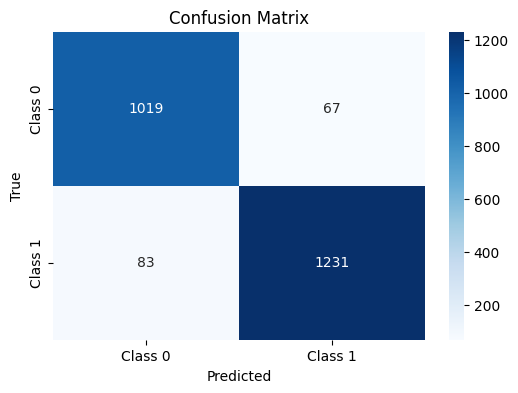

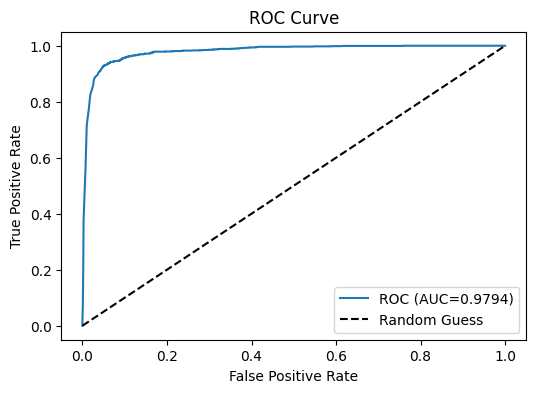

In [51]:
# 4.8 Confusion Matrix Visualization
cm = confusion_matrix(y_test_bert_np, predicted_labels_np)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 4.9 ROC Curve and AUC
y_test_bert_prob = torch.softmax(torch.tensor(predictions.predictions), dim=1)[:,1].cpu().numpy()
fpr, tpr, thresholds = roc_curve(y_test_bert_np, y_test_bert_prob)
roc_auc = roc_auc_score(y_test_bert_np, y_test_bert_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.4f})")
plt.plot([0,1], [0,1], 'k--', label='Random Guess')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# Summary

We have demonstrated:
1. A **Dense Neural Network** approach using Keras, with a standard train-test split, fitting, and evaluating model performance.
2. A **Transformer-based** approach (BERT) using Hugging Face, including tokenization, dataset creation, training, and evaluation with standard metrics.

You can further refine hyperparameters, epochs, or incorporate advanced techniques like early stopping and learning-rate scheduling to improve performance.
